In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

In [2]:
##### Limit GPU for training ###
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# File loading
### read hopital names from datasets ###
df = pd.read_csv(r'../datasets/hospital_augment_train3.csv')

In [4]:
hospital_gen_train = list(df['gen_data'])
hospital_true_train = list(df['true_data'])

In [5]:
df_val = pd.read_csv(r'../datasets/hospital_augment_val3.csv')
df_test = pd.read_csv(r'../datasets/hospital_augment_test3.csv')

In [6]:
hospital_gen_val = list(df_val['gen_data'])
hospital_true_val = list(df_val['true_data'])
hospital_gen_test = list(df_test['gen_data'])
hospital_true_test = list(df_test['true_data'])

In [7]:
len(hospital_gen_train)

30961

In [8]:
# Preprocessing
import re
def process(sent):
    sent=sent.lower()
    sent=re.sub(r'[^0-9a-zA-Z ]','',sent)
    sent=sent.replace('\n','')
    return sent 

In [9]:
from pythainlp import thai_letters

In [10]:
label_map_0 = ["0","1","2","3","4","5","6","7","8","9","-",".","/","(",")","\"","&"]
label_map_1 = list(thai_letters)

In [11]:
char_set = label_map_0+label_map_1

In [12]:
char2int = { char_set[x]:x for x in range(len(char_set)) }
int2char = { char2int[x]:x for x in char_set }

In [13]:
count = len(char_set)
codes = ['\t' ,'\n', ' ']

In [14]:
for i in range(len(codes)):
    code = codes[i]
    char2int[code]=count
    int2char[count]=code
    count+=1

In [15]:
input_texts = []
target_texts = []

In [16]:
hospital_true_train[0]

'คลินิกกรุงเทพระยองสาขาบ่อวิน'

In [17]:
for i,line in enumerate(hospital_true_train):
    output_text = '\t' + line + '\n'
    input_texts.append(hospital_gen_train[i])
    target_texts.append(output_text)
print("LEN OF SAMPLES:",len(input_texts))

LEN OF SAMPLES: 30961


In [18]:
input_texts[0],target_texts[0]

('คลินิกกรุงเทพระยองาขาบ่อวิน', '\tคลินิกกรุงเทพระยองสาขาบ่อวิน\n')

In [19]:
max_enc_len = max([len(x)+x.count(' ') for x in input_texts])
max_dec_len = max([len(x)+x.count(' ') for x in target_texts])
print("Max Enc Len:",max_enc_len)
print("Max Dec Len:",max_dec_len)

Max Enc Len: 74
Max Dec Len: 75


In [20]:
num_samples = len(input_texts)
encoder_input_data = np.zeros( (num_samples , max_enc_len , len(char_set)+3),dtype='float32' )
decoder_input_data = np.zeros( (num_samples , max_dec_len , len(char_set)+3),dtype='float32' )
decoder_target_data = np.zeros( (num_samples , max_dec_len , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [21]:
encoder_input_data.shape,decoder_input_data.shape,decoder_target_data.shape

((30961, 74, 93), (30961, 75, 93), (30961, 75, 93))

In [22]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(input_texts,target_texts)):
    for t,char in enumerate(input_text):
        encoder_input_data[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")         

COMPLETED...


In [23]:
len(input_texts),len(target_texts)

(30961, 30961)

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Dense,Activation,Attention,Bidirectional,Concatenate
import tensorflow as tf

In [25]:
batch_size = 128
epochs = 100
latent_dim = 128

num_enc_tokens = len(char_set)+3
num_dec_tokens = len(char_set) + 3 # includes \n \t ' '
encoder_inputs = Input(shape=(None,num_enc_tokens))
encoder = Bidirectional(LSTM(latent_dim,return_state=True))
#encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
#encoder_outputs , state_h, state_c = encoder(encoder_inputs)
#encoder_states = [state_h,state_c]
#encoder_states = [ forward_h, forward_c, backward_h, backward_c]
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

In [26]:
decoder_inputs = Input(shape=(None,num_dec_tokens))
decoder_lstm = LSTM(latent_dim*2,return_sequences=True,return_state=True)
decoder_ouputs,_,_ = decoder_lstm(decoder_inputs,initial_state = encoder_states)

In [27]:
num_dec_tokens

93

In [28]:
decoder_dense = Dense(num_dec_tokens, activation='softmax')
decoder_ouputs = decoder_dense(decoder_ouputs)

In [29]:
val_x = []
val_y = []
for i,line in enumerate(hospital_true_val):
    output_text = '\t' + line + '\n'
    val_x.append(hospital_gen_val[i])
    val_y.append(output_text)
print("LEN OF SAMPLES:",len(val_x))

LEN OF SAMPLES: 3353


In [30]:
max_enc_len_val = max([len(x)+x.count(' ') for x in val_x])
max_dec_len_val = max([len(x)+x.count(' ') for x in val_y])
print("Max Enc Len:",max_enc_len_val)
print("Max Dec Len:",max_dec_len_val)

Max Enc Len: 73
Max Dec Len: 75


In [31]:
##### Validation Set #####
num_samples_val = len(val_x)
encoder_input_data_val = np.zeros( (num_samples_val , max_enc_len_val , len(char_set)+3),dtype='float32' )
decoder_input_data_val = np.zeros( (num_samples_val , max_dec_len_val , len(char_set)+3),dtype='float32' )
decoder_target_data_val = np.zeros( (num_samples_val , max_dec_len_val , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [32]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(val_x,val_y)):
    for t,char in enumerate(input_text):
        encoder_input_data_val[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data_val[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data_val[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")     

COMPLETED...


In [33]:
model = Model([encoder_inputs,decoder_inputs],decoder_ouputs)
#model = Model.add(Attention())
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 256), (None, 227328      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]          

In [36]:
### Model includes only true sequence ###
earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='accuracy', min_delta=0.0001,
  patience=50)

saveModel_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath= "models/bilstm_hosipital_gendata_v3",
            save_best_only=True,
            monitor='accuracy',
            save_weights_only = True,
            verbose=1)
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-4 * 0.95 ** x)

In [37]:
hist=model.fit([encoder_input_data,decoder_input_data],decoder_target_data
         ,epochs = 200,validation_data=([encoder_input_data_val,decoder_input_data_val],decoder_target_data_val),
          batch_size = batch_size,callbacks=[earlystop_callback,saveModel_callback])

- val_loss: 0.0046 - val_accuracy: 0.2819
Epoch 110/200
30720/30961 [============================>.] - ETA: 0s - loss: 7.8176e-05 - accuracy: 0.2818
Epoch 00110: accuracy did not improve from 0.28204
30961/30961 [==============================] - 13s 419us/sample - loss: 7.8001e-05 - accuracy: 0.2819 - val_loss: 0.0045 - val_accuracy: 0.2818
Epoch 111/200
30848/30961 [============================>.] - ETA: 0s - loss: 6.4223e-05 - accuracy: 0.2819
Epoch 00111: accuracy did not improve from 0.28204
30961/30961 [==============================] - 13s 413us/sample - loss: 6.4159e-05 - accuracy: 0.2819 - val_loss: 0.0045 - val_accuracy: 0.2820
Epoch 112/200
30848/30961 [============================>.] - ETA: 0s - loss: 5.7219e-05 - accuracy: 0.2819
Epoch 00112: accuracy did not improve from 0.28204
30961/30961 [==============================] - 13s 419us/sample - loss: 5.7165e-05 - accuracy: 0.2819 - val_loss: 0.0044 - val_accuracy: 0.2818
Epoch 113/200
30848/30961 [=========================

In [39]:
import matplotlib.pyplot as plt

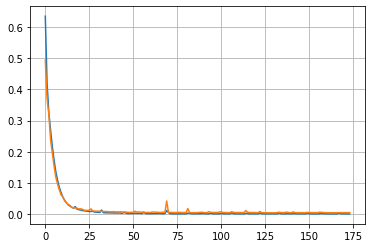

In [72]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.grid()

In [40]:
encoder_model = Model(encoder_inputs,encoder_states)

decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]
decoder_outputs,state_h,state_c = decoder_lstm(
        decoder_inputs,initial_state = decoder_states_inputs
)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
encoder_model.save('encoder_v3.h5')
decoder_model.save('decoder_v3.h5')

In [37]:
from tensorflow.keras.models import load_model

In [38]:
encoder_model = load_model('encoder_v3.h5',compile=False)

In [39]:
decoder_model = load_model('decoder_v3.h5',compile=False)

In [71]:
len(b) + b.count(' ')

72

In [41]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_dec_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char2int['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    decoded_list =[]
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = int2char[sampled_token_index]
        decoded_sentence += sampled_char
        decoded_list.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_dec_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_dec_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence,decoded_list

In [ ]:
pred_sent_train = []
for seq_index in range(len(input_texts)):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence,lst = decode_sequence(input_seq)
    pred_sent_train.append(lst)
    print('-')
    print('Wrong sentence:', input_texts[seq_index])
    print('Corrected sentence:', decoded_sentence)
    print('Ground Truth:',target_texts[seq_index])

-
Wrong sentence: คลินิกกรุงเทพระยองาขาบ่อวิน
Corrected sentence: คลินิกกรุงเทพระยองสาขาบ่อวิน

Ground Truth: 	คลินิกกรุงเทพระยองสาขาบ่อวิน

-
Wrong sentence: คลินิกกรุงเทระยองสาขาบ้านฉาง
Corrected sentence: คลินิกกรุงเทพระยองสาขาบ้านฉาง

Ground Truth: 	คลินิกกรุงเทพระยองสาขาบ้านฉาง

-
Wrong sentence: คลินิกกรุงเทระยองสาขาปลวกแดง
Corrected sentence: คลินิกกรุงเทพระยองสาขาปลวกแดง

Ground Truth: 	คลินิกกรุงเทพระยองสาขาปลวกแดง

-
Wrong sentence: คินิกไทยอินเตอร์การแพทย์(เกาะพงัน)
Corrected sentence: คลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)

Ground Truth: 	คลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)

-
Wrong sentence: คลินิกพญไทเวชกรรมบ่อวิน
Corrected sentence: คลินิกพญาไทเวชกรรมบ่อวิน

Ground Truth: 	คลินิกพญาไทเวชกรรมบ่อวิน

-
Wrong sentence: คลินกรวมแพทย์นิคม
Corrected sentence: คลินิกรวมแพทย์นิคม

Ground Truth: 	คลินิกรวมแพทย์นิคม

-
Wrong sentence: คลินิกรักสุขภาจ.ระยอง
Corrected sentence: คลินิกรักสุขภาพจ.ระยอง

Ground Truth: 	คลินิกรักสุขภาพจ.ระยอง

-
Wrong sentence: คลินกโรงพยาบาลกรุงเทพพัทยาสา

-
Wrong sentence: โรงพยาบาลกรุงเทพพิษณโลก
Corrected sentence: โรงพยาบาลกรุงเทพพิษณุโลก

Ground Truth: 	โรงพยาบาลกรุงเทพพิษณุโลก

-
Wrong sentence: โงพยาบาลกรุงเทพภูเก็ต
Corrected sentence: โรงพยาบาลกรุงเทพภูเก็ต

Ground Truth: 	โรงพยาบาลกรุงเทพภูเก็ต

-
Wrong sentence: โรงพยาบาลกรุเทพระยอง
Corrected sentence: โรงพยาบาลกรุงเทพระยอง

Ground Truth: 	โรงพยาบาลกรุงเทพระยอง

-
Wrong sentence: โรงพยาบาลรุงเทพราชสีมา
Corrected sentence: โรงพยาบาลกรุงเทพราชสีมา

Ground Truth: 	โรงพยาบาลกรุงเทพราชสีมา

-
Wrong sentence: โรพยาบาลกรุงเทพสมุย
Corrected sentence: โรงพยาบาลกรุงเทพสมุย

Ground Truth: 	โรงพยาบาลกรุงเทพสมุย

-
Wrong sentence: โรงพยาบาลกรุงเทพหวหิน
Corrected sentence: โรงพยาบาลกรุงเทพหัวหิน

Ground Truth: 	โรงพยาบาลกรุงเทพหัวหิน

-
Wrong sentence: โรงพยาบาลกรุงเพอุดร
Corrected sentence: โรงพยาบาลกรุงเทพอุดร

Ground Truth: 	โรงพยาบาลกรุงเทพอุดร

-
Wrong sentence: โรงพยาบาลกรุไทย
Corrected sentence: โรงพยาบาลกรุงไทย

Ground Truth: 	โรงพยาบาลกรุงไทย

-
Wrong sentence: โรงพยาบาลกว้ยน้าไท1
Co

-
Wrong sentence: โรงพยาบาลเขาคิฌกูฏ
Corrected sentence: โรงพยาบาลเขาคิชฌกูฏ

Ground Truth: 	โรงพยาบาลเขาคิชฌกูฏ

-
Wrong sentence: โรงพยาบาลเขาชะเมา เฉลิมระเกียรติ 80 พรรษา
Corrected sentence: โรงพยาบาลเขาชะเมา เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลเขาชะเมา เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โงพยาบาลเขาชัยสน
Corrected sentence: โรงพยาบาลเขาชัยสน

Ground Truth: 	โรงพยาบาลเขาชัยสน

-
Wrong sentence: โรงพยาาลเขาพนม
Corrected sentence: โรงพยาบาลเขาพนม

Ground Truth: 	โรงพยาบาลเขาพนม

-
Wrong sentence: โรงพยาบาเขาย้อย
Corrected sentence: โรงพยาบาลเขาย้อย

Ground Truth: 	โรงพยาบาลเขาย้อย

-
Wrong sentence: โรงพยาบาลเขาว
Corrected sentence: โรงพยาบาลเขาวง

Ground Truth: 	โรงพยาบาลเขาวง

-
Wrong sentence: โรงพยาาลเขาสมิง
Corrected sentence: โรงพยาบาลเขาสมิง

Ground Truth: 	โรงพยาบาลเขาสมิง

-
Wrong sentence: โรงพยาบาเขาสวนกวาง
Corrected sentence: โรงพยาบาลเขาสวนกวาง

Ground Truth: 	โรงพยาบาลเขาสวนกวาง

-
Wrong sentence: โรงพยาบลเขาสุกิม
Corrected sentence: โรงพยาบาลเขาสุก

-
Wrong sentence: รงพยาบาลชัยบาดาล
Corrected sentence: โรงพยาบาลชัยบาดาล

Ground Truth: 	โรงพยาบาลชัยบาดาล

-
Wrong sentence: โรงพยาบาลัยบุรี
Corrected sentence: โรงพยาบาลชัยบุรี

Ground Truth: 	โรงพยาบาลชัยบุรี

-
Wrong sentence: โรงพยาบาลชยภูมิ
Corrected sentence: โรงพยาบาลชัยภูมิ

Ground Truth: 	โรงพยาบาลชัยภูมิ

-
Wrong sentence: โรงพาบาลชัยภูมิรวมแพทย์
Corrected sentence: โรงพยาบาลชัยภูมิรวมแพทย์

Ground Truth: 	โรงพยาบาลชัยภูมิรวมแพทย์

-
Wrong sentence: โรพยาบาลชัยภูมิราม
Corrected sentence: โรงพยาบาลชัยภูมิราม

Ground Truth: 	โรงพยาบาลชัยภูมิราม

-
Wrong sentence: โรงพาบาลชัยอรุณเวชการ
Corrected sentence: โรงพยาบาลชัยอรุณเวชการ

Ground Truth: 	โรงพยาบาลชัยอรุณเวชการ

-
Wrong sentence: โรงพยาบาลา้งเผือก
Corrected sentence: โรงพยาบาลชา้งเผือก

Ground Truth: 	โรงพยาบาลชา้งเผือก

-
Wrong sentence: โรงพยาบาชานุมาน
Corrected sentence: โรงพยาบาลชานุมาน

Ground Truth: 	โรงพยาบาลชานุมาน

-
Wrong sentence: โรพยาบาลชำนิ
Corrected sentence: โรงพยาบาลชำนิ

Ground Truth: 	โรงพยาบาลชำนิ

-
Wr

-
Wrong sentence: โรงพยาบลทองแสนขัน
Corrected sentence: โรงพยาบาลทองแสนขัน

Ground Truth: 	โรงพยาบาลทองแสนขัน

-
Wrong sentence: โรงพยาบาลทักษิณสุราษฎร
Corrected sentence: โรงพยาบาลทักษิณสุราษฎร์

Ground Truth: 	โรงพยาบาลทักษิณสุราษฎร์

-
Wrong sentence: โงพยาบาลทับคล้อ
Corrected sentence: โรงพยาบาลทับคล้อ

Ground Truth: 	โรงพยาบาลทับคล้อ

-
Wrong sentence: โงพยาบาลทับปุด
Corrected sentence: โรงพยาบาลทับปุด

Ground Truth: 	โรงพยาบาลทับปุด

-
Wrong sentence: โรงพยาบาลทัทัน
Corrected sentence: โรงพยาบาลทัพทัน

Ground Truth: 	โรงพยาบาลทัพทัน

-
Wrong sentence: โรงพยาบาลท่ากะดาน
Corrected sentence: โรงพยาบาลท่ากระดาน

Ground Truth: 	โรงพยาบาลท่ากระดาน

-
Wrong sentence: โรพยาบาลท่าคันโท
Corrected sentence: โรงพยาบาลท่าคันโท

Ground Truth: 	โรงพยาบาลท่าคันโท

-
Wrong sentence: โรงพยาาลท่าฉาง
Corrected sentence: โรงพยาบาลท่าฉาง

Ground Truth: 	โรงพยาบาลท่าฉาง

-
Wrong sentence: โรงพยาบลท่าชนะ
Corrected sentence: โรงพยาบาลท่าชนะ

Ground Truth: 	โรงพยาบาลท่าชนะ

-
Wrong sentence: โรงพยาบาท่าช้

-
Wrong sentence: รงพยาบาลนากลาง
Corrected sentence: โรงพยาบาลนากลาง

Ground Truth: 	โรงพยาบาลนากลาง

-
Wrong sentence: โรงพยาบลนาแก
Corrected sentence: โรงพยาบาลนาแก

Ground Truth: 	โรงพยาบาลนาแก

-
Wrong sentence: โรงพยาบาลนงรอง
Corrected sentence: โรงพยาบาลนางรอง

Ground Truth: 	โรงพยาบาลนางรอง

-
Wrong sentence: โรงพยาบาลนจะหลวย
Corrected sentence: โรงพยาบาลนาจะหลวย

Ground Truth: 	โรงพยาบาลนาจะหลวย

-
Wrong sentence: โรพยาบาลนาเชือก
Corrected sentence: โรงพยาบาลนาเชือก

Ground Truth: 	โรงพยาบาลนาเชือก

-
Wrong sentence: โงพยาบาลนาดี
Corrected sentence: โรงพยาบาลนาดี

Ground Truth: 	โรงพยาบาลนาดี

-
Wrong sentence: โรงพยาบาลนดูน
Corrected sentence: โรงพยาบาลนาดูน

Ground Truth: 	โรงพยาบาลนาดูน

-
Wrong sentence: โงพยาบาลนาตาล
Corrected sentence: โรงพยาบาลนาตาล

Ground Truth: 	โรงพยาบาลนาตาล

-
Wrong sentence: โรงพาบาลน่าน
Corrected sentence: โรงพยาบาลน่าน

Ground Truth: 	โรงพยาบาลน่าน

-
Wrong sentence: รงพยาบาลนาน้อย
Corrected sentence: โรงพยาบาลนาน้อย

Ground Truth: 	โรงพยาบาลนาน

-
Wrong sentence: โงพยาบาลบางระกำ
Corrected sentence: โรงพยาบาลบางระกำ

Ground Truth: 	โรงพยาบาลบางระกำ

-
Wrong sentence: โรงพยาบาลบางละมง
Corrected sentence: โรงพยาบาลบางละมุง

Ground Truth: 	โรงพยาบาลบางละมุง

-
Wrong sentence: โรงพยาบาบางสะพานน้อย
Corrected sentence: โรงพยาบาลบางสะพานน้อย

Ground Truth: 	โรงพยาบาลบางสะพานน้อย

-
Wrong sentence: โรงพยาบาลบางเาธง
Corrected sentence: โรงพยาบาลบางเสาธง

Ground Truth: 	โรงพยาบาลบางเสาธง

-
Wrong sentence: โรงพยาบาลบางใหญ
Corrected sentence: โรงพยาบาลบางใหญ่

Ground Truth: 	โรงพยาบาลบางใหญ่

-
Wrong sentence: โรงพยาบาลบาเจะ
Corrected sentence: โรงพยาบาลบาเจาะ

Ground Truth: 	โรงพยาบาลบาเจาะ

-
Wrong sentence: โรงพยบาลบ้านกรวด
Corrected sentence: โรงพยาบาลบ้านกรวด

Ground Truth: 	โรงพยาบาลบ้านกรวด

-
Wrong sentence: โรงยาบาลบ้านเขว้า
Corrected sentence: โรงพยาบาลบ้านเขว้า

Ground Truth: 	โรงพยาบาลบ้านเขว้า

-
Wrong sentence: โรพยาบาลบ้านคา
Corrected sentence: โรงพยาบาลบ้านคา

Ground Truth: 	โรงพยาบาลบ้านคา

-
Wrong sentence: โรงพยาบาลบานค

-
Wrong sentence: โรงพยบาลปัตตานี
Corrected sentence: โรงพยาบาลปัตตานี

Ground Truth: 	โรงพยาบาลปัตตานี

-
Wrong sentence: โรงพยาบาลปากเกรด
Corrected sentence: โรงพยาบาลปากเกร็ด

Ground Truth: 	โรงพยาบาลปากเกร็ด

-
Wrong sentence: โรงยาบาลปากคาด
Corrected sentence: โรงพยาบาลปากคาด

Ground Truth: 	โรงพยาบาลปากคาด

-
Wrong sentence: โรงพาบาลปากชม
Corrected sentence: โรงพยาบาลปากชม

Ground Truth: 	โรงพยาบาลปากชม

-
Wrong sentence: โรงพยาบาลปาช่องนานา
Corrected sentence: โรงพยาบาลปากช่องนานา

Ground Truth: 	โรงพยาบาลปากช่องนานา

-
Wrong sentence: โรงพยาบาลปากน้าโ
Corrected sentence: โรงพยาบาลปากน้าโพ

Ground Truth: 	โรงพยาบาลปากน้าโพ

-
Wrong sentence: โรงพยาบาปากน้าโพ2
Corrected sentence: โรงพยาบาลปากน้าโพ2

Ground Truth: 	โรงพยาบาลปากน้าโพ2

-
Wrong sentence: รงพยาบาลปากน้ำชุมพร
Corrected sentence: โรงพยาบาลปากน้ำชุมพร

Ground Truth: 	โรงพยาบาลปากน้ำชุมพร

-
Wrong sentence: โรงพยาบาลปาก้ำหลังสวน
Corrected sentence: โรงพยาบาลปากน้ำหลังสวน

Ground Truth: 	โรงพยาบาลปากน้ำหลังสวน

-
Wrong se

-
Wrong sentence: โรงพยาบาลพงโคน
Corrected sentence: โรงพยาบาลพังโคน

Ground Truth: 	โรงพยาบาลพังโคน

-
Wrong sentence: รงพยาบาลพังงา
Corrected sentence: โรงพยาบาลพังงา

Ground Truth: 	โรงพยาบาลพังงา

-
Wrong sentence: โรงยาบาลพัฒนเวชสุโขทัย
Corrected sentence: โรงพยาบาลพัฒนเวชสุโขทัย

Ground Truth: 	โรงพยาบาลพัฒนเวชสุโขทัย

-
Wrong sentence: โรงพยาบาลพัฒนาิคม
Corrected sentence: โรงพยาบาลพัฒนานิคม

Ground Truth: 	โรงพยาบาลพัฒนานิคม

-
Wrong sentence: โรงพยาบาลพัยาเมโมเรียล
Corrected sentence: โรงพยาบาลพัทยาเมโมเรียล

Ground Truth: 	โรงพยาบาลพัทยาเมโมเรียล

-
Wrong sentence: โรงพยาาลพัทลุง
Corrected sentence: โรงพยาบาลพัทลุง

Ground Truth: 	โรงพยาบาลพัทลุง

-
Wrong sentence: โรงยาบาลพาน
Corrected sentence: โรงพยาบาลพาน

Ground Truth: 	โรงพยาบาลพาน

-
Wrong sentence: รงพยาบาลพิจิตร
Corrected sentence: โรงพยาบาลพิจิตร

Ground Truth: 	โรงพยาบาลพิจิตร

-
Wrong sentence: โรงพยาบาลิชัย
Corrected sentence: โรงพยาบาลพิชัย

Ground Truth: 	โรงพยาบาลพิชัย

-
Wrong sentence: โรงพยาบาลพิบูลังสาหาร


-
Wrong sentence: โรงพยาบาลเมตตาประชารักษ์(วัไร่ขิง)
Corrected sentence: โรงพยาบาลเมตตาประชารักษ์(วัดไร่ขิง)

Ground Truth: 	โรงพยาบาลเมตตาประชารักษ์(วัดไร่ขิง)

-
Wrong sentence: โรงยาบาลเมยวดี
Corrected sentence: โรงพยาบาลเมยวดี

Ground Truth: 	โรงพยาบาลเมยวดี

-
Wrong sentence: รงพยาบาลเมืองจันทร์
Corrected sentence: โรงพยาบาลเมืองจันทร์

Ground Truth: 	โรงพยาบาลเมืองจันทร์

-
Wrong sentence: โรงพยาบาลเมืองนาราย์
Corrected sentence: โรงพยาบาลเมืองนารายณ์

Ground Truth: 	โรงพยาบาลเมืองนารายณ์

-
Wrong sentence: รงพยาบาลเมืองปาน
Corrected sentence: โรงพยาบาลเมืองปาน

Ground Truth: 	โรงพยาบาลเมืองปาน

-
Wrong sentence: โรพยาบาลเมืองเพชร
Corrected sentence: โรงพยาบาลเมืองเพชร

Ground Truth: 	โรงพยาบาลเมืองเพชร

-
Wrong sentence: โรงพยาบาเมืองราช
Corrected sentence: โรงพยาบาลเมืองราช

Ground Truth: 	โรงพยาบาลเมืองราช

-
Wrong sentence: โรงพยาบาลเมืองเลยรา
Corrected sentence: โรงพยาบาลเมืองเลยราม

Ground Truth: 	โรงพยาบาลเมืองเลยราม

-
Wrong sentence: โรงพยาบาลมืองสมุทรปากน้า
Corrected se

-
Wrong sentence: โรงพยาบาลราัน
Corrected sentence: โรงพยาบาลรามัน

Ground Truth: 	โรงพยาบาลรามัน

-
Wrong sentence: โรงพยาบาลราษฎร์บูณะ
Corrected sentence: โรงพยาบาลราษฎร์บูรณะ

Ground Truth: 	โรงพยาบาลราษฎร์บูรณะ

-
Wrong sentence: โรงพยาบาลราษฎร์ยินดีาดใหญ่
Corrected sentence: โรงพยาบาลราษฎร์ยินดีหาดใหญ่

Ground Truth: 	โรงพยาบาลราษฎร์ยินดีหาดใหญ่

-
Wrong sentence: โรงพยาบาลราษไศล
Corrected sentence: โรงพยาบาลราษีไศล

Ground Truth: 	โรงพยาบาลราษีไศล

-
Wrong sentence: โงพยาบาลรือเสาะ
Corrected sentence: โรงพยาบาลรือเสาะ

Ground Truth: 	โรงพยาบาลรือเสาะ

-
Wrong sentence: โรงพยาบาลเรณูนค
Corrected sentence: โรงพยาบาลเรณูนคร

Ground Truth: 	โรงพยาบาลเรณูนคร

-
Wrong sentence: โรพยาบาลลอง
Corrected sentence: โรงพยาบาลลอง

Ground Truth: 	โรงพยาบาลลอง

-
Wrong sentence: โรงพยาบาละงู
Corrected sentence: โรงพยาบาลละงู

Ground Truth: 	โรงพยาบาลละงู

-
Wrong sentence: โรงพยาบาลละม
Corrected sentence: โรงพยาบาลละแม

Ground Truth: 	โรงพยาบาลละแม

-
Wrong sentence: รงพยาบาลละหานทราย
Corrected 

-
Wrong sentence: รงพยาบาลเวียงแก่น
Corrected sentence: โรงพยาบาลเวียงแก่น

Ground Truth: 	โรงพยาบาลเวียงแก่น

-
Wrong sentence: โรงพยาบาลเวียเชียงรุ้ง
Corrected sentence: โรงพยาบาลเวียงเชียงรุ้ง

Ground Truth: 	โรงพยาบาลเวียงเชียงรุ้ง

-
Wrong sentence: โรงพยาบาลวียงป่าเป้า
Corrected sentence: โรงพยาบาลเวียงป่าเป้า

Ground Truth: 	โรงพยาบาลเวียงป่าเป้า

-
Wrong sentence: โรงพยบาลเวียงสา
Corrected sentence: โรงพยาบาลเวียงสา

Ground Truth: 	โรงพยาบาลเวียงสา

-
Wrong sentence: โรงพยาบาลวียงหนองล่อง
Corrected sentence: โรงพยาบาลเวียงหนองล่อง

Ground Truth: 	โรงพยาบาลเวียงหนองล่อง

-
Wrong sentence: โรงพยบาลเวียงแหง
Corrected sentence: โรงพยาบาลเวียงแหง

Ground Truth: 	โรงพยาบาลเวียงแหง

-
Wrong sentence: โรงพยบาลแว้ง
Corrected sentence: โรงพยาบาลแว้ง

Ground Truth: 	โรงพยาบาลแว้ง

-
Wrong sentence: โรงพยาบาลแงน้อย
Corrected sentence: โรงพยาบาลแวงน้อย

Ground Truth: 	โรงพยาบาลแวงน้อย

-
Wrong sentence: โรงพยาบาลวงใหญ่
Corrected sentence: โรงพยาบาลแวงใหญ่

Ground Truth: 	โรงพยาบาลแวงใหญ่

-

-
Wrong sentence: โรงพยาบาลสมเด็พระพุทธเลิศหล้า
Corrected sentence: โรงพยาบาลสมเด็จพระพุทธเลิศหล้า

Ground Truth: 	โรงพยาบาลสมเด็จพระพุทธเลิศหล้า

-
Wrong sentence: โรงพยาบาลสมเด็จพระยุราชกุฉินารายณ์
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชกุฉินารายณ์

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชกุฉินารายณ์

-
Wrong sentence: โรงพยาบาลสมเด็จพระยุพราชจมบึง
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชจอมบึง

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชจอมบึง

-
Wrong sentence: โรงพยาบาลสมเด็พระยุพราชฉวาง
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชฉวาง

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชฉวาง

-
Wrong sentence: โรพยาบาลสมเด็จพระยุพราชด่านซ้าย
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชด่านซ้าย

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชด่านซ้าย

-
Wrong sentence: โรงพยบาลสมเด็จพระยุพราชเดชอุดม
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชเดชอุดม

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชเดชอุดม

-
Wrong sentence: โรงพยาบาลสเด็จพระยุพราชเด่นชัย
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชเด่นชัย

-
Wrong sentence: โรงพยาบาลสำโรงาบ
Corrected sentence: โรงพยาบาลสำโรงทาบ

Ground Truth: 	โรงพยาบาลสำโรงทาบ

-
Wrong sentence: โรงพยาาลสิเกา
Corrected sentence: โรงพยาบาลสิเกา

Ground Truth: 	โรงพยาบาลสิเกา

-
Wrong sentence: โรงพยาบาลสงหนคร
Corrected sentence: โรงพยาบาลสิงหนคร

Ground Truth: 	โรงพยาบาลสิงหนคร

-
Wrong sentence: โรงพยาบาลิงห์บุรี
Corrected sentence: โรงพยาบาลสิงห์บุรี

Ground Truth: 	โรงพยาบาลสิงห์บุรี

-
Wrong sentence: รงพยาบาลสิงห์บุรีเวชชการ(หมอประเจิด)
Corrected sentence: โรงพยาบาลสิงห์บุรีเวชชการ(หมอประเจิด)

Ground Truth: 	โรงพยาบาลสิงห์บุรีเวชชการ(หมอประเจิด)

-
Wrong sentence: โรงพยาบลสิชล
Corrected sentence: โรงพยาบาลสิชล

Ground Truth: 	โรงพยาบาลสิชล

-
Wrong sentence: โรงพยาบาลสิริธร
Corrected sentence: โรงพยาบาลสิรินธร

Ground Truth: 	โรงพยาบาลสิรินธร

-
Wrong sentence: โรงพยาบาลสิรินธร(ภาคตะวัออกเฉียงเหนือ)
Corrected sentence: โรงพยาบาลสิรินธร(ภาคตะวันออกเฉียงเหนือ)

Ground Truth: 	โรงพยาบาลสิรินธร(ภาคตะวันออกเฉียงเหนือ)

-
Wrong sentence: โรงพยาบาลสริโรจน

-
Wrong sentence: โรงพยาบาล้วยเม็ก
Corrected sentence: โรงพยาบาลห้วยเม็ก

Ground Truth: 	โรงพยาบาลห้วยเม็ก

-
Wrong sentence: โรงพยาบาห้วยยอด
Corrected sentence: โรงพยาบาลห้วยยอด

Ground Truth: 	โรงพยาบาลห้วยยอด

-
Wrong sentence: โรงพยาบาลห้วยรช
Corrected sentence: โรงพยาบาลห้วยราช

Ground Truth: 	โรงพยาบาลห้วยราช

-
Wrong sentence: โรงพยาบาลว้านใหญ่
Corrected sentence: โรงพยาบาลหว้านใหญ่

Ground Truth: 	โรงพยาบาลหว้านใหญ่

-
Wrong sentence: โรงพยาาลหัวเฉียว
Corrected sentence: โรงพยาบาลหัวเฉียว

Ground Truth: 	โรงพยาบาลหัวเฉียว

-
Wrong sentence: โรงยาบาลหัวตะพาน
Corrected sentence: โรงพยาบาลหัวตะพาน

Ground Truth: 	โรงพยาบาลหัวตะพาน

-
Wrong sentence: โรงพยาบาลหัวทร
Corrected sentence: โรงพยาบาลหัวไทร

Ground Truth: 	โรงพยาบาลหัวไทร

-
Wrong sentence: โรงพยาบาลหัวิน
Corrected sentence: โรงพยาบาลหัวหิน

Ground Truth: 	โรงพยาบาลหัวหิน

-
Wrong sentence: โรงพยาบาลห้างฉตร
Corrected sentence: โรงพยาบาลห้างฉัตร

Ground Truth: 	โรงพยาบาลห้างฉัตร

-
Wrong sentence: โรงพยาบาหางดง
Corrected s

-
Wrong sentence: ถาบันมะเร็งแห่งชาติ
Corrected sentence: สถาบันมะเร็งแห่งชาติ

Ground Truth: 	สถาบันมะเร็งแห่งชาติ

-
Wrong sentence: สถบันราชานุกูล
Corrected sentence: สถาบันราชานุกูล

Ground Truth: 	สถาบันราชานุกูล

-
Wrong sentence: สถาบนโรคทรวงอก
Corrected sentence: สถาบันโรคทรวงอก

Ground Truth: 	สถาบันโรคทรวงอก

-
Wrong sentence: สถาบันโรคผิหนัง
Corrected sentence: สถาบันโรคผิวหนัง

Ground Truth: 	สถาบันโรคผิวหนัง

-
Wrong sentence: สถาบันวิจัยการแพทยแผนไทย
Corrected sentence: สถาบันวิจัยการแพทย์แผนไทย

Ground Truth: 	สถาบันวิจัยการแพทย์แผนไทย

-
Wrong sentence: สถาบันสิรินธรเพื่อการฟื้นฟูสมรรถภาพทางการแพย์แห่งชาติ
Corrected sentence: สถาบันสิรินธรเพื่อการฟื้นฟูสมรรถภาพทางการแพทย์แห่งชาติ

Ground Truth: 	สถาบันสิรินธรเพื่อการฟื้นฟูสมรรถภาพทางการแพทย์แห่งชาติ

-
Wrong sentence: สถาบันสุขภาพจิตเด็กและวัยรุ่นภคตะวันออกเฉียงเหนือ
Corrected sentence: สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคตะวันออกเฉียงเหนือ

Ground Truth: 	สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคตะวันออกเฉียงเหนือ

-
Wrong sentence

-
Wrong sentence: เซ็นทรัลเมดิคลินิกเวชกรรมสาขาพระโขนง
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาพระโขนง

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาพระโขนง

-
Wrong sentence: เทเแคร์คลินิกเจริญกรุง
Corrected sentence: เทเลแคร์คลินิกเจริญกรุง

Ground Truth: 	เทเลแคร์คลินิกเจริญกรุง

-
Wrong sentence: เทเลแค์คลินิกสหคลินิกสาขาวัชรพล
Corrected sentence: เทเลแคร์คลินิกสหคลินิกสาขาวัชรพล

Ground Truth: 	เทเลแคร์คลินิกสหคลินิกสาขาวัชรพล

-
Wrong sentence: เทลแคร์คลินิกสุขาภิบาล3
Corrected sentence: เทเลแคร์คลินิกสุขาภิบาล3

Ground Truth: 	เทเลแคร์คลินิกสุขาภิบาล3

-
Wrong sentence: บางพรเมดิคอลเซนเตอร์
Corrected sentence: บางพระเมดิคอลเซนเตอร์

Ground Truth: 	บางพระเมดิคอลเซนเตอร์

-
Wrong sentence: บาน
Corrected sentence: บ้าน

Ground Truth: 	บ้าน

-
Wrong sentence: เปาโลเมโเรียลรังสิตคลินิกเวชกรรม
Corrected sentence: เปาโลเมโมเรียลรังสิตคลินิกเวชกรรม

Ground Truth: 	เปาโลเมโมเรียลรังสิตคลินิกเวชกรรม

-
Wrong sentence: โรงพยาบาล50 พรรษา มหาวชิราลกรณ์
Corrected sentence: โรงพยาบาล

-
Wrong sentence: โรงพยาบาลแก่คอย
Corrected sentence: โรงพยาบาลแก่งคอย

Ground Truth: 	โรงพยาบาลแก่งคอย

-
Wrong sentence: โงพยาบาลแก้งสนามนาง
Corrected sentence: โรงพยาบาลแก้งสนามนาง

Ground Truth: 	โรงพยาบาลแก้งสนามนาง

-
Wrong sentence: โรงพยาาลแก่งหางแมว
Corrected sentence: โรงพยาบาลแก่งหางแมว

Ground Truth: 	โรงพยาบาลแก่งหางแมว

-
Wrong sentence: โรงพยบาลแกดำ
Corrected sentence: โรงพยาบาลแกดำ

Ground Truth: 	โรงพยาบาลแกดำ

-
Wrong sentence: โรงพยาบาลโกรกพร
Corrected sentence: โรงพยาบาลโกรกพระ

Ground Truth: 	โรงพยาบาลโกรกพระ

-
Wrong sentence: โรงพยบาลโกสัมพีนคร
Corrected sentence: โรงพยาบาลโกสัมพีนคร

Ground Truth: 	โรงพยาบาลโกสัมพีนคร

-
Wrong sentence: โรงพยาบาลโกสุมพิัย
Corrected sentence: โรงพยาบาลโกสุมพิสัย

Ground Truth: 	โรงพยาบาลโกสุมพิสัย

-
Wrong sentence: โรงพยาบาลขอม
Corrected sentence: โรงพยาบาลขนอม

Ground Truth: 	โรงพยาบาลขนอม

-
Wrong sentence: รงพยาบาลขลุง
Corrected sentence: โรงพยาบาลขลุง

Ground Truth: 	โรงพยาบาลขลุง

-
Wrong sentence: โรงพยาบาลขอนแกน
Corrected

-
Wrong sentence: โรงพยาบาลุน
Corrected sentence: โรงพยาบาลจุน

Ground Truth: 	โรงพยาบาลจุน

-
Wrong sentence: โรงพยาบาลุฬาภรณ์
Corrected sentence: โรงพยาบาลจุฬาภรณ์

Ground Truth: 	โรงพยาบาลจุฬาภรณ์

-
Wrong sentence: โรงพยาบาลจุฬารตน์11
Corrected sentence: โรงพยาบาลจุฬารัตน์11

Ground Truth: 	โรงพยาบาลจุฬารัตน์11

-
Wrong sentence: โรงพยาบาลเจ็ดเสมยน
Corrected sentence: โรงพยาบาลเจ็ดเสมียน

Ground Truth: 	โรงพยาบาลเจ็ดเสมียน

-
Wrong sentence: โงพยาบาลเจริญศิลป์
Corrected sentence: โรงพยาบาลเจริญศิลป์

Ground Truth: 	โรงพยาบาลเจริญศิลป์

-
Wrong sentence: โรงพยาบาลเจ้าคุณไพบูย์พนมทวน
Corrected sentence: โรงพยาบาลเจ้าคุณไพบูลย์พนมทวน

Ground Truth: 	โรงพยาบาลเจ้าคุณไพบูลย์พนมทวน

-
Wrong sentence: โรงพยาบาลเจา้พระย
Corrected sentence: โรงพยาบาลเจา้พระยา

Ground Truth: 	โรงพยาบาลเจา้พระยา

-
Wrong sentence: โรงพยบาลเจ้าพระยายมราช
Corrected sentence: โรงพยาบาลเจ้าพระยายมราช

Ground Truth: 	โรงพยาบาลเจ้าพระยายมราช

-
Wrong sentence: โรงพยาบาลเจ้าพระยาอภัยภูเบร
Corrected sentence: โรงพยาบ

-
Wrong sentence: โรงพยาบาตารวจ
Corrected sentence: โรงพยาบาลตารวจ

Ground Truth: 	โรงพยาบาลตารวจ

-
Wrong sentence: โรงพยาบาลตาสุม
Corrected sentence: โรงพยาบาลตาลสุม

Ground Truth: 	โรงพยาบาลตาลสุม

-
Wrong sentence: โรงพยาบาลเตางอย
Corrected sentence: โรงพยาบาลเต่างอย

Ground Truth: 	โรงพยาบาลเต่างอย

-
Wrong sentence: โรงพยาบาลถ้ำพรรณร
Corrected sentence: โรงพยาบาลถ้ำพรรณรา

Ground Truth: 	โรงพยาบาลถ้ำพรรณรา

-
Wrong sentence: รงพยาบาลเถิน
Corrected sentence: โรงพยาบาลเถิน

Ground Truth: 	โรงพยาบาลเถิน

-
Wrong sentence: โรพยาบาลทรายทองวัฒนา
Corrected sentence: โรงพยาบาลทรายทองวัฒนา

Ground Truth: 	โรงพยาบาลทรายทองวัฒนา

-
Wrong sentence: โรงพาบาลทรายมูล
Corrected sentence: โรงพยาบาลทรายมูล

Ground Truth: 	โรงพยาบาลทรายมูล

-
Wrong sentence: โรงพยาบาลทงแสนขัน
Corrected sentence: โรงพยาบาลทองแสนขัน

Ground Truth: 	โรงพยาบาลทองแสนขัน

-
Wrong sentence: โรงพยาบาทักษิณสุราษฎร์
Corrected sentence: โรงพยาบาลทักษิณสุราษฎร์

Ground Truth: 	โรงพยาบาลทักษิณสุราษฎร์

-
Wrong sentence: โรงพยาบ

-
Wrong sentence: โรงพยาบาลนราธิวาสรานครินทร์
Corrected sentence: โรงพยาบาลนราธิวาสราชนครินทร์

Ground Truth: 	โรงพยาบาลนราธิวาสราชนครินทร์

-
Wrong sentence: โรพยาบาลนวมินทร์
Corrected sentence: โรงพยาบาลนวมินทร์

Ground Truth: 	โรงพยาบาลนวมินทร์

-
Wrong sentence: โรงพาบาลนวมินทร์9
Corrected sentence: โรงพยาบาลนวมินทร์9

Ground Truth: 	โรงพยาบาลนวมินทร์9

-
Wrong sentence: โรงพยาบาลนอร์ทอีสเทอร์นัฒนา
Corrected sentence: โรงพยาบาลนอร์ทอีสเทอร์นวัฒนา

Ground Truth: 	โรงพยาบาลนอร์ทอีสเทอร์นวัฒนา

-
Wrong sentence: โรงพยบาลนากลาง
Corrected sentence: โรงพยาบาลนากลาง

Ground Truth: 	โรงพยาบาลนากลาง

-
Wrong sentence: รงพยาบาลนาแก
Corrected sentence: โรงพยาบาลนาแก

Ground Truth: 	โรงพยาบาลนาแก

-
Wrong sentence: โรงพาบาลนาคู
Corrected sentence: โรงพยาบาลนาคู

Ground Truth: 	โรงพยาบาลนาคู

-
Wrong sentence: โรงพาบาลนางรอง
Corrected sentence: โรงพยาบาลนางรอง

Ground Truth: 	โรงพยาบาลนางรอง

-
Wrong sentence: โรงพยาบาลนาจะหวย
Corrected sentence: โรงพยาบาลนาจะหลวย

Ground Truth: 	โรงพยาบาลนาจะห

-
Wrong sentence: โรงพยาบาลบางะกำ
Corrected sentence: โรงพยาบาลบางระกำ

Ground Truth: 	โรงพยาบาลบางระกำ

-
Wrong sentence: รงพยาบาลบางระจัน
Corrected sentence: โรงพยาบาลบางระจัน

Ground Truth: 	โรงพยาบาลบางระจัน

-
Wrong sentence: โรงพยาบาบางละมุง
Corrected sentence: โรงพยาบาลบางละมุง

Ground Truth: 	โรงพยาบาลบางละมุง

-
Wrong sentence: โรงพยาบาลบาสะพาน
Corrected sentence: โรงพยาบาลบางสะพาน

Ground Truth: 	โรงพยาบาลบางสะพาน

-
Wrong sentence: โรงพยาบาลบางสะพานนอย
Corrected sentence: โรงพยาบาลบางสะพานน้อย

Ground Truth: 	โรงพยาบาลบางสะพานน้อย

-
Wrong sentence: โรงพยาบลบางใหญ่
Corrected sentence: โรงพยาบาลบางใหญ่

Ground Truth: 	โรงพยาบาลบางใหญ่

-
Wrong sentence: โรงยาบาลบาเจาะ
Corrected sentence: โรงพยาบาลบาเจาะ

Ground Truth: 	โรงพยาบาลบาเจาะ

-
Wrong sentence: โงพยาบาลบ้านกรวด
Corrected sentence: โรงพยาบาลบ้านกรวด

Ground Truth: 	โรงพยาบาลบ้านกรวด

-
Wrong sentence: โงพยาบาลบ้านคา
Corrected sentence: โรงพยาบาลบ้านคา

Ground Truth: 	โรงพยาบาลบ้านคา

-
Wrong sentence: โรงพยาบาลบ้านค่ย

-
Wrong sentence: โรงพยาาลปากพลี
Corrected sentence: โรงพยาบาลปากพลี

Ground Truth: 	โรงพยาบาลปากพลี

-
Wrong sentence: โรงพยาบาลปากพะยู
Corrected sentence: โรงพยาบาลปากพะยูน

Ground Truth: 	โรงพยาบาลปากพะยูน

-
Wrong sentence: โรงพยาบาลปางมะ้า
Corrected sentence: โรงพยาบาลปางมะผ้า

Ground Truth: 	โรงพยาบาลปางมะผ้า

-
Wrong sentence: โรงพยาบาลป่าซา
Corrected sentence: โรงพยาบาลป่าซาง

Ground Truth: 	โรงพยาบาลป่าซาง

-
Wrong sentence: รงพยาบาลปาดังเบซาร์
Corrected sentence: โรงพยาบาลปาดังเบซาร์

Ground Truth: 	โรงพยาบาลปาดังเบซาร์

-
Wrong sentence: โรงพยาบาล่าตอง
Corrected sentence: โรงพยาบาลป่าตอง

Ground Truth: 	โรงพยาบาลป่าตอง

-
Wrong sentence: โรงพยาบาป่าติ้ว
Corrected sentence: โรงพยาบาลป่าติ้ว

Ground Truth: 	โรงพยาบาลป่าติ้ว

-
Wrong sentence: โรงพยาบาลป่าอน
Corrected sentence: โรงพยาบาลป่าบอน

Ground Truth: 	โรงพยาบาลป่าบอน

-
Wrong sentence: รงพยาบาลปาย
Corrected sentence: โรงพยาบาลปาย

Ground Truth: 	โรงพยาบาลปาย

-
Wrong sentence: รงพยาบาลปิยะมินทร์
Corrected sentence: โรงพ

-
Wrong sentence: โรงพาบาลเพชรบูรณ์
Corrected sentence: โรงพยาบาลเพชรบูรณ์

Ground Truth: 	โรงพยาบาลเพชรบูรณ์

-
Wrong sentence: โรงพยาบาลเพชรัชต์เพชรบุรี
Corrected sentence: โรงพยาบาลเพชรรัชต์เพชรบุรี

Ground Truth: 	โรงพยาบาลเพชรรัชต์เพชรบุรี

-
Wrong sentence: โรงพยาบาลพชรรัตน์เพชรบูรณ์
Corrected sentence: โรงพยาบาลเพชรรัตน์เพชรบูรณ์

Ground Truth: 	โรงพยาบาลเพชรรัตน์เพชรบูรณ์

-
Wrong sentence: โรงยาบาลเพชรเวช
Corrected sentence: โรงพยาบาลเพชรเวช

Ground Truth: 	โรงพยาบาลเพชรเวช

-
Wrong sentence: โรงพยาบาเพ็ญ
Corrected sentence: โรงพยาบาลเพ็ญ

Ground Truth: 	โรงพยาบาลเพ็ญ

-
Wrong sentence: โรงยาบาลแพทย์ปัญญา
Corrected sentence: โรงพยาบาลแพทย์ปัญญา

Ground Truth: 	โรงพยาบาลแพทย์ปัญญา

-
Wrong sentence: โรงพยาบาลแพทย์รัสิต
Corrected sentence: โรงพยาบาลแพทย์รังสิต

Ground Truth: 	โรงพยาบาลแพทย์รังสิต

-
Wrong sentence: โรงพยาบาลแร่คริสเตียน
Corrected sentence: โรงพยาบาลแพร่คริสเตียน

Ground Truth: 	โรงพยาบาลแพร่คริสเตียน

-
Wrong sentence: โรงพยาบาลโพทะล
Corrected sentence: โรงพยาบา

-
Wrong sentence: โรงพยาบลแม่จริม
Corrected sentence: โรงพยาบาลแม่จริม

Ground Truth: 	โรงพยาบาลแม่จริม

-
Wrong sentence: โรงพยาบาลม่จัน
Corrected sentence: โรงพยาบาลแม่จัน

Ground Truth: 	โรงพยาบาลแม่จัน

-
Wrong sentence: โงพยาบาลแม่แตง
Corrected sentence: โรงพยาบาลแม่แตง

Ground Truth: 	โรงพยาบาลแม่แตง

-
Wrong sentence: โรงพยบาลแม่ทะ
Corrected sentence: โรงพยาบาลแม่ทะ

Ground Truth: 	โรงพยาบาลแม่ทะ

-
Wrong sentence: โรงพยาบาลแมทา
Corrected sentence: โรงพยาบาลแม่ทา

Ground Truth: 	โรงพยาบาลแม่ทา

-
Wrong sentence: รงพยาบาลแม่พริก
Corrected sentence: โรงพยาบาลแม่พริก

Ground Truth: 	โรงพยาบาลแม่พริก

-
Wrong sentence: โงพยาบาลแม่ฟ้าหลวง
Corrected sentence: โรงพยาบาลแม่ฟ้าหลวง

Ground Truth: 	โรงพยาบาลแม่ฟ้าหลวง

-
Wrong sentence: โรงพยาบาลแม่เาะ
Corrected sentence: โรงพยาบาลแม่เมาะ

Ground Truth: 	โรงพยาบาลแม่เมาะ

-
Wrong sentence: รงพยาบาลแม่ระมาด
Corrected sentence: โรงพยาบาลแม่ระมาด

Ground Truth: 	โรงพยาบาลแม่ระมาด

-
Wrong sentence: โรงพาบาลแม่ลาน
Corrected sentence: โรงพยาบา

-
Wrong sentence: โรงยาบาลลำทับ
Corrected sentence: โรงพยาบาลลำทับ

Ground Truth: 	โรงพยาบาลลำทับ

-
Wrong sentence: โรงพยาบาลลำปลายมา
Corrected sentence: โรงพยาบาลลำปลายมาศ

Ground Truth: 	โรงพยาบาลลำปลายมาศ

-
Wrong sentence: โรงพยาบาลลำปาง
Corrected sentence: โรงพยาบาลลำปาง

Ground Truth: 	โรงพยาบาลลำปาง

-
Wrong sentence: โรงพยาบาลลพูน
Corrected sentence: โรงพยาบาลลำพูน

Ground Truth: 	โรงพยาบาลลำพูน

-
Wrong sentence: โรงพยาบาลำสนธิ
Corrected sentence: โรงพยาบาลลำสนธิ

Ground Truth: 	โรงพยาบาลลำสนธิ

-
Wrong sentence: โรงยาบาลลี้
Corrected sentence: โรงพยาบาลลี้

Ground Truth: 	โรงพยาบาลลี้

-
Wrong sentence: โงพยาบาลลืออำนาจ
Corrected sentence: โรงพยาบาลลืออำนาจ

Ground Truth: 	โรงพยาบาลลืออำนาจ

-
Wrong sentence: โรงยาบาลเลย
Corrected sentence: โรงพยาบาลเลย

Ground Truth: 	โรงพยาบาลเลย

-
Wrong sentence: โรงพยาบาลเลขวัญ
Corrected sentence: โรงพยาบาลเลาขวัญ

Ground Truth: 	โรงพยาบาลเลาขวัญ

-
Wrong sentence: โรงพยาบาลเลิสิน
Corrected sentence: โรงพยาบาลเลิดสิน

Ground Truth: 	โรง

-
Wrong sentence: โรงพยาบาลศรีรัตะ
Corrected sentence: โรงพยาบาลศรีรัตนะ

Ground Truth: 	โรงพยาบาลศรีรัตนะ

-
Wrong sentence: โรพยาบาลศรีวิชัย1
Corrected sentence: โรงพยาบาลศรีวิชัย1

Ground Truth: 	โรงพยาบาลศรีวิชัย1

-
Wrong sentence: โรงพยาาลศรีวิชัยสุราษฎร์ธานี
Corrected sentence: โรงพยาบาลศรีวิชัยสุราษฎร์ธานี

Ground Truth: 	โรงพยาบาลศรีวิชัยสุราษฎร์ธานี

-
Wrong sentence: โรงพยาาลศรีวิไล
Corrected sentence: โรงพยาบาลศรีวิไล

Ground Truth: 	โรงพยาบาลศรีวิไล

-
Wrong sentence: โรงพาบาลศรีสงคราม
Corrected sentence: โรงพยาบาลศรีสงคราม

Ground Truth: 	โรงพยาบาลศรีสงคราม

-
Wrong sentence: โรงพยาบาลศรีสมเด็
Corrected sentence: โรงพยาบาลศรีสมเด็จ

Ground Truth: 	โรงพยาบาลศรีสมเด็จ

-
Wrong sentence: รงพยาบาลศรีสวรรค์
Corrected sentence: โรงพยาบาลศรีสวรรค์

Ground Truth: 	โรงพยาบาลศรีสวรรค์

-
Wrong sentence: โรงพยาบาลรีสะเกษ
Corrected sentence: โรงพยาบาลศรีสะเกษ

Ground Truth: 	โรงพยาบาลศรีสะเกษ

-
Wrong sentence: โงพยาบาลศรีสังวรสุโขทัย
Corrected sentence: โรงพยาบาลศรีสังวรสุโขทัย

Gro

-
Wrong sentence: โรงพยาบาลสมเด็จพระสังฆราชองค์ที่17
Corrected sentence: โรงพยาบาลสมเด็จพระสังฆราชองค์ที่17

Ground Truth: 	โรงพยาบาลสมเด็จพระสังฆราชองค์ที่17

-
Wrong sentence: โรงยาบาลสมเด็จพระสังฆราชองค์ท่ี19
Corrected sentence: โรงพยาบาลสมเด็จพระสังฆราชองค์ท่ี19

Ground Truth: 	โรงพยาบาลสมเด็จพระสังฆราชองค์ท่ี19

-
Wrong sentence: โรงพยาบาลสมิติเวชรีนครินทร์
Corrected sentence: โรงพยาบาลสมิติเวชศรีนครินทร์

Ground Truth: 	โรงพยาบาลสมิติเวชศรีนครินทร์

-
Wrong sentence: โรงพยาบาลสมิติเวชศรีาชา
Corrected sentence: โรงพยาบาลสมิติเวชศรีราชา

Ground Truth: 	โรงพยาบาลสมิติเวชศรีราชา

-
Wrong sentence: โรงพยาบาลสมติเวชสุขุมวิท
Corrected sentence: โรงพยาบาลสมิติเวชสุขุมวิท

Ground Truth: 	โรงพยาบาลสมิติเวชสุขุมวิท

-
Wrong sentence: โรงพยาบาลสมุทปราการ
Corrected sentence: โรงพยาบาลสมุทรปราการ

Ground Truth: 	โรงพยาบาลสมุทรปราการ

-
Wrong sentence: โรงยาบาลสมุยอินเตอร์เนชั่นแนล
Corrected sentence: โรงพยาบาลสมุยอินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลสมุยอินเตอร์เนชั่นแนล

-
Wrong sentenc

-
Wrong sentence: โรงพยาบาโสธราเวช
Corrected sentence: โรงพยาบาลโสธราเวช

Ground Truth: 	โรงพยาบาลโสธราเวช

-
Wrong sentence: โรงพยบาลหนองกี่
Corrected sentence: โรงพยาบาลหนองกี่

Ground Truth: 	โรงพยาบาลหนองกี่

-
Wrong sentence: โรงพยาบลหนองกุงศรี
Corrected sentence: โรงพยาบาลหนองกุงศรี

Ground Truth: 	โรงพยาบาลหนองกุงศรี

-
Wrong sentence: โรงพยาบลหนองขาหย่าง
Corrected sentence: โรงพยาบาลหนองขาหย่าง

Ground Truth: 	โรงพยาบาลหนองขาหย่าง

-
Wrong sentence: โรงยาบาลหนองคาย
Corrected sentence: โรงพยาบาลหนองคาย

Ground Truth: 	โรงพยาบาลหนองคาย

-
Wrong sentence: โรงพยาบาลหนองคายัฒนา
Corrected sentence: โรงพยาบาลหนองคายวัฒนา

Ground Truth: 	โรงพยาบาลหนองคายวัฒนา

-
Wrong sentence: โรงพยาบาลนองแค
Corrected sentence: โรงพยาบาลหนองแค

Ground Truth: 	โรงพยาบาลหนองแค

-
Wrong sentence: โรพยาบาลหนองจิก
Corrected sentence: โรงพยาบาลหนองจิก

Ground Truth: 	โรงพยาบาลหนองจิก

-
Wrong sentence: โงพยาบาลหนองฉาง
Corrected sentence: โรงพยาบาลหนองฉาง

Ground Truth: 	โรงพยาบาลหนองฉาง

-
Wrong sentence: โ

-
Wrong sentence: โรงพยาบาลเอกนบุรีรัมย์
Corrected sentence: โรงพยาบาลเอกชนบุรีรัมย์

Ground Truth: 	โรงพยาบาลเอกชนบุรีรัมย์

-
Wrong sentence: โรงพยาบาลเอกชนเมองกาแพง
Corrected sentence: โรงพยาบาลเอกชนเมืองกาแพง

Ground Truth: 	โรงพยาบาลเอกชนเมืองกาแพง

-
Wrong sentence: รงพยาบาลเอกชล
Corrected sentence: โรงพยาบาลเอกชล

Ground Truth: 	โรงพยาบาลเอกชล

-
Wrong sentence: โรงยาบาลเอกชัย
Corrected sentence: โรงพยาบาลเอกชัย

Ground Truth: 	โรงพยาบาลเอกชัย

-
Wrong sentence: รงพยาบาลเอกปทุม
Corrected sentence: โรงพยาบาลเอกปทุม

Ground Truth: 	โรงพยาบาลเอกปทุม

-
Wrong sentence: โรงพยบาลเอกอุดร
Corrected sentence: โรงพยาบาลเอกอุดร

Ground Truth: 	โรงพยาบาลเอกอุดร

-
Wrong sentence: โงพยาบาลเอราวัณ
Corrected sentence: โรงพยาบาลเอราวัณ

Ground Truth: 	โรงพยาบาลเอราวัณ

-
Wrong sentence: โรงพยาบาลโเวอร์บรู๊ค
Corrected sentence: โรงพยาบาลโอเวอร์บรู๊ค

Ground Truth: 	โรงพยาบาลโอเวอร์บรู๊ค

-
Wrong sentence: ศิรารักษ์คลินิกแทย์
Corrected sentence: ศิรารักษ์คลินิกแพทย์

Ground Truth: 	ศิรารักษ์คลินิ

-
Wrong sentence: คลินิกโรงพยาาลกรุงเทพสมุย
Corrected sentence: คลินิกโรงพยาบาลกรุงเทพสมุย

Ground Truth: 	คลินิกโรงพยาบาลกรุงเทพสมุย

-
Wrong sentence: คลินิกโรงพยาบาลสมิติเวชศรีาชา(อีสเทิร์นซีบอร์ด)
Corrected sentence: คลินิกโรงพยาบาลสมิติเวชศรีราชา(อีสเทิร์นซีบอร์ด)

Ground Truth: 	คลินิกโรงพยาบาลสมิติเวชศรีราชา(อีสเทิร์นซีบอร์ด)

-
Wrong sentence: คลินิเวชกรรมกรุงเทพมวกเหล็ก
Corrected sentence: คลินิกเวชกรรมกรุงเทพมวกเหล็ก

Ground Truth: 	คลินิกเวชกรรมกรุงเทพมวกเหล็ก

-
Wrong sentence: คลิิกเวชกรรมกลว้ยน้าไทสาขาชุมชน70ไร่
Corrected sentence: คลินิกเวชกรรมกล้วยน้าไทสาขาชุมชน70ไร่

Ground Truth: 	คลินิกเวชกรรมกล้วยน้าไทสาขาชุมชน70ไร่

-
Wrong sentence: คลินิกเวชกรรมกลว้ยนาไทสาขาทุ่งสองหอ้ง
Corrected sentence: คลินิกเวชกรรมกล้วยน้าไทสาขาทุ่งสองหอ้ง

Ground Truth: 	คลินิกเวชกรรมกล้วยน้าไทสาขาทุ่งสองหอ้ง

-
Wrong sentence: คลินิกเวชกรรมกลว้ยน้าทสาขาสุขุมวิท56
Corrected sentence: คลินิกเวชกรรมกล้วยน้าไทสาขาสุขุมวิท56

Ground Truth: 	คลินิกเวชกรรมกล้วยน้าไทสาขาสุขุมวิท56

-
Wrong sentence

-
Wrong sentence: โรพยาบาลกลว้ยน้าไท1
Corrected sentence: โรงพยาบาลกล้วยน้าไท1

Ground Truth: 	โรงพยาบาลกล้วยน้าไท1

-
Wrong sentence: โรงพยาบากลว้ยน้าไท2
Corrected sentence: โรงพยาบาลกล้วยน้าไท2

Ground Truth: 	โรงพยาบาลกล้วยน้าไท2

-
Wrong sentence: โรงพยาบลกะเปอร์
Corrected sentence: โรงพยาบาลกะเปอร์

Ground Truth: 	โรงพยาบาลกะเปอร์

-
Wrong sentence: โรงพยาาลกันตัง
Corrected sentence: โรงพยาบาลกันตัง

Ground Truth: 	โรงพยาบาลกันตัง

-
Wrong sentence: โรงพยาบาลกัทรลักษ์
Corrected sentence: โรงพยาบาลกันทรลักษ์

Ground Truth: 	โรงพยาบาลกันทรลักษ์

-
Wrong sentence: โงพยาบาลกันทรวิชัย
Corrected sentence: โรงพยาบาลกันทรวิชัย

Ground Truth: 	โรงพยาบาลกันทรวิชัย

-
Wrong sentence: โรงพยาบาลกันทารมย์
Corrected sentence: โรงพยาบาลกันทรารมย์

Ground Truth: 	โรงพยาบาลกันทรารมย์

-
Wrong sentence: โรงพยาบาลกาญจนิษฐ์
Corrected sentence: โรงพยาบาลกาญจนดิษฐ์

Ground Truth: 	โรงพยาบาลกาญจนดิษฐ์

-
Wrong sentence: โรงพยาบาลกาญจนบุีเมโมเรียล
Corrected sentence: โรงพยาบาลกาญจนบุรีเมโมเรียล

Ground Tr

-
Wrong sentence: โรงพยาบาลควนาหลง
Corrected sentence: โรงพยาบาลควนกาหลง

Ground Truth: 	โรงพยาบาลควนกาหลง

-
Wrong sentence: โรงพยาบาลควนขุน
Corrected sentence: โรงพยาบาลควนขนุน

Ground Truth: 	โรงพยาบาลควนขนุน

-
Wrong sentence: โรงพาบาลควนโดน
Corrected sentence: โรงพยาบาลควนโดน

Ground Truth: 	โรงพยาบาลควนโดน

-
Wrong sentence: โรงพยาบาลควนเนยง
Corrected sentence: โรงพยาบาลควนเนียง

Ground Truth: 	โรงพยาบาลควนเนียง

-
Wrong sentence: โรงพยาบาลคอนวรรค์
Corrected sentence: โรงพยาบาลคอนสวรรค์

Ground Truth: 	โรงพยาบาลคอนสวรรค์

-
Wrong sentence: โรงพยาบาลคอนสา
Corrected sentence: โรงพยาบาลคอนสาร

Ground Truth: 	โรงพยาบาลคอนสาร

-
Wrong sentence: โรงพยาบาลคามิลเลียน
Corrected sentence: โรงพยาบาลคามิลเลียน

Ground Truth: 	โรงพยาบาลคามิลเลียน

-
Wrong sentence: โรงพยาาลคำตากล้า
Corrected sentence: โรงพยาบาลคำตากล้า

Ground Truth: 	โรงพยาบาลคำตากล้า

-
Wrong sentence: โรงพยาบาลีรีมาศ
Corrected sentence: โรงพยาบาลคีรีมาศ

Ground Truth: 	โรงพยาบาลคีรีมาศ

-
Wrong sentence: โงพยาบาลคุระบุรีชั

-
Wrong sentence: โรงพยาบาลซัใหญ่
Corrected sentence: โรงพยาบาลซับใหญ่

Ground Truth: 	โรงพยาบาลซับใหญ่

-
Wrong sentence: โรงพยบาลซานเปาโลหัวหิน
Corrected sentence: โรงพยาบาลซานเปาโลหัวหิน

Ground Truth: 	โรงพยาบาลซานเปาโลหัวหิน

-
Wrong sentence: โรงพยาบาลเกา
Corrected sentence: โรงพยาบาลเซกา

Ground Truth: 	โรงพยาบาลเซกา

-
Wrong sentence: โรงพยาบาลเซน์เมร่ี
Corrected sentence: โรงพยาบาลเซนต์เมร่ี

Ground Truth: 	โรงพยาบาลเซนต์เมร่ี

-
Wrong sentence: โรงพยาบาลเซนต์หลุย์
Corrected sentence: โรงพยาบาลเซนต์หลุยส์

Ground Truth: 	โรงพยาบาลเซนต์หลุยส์

-
Wrong sentence: โงพยาบาลเซ็นทรัลเชียงใหม่เมโมเรียล
Corrected sentence: โรงพยาบาลเซ็นทรัลเชียงใหม่เมโมเรียล

Ground Truth: 	โรงพยาบาลเซ็นทรัลเชียงใหม่เมโมเรียล

-
Wrong sentence: โรงพยาบาลเซ็ทรัลเยนเนอรัล
Corrected sentence: โรงพยาบาลเซ็นทรัลเยนเนอรัล

Ground Truth: 	โรงพยาบาลเซ็นทรัลเยนเนอรัล

-
Wrong sentence: โรงพยาบาลโซ่ิสัย
Corrected sentence: โรงพยาบาลโซ่พิสัย

Ground Truth: 	โรงพยาบาลโซ่พิสัย

-
Wrong sentence: โรงพาบาลดงเจริญ
Cor

-
Wrong sentence: โรงพยาาลเทพารักษ์
Corrected sentence: โรงพยาบาลเทพารักษ์

Ground Truth: 	โรงพยาบาลเทพารักษ์

-
Wrong sentence: โรพยาบาลเทิง
Corrected sentence: โรงพยาบาลเทิง

Ground Truth: 	โรงพยาบาลเทิง

-
Wrong sentence: โรงพยาบาลไทยเจริ
Corrected sentence: โรงพยาบาลไทยเจริญ

Ground Truth: 	โรงพยาบาลไทยเจริญ

-
Wrong sentence: รงพยาบาลไทยนครินทร์
Corrected sentence: โรงพยาบาลไทยนครินทร์

Ground Truth: 	โรงพยาบาลไทยนครินทร์

-
Wrong sentence: โงพยาบาลไทยอินเตอร์เนชั่นแนล
Corrected sentence: โรงพยาบาลไทยอินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลไทยอินเตอร์เนชั่นแนล

-
Wrong sentence: โรพยาบาลไทรโยค
Corrected sentence: โรงพยาบาลไทรโยค

Ground Truth: 	โรงพยาบาลไทรโยค

-
Wrong sentence: โรงพยาบาลธนาญจน์
Corrected sentence: โรงพยาบาลธนกาญจน์

Ground Truth: 	โรงพยาบาลธนกาญจน์

-
Wrong sentence: โรงพยาบาธนบุรี2
Corrected sentence: โรงพยาบาลธนบุรี2

Ground Truth: 	โรงพยาบาลธนบุรี2

-
Wrong sentence: โรงพยาบาลธนบุีชุมพร
Corrected sentence: โรงพยาบาลธนบุรีชุมพร

Ground Truth: 	โรงพยาบาลธนบุร

-
Wrong sentence: โรพยาบาลบางกรวย
Corrected sentence: โรงพยาบาลบางกรวย

Ground Truth: 	โรงพยาบาลบางกรวย

-
Wrong sentence: โรงพยาบาลบากระทุ่ม
Corrected sentence: โรงพยาบาลบางกระทุ่ม

Ground Truth: 	โรงพยาบาลบางกระทุ่ม

-
Wrong sentence: โรงพยาบาลบางก่ำ
Corrected sentence: โรงพยาบาลบางกล่ำ

Ground Truth: 	โรงพยาบาลบางกล่ำ

-
Wrong sentence: โรงพยาบาลบางแกว
Corrected sentence: โรงพยาบาลบางแก้ว

Ground Truth: 	โรงพยาบาลบางแก้ว

-
Wrong sentence: โงพยาบาลบางขัน
Corrected sentence: โรงพยาบาลบางขัน

Ground Truth: 	โรงพยาบาลบางขัน

-
Wrong sentence: โรงพยาบาลบงจาก
Corrected sentence: โรงพยาบาลบางจาก

Ground Truth: 	โรงพยาบาลบางจาก

-
Wrong sentence: โรงพยาบาลบางทร
Corrected sentence: โรงพยาบาลบางไทร

Ground Truth: 	โรงพยาบาลบางไทร

-
Wrong sentence: โรงพาบาลบางนา2
Corrected sentence: โรงพยาบาลบางนา2

Ground Truth: 	โรงพยาบาลบางนา2

-
Wrong sentence: โรงพยาบาลบางบ่อ
Corrected sentence: โรงพยาบาลบางบ่อ

Ground Truth: 	โรงพยาบาลบางบ่อ

-
Wrong sentence: โงพยาบาลบางบัวทอง
Corrected sentence: โรงพ

-
Wrong sentence: โรงพยาบาลปลวกแง
Corrected sentence: โรงพยาบาลปลวกแดง

Ground Truth: 	โรงพยาบาลปลวกแดง

-
Wrong sentence: โรงพยาบาลปลาปก
Corrected sentence: โรงพยาบาลปลาปาก

Ground Truth: 	โรงพยาบาลปลาปาก

-
Wrong sentence: โรงพยาบาลปลยพระยา
Corrected sentence: โรงพยาบาลปลายพระยา

Ground Truth: 	โรงพยาบาลปลายพระยา

-
Wrong sentence: โรงยาบาลปะคำ
Corrected sentence: โรงพยาบาลปะคำ

Ground Truth: 	โรงพยาบาลปะคำ

-
Wrong sentence: รงพยาบาลปะทิว
Corrected sentence: โรงพยาบาลปะทิว

Ground Truth: 	โรงพยาบาลปะทิว

-
Wrong sentence: โรงพยาบาลปะนาเร
Corrected sentence: โรงพยาบาลปะนาเระ

Ground Truth: 	โรงพยาบาลปะนาเระ

-
Wrong sentence: โรพยาบาลปะเหลียน
Corrected sentence: โรงพยาบาลปะเหลียน

Ground Truth: 	โรงพยาบาลปะเหลียน

-
Wrong sentence: รงพยาบาลปักธงชัย
Corrected sentence: โรงพยาบาลปักธงชัย

Ground Truth: 	โรงพยาบาลปักธงชัย

-
Wrong sentence: โรงพยาบาลปัตตนี
Corrected sentence: โรงพยาบาลปัตตานี

Ground Truth: 	โรงพยาบาลปัตตานี

-
Wrong sentence: โรงพยาบาลปากเกร็
Corrected sentence: โรงพยา

-
Wrong sentence: โรงพยาบาลพัฒนเวชสุขทัย
Corrected sentence: โรงพยาบาลพัฒนเวชสุโขทัย

Ground Truth: 	โรงพยาบาลพัฒนเวชสุโขทัย

-
Wrong sentence: โรงพยาบาลพัฒนานิค
Corrected sentence: โรงพยาบาลพัฒนานิคม

Ground Truth: 	โรงพยาบาลพัฒนานิคม

-
Wrong sentence: โรงยาบาลพัทลุง
Corrected sentence: โรงพยาบาลพัทลุง

Ground Truth: 	โรงพยาบาลพัทลุง

-
Wrong sentence: โรพยาบาลพาน
Corrected sentence: โรงพยาบาลพาน

Ground Truth: 	โรงพยาบาลพาน

-
Wrong sentence: โรงพยาบาลพานอง
Corrected sentence: โรงพยาบาลพานทอง

Ground Truth: 	โรงพยาบาลพานทอง

-
Wrong sentence: โรงพยาบาลพชัย
Corrected sentence: โรงพยาบาลพิชัย

Ground Truth: 	โรงพยาบาลพิชัย

-
Wrong sentence: โรงพยาบาลพิบูลมังสาหร
Corrected sentence: โรงพยาบาลพิบูลมังสาหาร

Ground Truth: 	โรงพยาบาลพิบูลมังสาหาร

-
Wrong sentence: โรงพยาบาลพิบูลย์รัษ์
Corrected sentence: โรงพยาบาลพิบูลย์รักษ์

Ground Truth: 	โรงพยาบาลพิบูลย์รักษ์

-
Wrong sentence: โรงพาบาลพิมาย
Corrected sentence: โรงพยาบาลพิมาย

Ground Truth: 	โรงพยาบาลพิมาย

-
Wrong sentence: โรงพยาบ

-
Wrong sentence: โรงพยาบาลเมืองเลราม
Corrected sentence: โรงพยาบาลเมืองเลยราม

Ground Truth: 	โรงพยาบาลเมืองเลยราม

-
Wrong sentence: โรงพยาบาลเมืองสมทรปู่เจา้สมิงพราย
Corrected sentence: โรงพยาบาลเมืองสมุทรปู่เจา้สมิงพราย

Ground Truth: 	โรงพยาบาลเมืองสมุทรปู่เจา้สมิงพราย

-
Wrong sentence: โรงพยาบาลแ่กลอง
Corrected sentence: โรงพยาบาลแม่กลอง

Ground Truth: 	โรงพยาบาลแม่กลอง

-
Wrong sentence: โรงพยาบาลแมคอร์มิค
Corrected sentence: โรงพยาบาลแมคคอร์มิค

Ground Truth: 	โรงพยาบาลแมคคอร์มิค

-
Wrong sentence: โรงพยาบาแม่จริม
Corrected sentence: โรงพยาบาลแม่จริม

Ground Truth: 	โรงพยาบาลแม่จริม

-
Wrong sentence: โรงพยาบาลแ่จัน
Corrected sentence: โรงพยาบาลแม่จัน

Ground Truth: 	โรงพยาบาลแม่จัน

-
Wrong sentence: โรงพยาบาแม่แตง
Corrected sentence: โรงพยาบาลแม่แตง

Ground Truth: 	โรงพยาบาลแม่แตง

-
Wrong sentence: โรงพยาบาลม่ทะ
Corrected sentence: โรงพยาบาลแม่ทะ

Ground Truth: 	โรงพยาบาลแม่ทะ

-
Wrong sentence: โรงพาบาลแม่ทา
Corrected sentence: โรงพยาบาลแม่ทา

Ground Truth: 	โรงพยาบาลแม่ทา

-
Wrong sentence: โรงพาบาลลำดวน
Corrected sentence: โรงพยาบาลลำดวน

Ground Truth: 	โรงพยาบาลลำดวน

-
Wrong sentence: โรงพยาบาลลำทเมนชัย
Corrected sentence: โรงพยาบาลลำทะเมนชัย

Ground Truth: 	โรงพยาบาลลำทะเมนชัย

-
Wrong sentence: โรงพยาาลลำทับ
Corrected sentence: โรงพยาบาลลำทับ

Ground Truth: 	โรงพยาบาลลำทับ

-
Wrong sentence: โรงพยาบาลลำลายมาศ
Corrected sentence: โรงพยาบาลลำปลายมาศ

Ground Truth: 	โรงพยาบาลลำปลายมาศ

-
Wrong sentence: โรงพาบาลลำพูน
Corrected sentence: โรงพยาบาลลำพูน

Ground Truth: 	โรงพยาบาลลำพูน

-
Wrong sentence: โรงพยบาลลำลูกกา
Corrected sentence: โรงพยาบาลลำลูกกา

Ground Truth: 	โรงพยาบาลลำลูกกา

-
Wrong sentence: โรงพาบาลลำสนธิ
Corrected sentence: โรงพยาบาลลำสนธิ

Ground Truth: 	โรงพยาบาลลำสนธิ

-
Wrong sentence: โรงพยาบาลี้
Corrected sentence: โรงพยาบาลลี้

Ground Truth: 	โรงพยาบาลลี้

-
Wrong sentence: โรพยาบาลเลย
Corrected sentence: โรงพยาบาลเลย

Ground Truth: 	โรงพยาบาลเลย

-
Wrong sentence: โรงพยาบาลเลาวัญ
Corrected sentence: โรงพยาบาลเลาขวัญ

Ground Truth:

-
Wrong sentence: โรงพยาบาลศรวิไล
Corrected sentence: โรงพยาบาลศรีวิไล

Ground Truth: 	โรงพยาบาลศรีวิไล

-
Wrong sentence: โรงพยาบาลศรีสงคาม
Corrected sentence: โรงพยาบาลศรีสงคราม

Ground Truth: 	โรงพยาบาลศรีสงคราม

-
Wrong sentence: โรงพยาบาลศรีสมด็จ
Corrected sentence: โรงพยาบาลศรีสมเด็จ

Ground Truth: 	โรงพยาบาลศรีสมเด็จ

-
Wrong sentence: โรงพยาบาลศรีสวรร์
Corrected sentence: โรงพยาบาลศรีสวรรค์

Ground Truth: 	โรงพยาบาลศรีสวรรค์

-
Wrong sentence: โรงพยาบาศรีสะเกษ
Corrected sentence: โรงพยาบาลศรีสะเกษ

Ground Truth: 	โรงพยาบาลศรีสะเกษ

-
Wrong sentence: โรงพยาบาลศีสังวรสุโขทัย
Corrected sentence: โรงพยาบาลศรีสังวรสุโขทัย

Ground Truth: 	โรงพยาบาลศรีสังวรสุโขทัย

-
Wrong sentence: โรงพยาบาลศรีสชนาลัย
Corrected sentence: โรงพยาบาลศรีสัชนาลัย

Ground Truth: 	โรงพยาบาลศรีสัชนาลัย

-
Wrong sentence: โรงพยาาลศาลายา
Corrected sentence: โรงพยาบาลศาลายา

Ground Truth: 	โรงพยาบาลศาลายา

-
Wrong sentence: โรงพยาบาลศิครินทร
Corrected sentence: โรงพยาบาลศิครินทร์

Ground Truth: 	โรงพยาบาลศิคริน

-
Wrong sentence: โรงพาบาลสระโบสถ์
Corrected sentence: โรงพยาบาลสระโบสถ์

Ground Truth: 	โรงพยาบาลสระโบสถ์

-
Wrong sentence: โรพยาบาลสวนปรุง
Corrected sentence: โรงพยาบาลสวนปรุง

Ground Truth: 	โรงพยาบาลสวนปรุง

-
Wrong sentence: โรงพยบาลสวนผึ้ง
Corrected sentence: โรงพยาบาลสวนผึ้ง

Ground Truth: 	โรงพยาบาลสวนผึ้ง

-
Wrong sentence: โรงพยาบาลสวนสรารมย์
Corrected sentence: โรงพยาบาลสวนสราญรมย์

Ground Truth: 	โรงพยาบาลสวนสราญรมย์

-
Wrong sentence: โรงพยาบลสวรรค์ประชารักษ์
Corrected sentence: โรงพยาบาลสวรรค์ประชารักษ์

Ground Truth: 	โรงพยาบาลสวรรค์ประชารักษ์

-
Wrong sentence: โรพยาบาลสวรรคโลก
Corrected sentence: โรงพยาบาลสวรรคโลก

Ground Truth: 	โรงพยาบาลสวรรคโลก

-
Wrong sentence: โรพยาบาลสว่างวีระวงศ์
Corrected sentence: โรงพยาบาลสว่างวีระวงศ์

Ground Truth: 	โรงพยาบาลสว่างวีระวงศ์

-
Wrong sentence: โรงพยาบาลสว่งอารมณ์
Corrected sentence: โรงพยาบาลสว่างอารมณ์

Ground Truth: 	โรงพยาบาลสว่างอารมณ์

-
Wrong sentence: โรงพยบาลสวี
Corrected sentence: โรงพยาบาลสวี

Ground Truth: 	โรงพยา

-
Wrong sentence: โงพยาบาลหนองไผ่
Corrected sentence: โรงพยาบาลหนองไผ่

Ground Truth: 	โรงพยาบาลหนองไผ่

-
Wrong sentence: โรงพยาบาลนองพอก
Corrected sentence: โรงพยาบาลหนองพอก

Ground Truth: 	โรงพยาบาลหนองพอก

-
Wrong sentence: โรงพยาบาลหนองม่วงข่
Corrected sentence: โรงพยาบาลหนองม่วงไข่

Ground Truth: 	โรงพยาบาลหนองม่วงไข่

-
Wrong sentence: โรงพยาาลหนองเรือ
Corrected sentence: โรงพยาบาลหนองเรือ

Ground Truth: 	โรงพยาบาลหนองเรือ

-
Wrong sentence: โรงพยาบาลหนองัวซอ
Corrected sentence: โรงพยาบาลหนองวัวซอ

Ground Truth: 	โรงพยาบาลหนองวัวซอ

-
Wrong sentence: รงพยาบาลหนองสองห้อง
Corrected sentence: โรงพยาบาลหนองสองห้อง

Ground Truth: 	โรงพยาบาลหนองสองห้อง

-
Wrong sentence: โรงพยาบาลหนองสู
Corrected sentence: โรงพยาบาลหนองสูง

Ground Truth: 	โรงพยาบาลหนองสูง

-
Wrong sentence: โรงพยาบาลหนองสือ
Corrected sentence: โรงพยาบาลหนองเสือ

Ground Truth: 	โรงพยาบาลหนองเสือ

-
Wrong sentence: โรงพยาบาลหองแสง
Corrected sentence: โรงพยาบาลหนองแสง

Ground Truth: 	โรงพยาบาลหนองแสง

-
Wrong sentence: โ

-
Wrong sentence: สถานพยาบาลเมองสมุทรบางปู
Corrected sentence: สถานพยาบาลเมืองสมุทรบางปู

Ground Truth: 	สถานพยาบาลเมืองสมุทรบางปู

-
Wrong sentence: สถานพยาบาลรวมแพทย์ท่งสง
Corrected sentence: สถานพยาบาลรวมแพทย์ทุ่งสง

Ground Truth: 	สถานพยาบาลรวมแพทย์ทุ่งสง

-
Wrong sentence: สถานพาบาลเวชกรรมท่ัวไปสายไหม(คลอง8)
Corrected sentence: สถานพยาบาลเวชกรรมท่ัวไปสายไหม(คลอง8)

Ground Truth: 	สถานพยาบาลเวชกรรมท่ัวไปสายไหม(คลอง8)

-
Wrong sentence: สถานพยาบาลเวชกรรมนครหล่ม
Corrected sentence: สถานพยาบาลเวชกรรมนครหล่ม

Ground Truth: 	สถานพยาบาลเวชกรรมนครหล่ม

-
Wrong sentence: สถานพยาบาลเวชกรรมางปะกอก2
Corrected sentence: สถานพยาบาลเวชกรรมบางปะกอก2

Ground Truth: 	สถานพยาบาลเวชกรรมบางปะกอก2

-
Wrong sentence: สถานพยาบาเวชกรรมพาเลซ
Corrected sentence: สถานพยาบาลเวชกรรมพาเลซ

Ground Truth: 	สถานพยาบาลเวชกรรมพาเลซ

-
Wrong sentence: สถานพยาบาลเวียงเช
Corrected sentence: สถานพยาบาลเวียงเวช

Ground Truth: 	สถานพยาบาลเวียงเวช

-
Wrong sentence: สถานพยาบาลศิววช
Corrected sentence: สถานพยาบาลศิวเวช

Gro

-
Wrong sentence: คลินิกเวชกรรมสมิติเวชบ้านบึ
Corrected sentence: คลินิกเวชกรรมสมิติเวชบ้านบึง

Ground Truth: 	คลินิกเวชกรรมสมิติเวชบ้านบึง

-
Wrong sentence: คลินิกเวชกรรมสมิติเวชแหลฉบัง
Corrected sentence: คลินิกเวชกรรมสมิติเวชแหลมฉบัง

Ground Truth: 	คลินิกเวชกรรมสมิติเวชแหลมฉบัง

-
Wrong sentence: คลินิกศรีบุรินทร์สาขาเกษมราษฎร์แมสาย
Corrected sentence: คลินิกศรีบุรินทร์สาขาเกษมราษฎร์แม่สาย

Ground Truth: 	คลินิกศรีบุรินทร์สาขาเกษมราษฎร์แม่สาย

-
Wrong sentence: คลินิกอินเตอร์เชั่นแนลเกาะชา้ง
Corrected sentence: คลินิกอินเตอร์เนชั่นแนลเกาะชา้ง

Ground Truth: 	คลินิกอินเตอร์เนชั่นแนลเกาะชา้ง

-
Wrong sentence: คลินิคเกษมราษฎร์ศีบุรินทร์สาขาอาเภอเชียงแสน
Corrected sentence: คลินิคเกษมราษฎร์ศรีบุรินทร์สาขาอาเภอเชียงแสน

Ground Truth: 	คลินิคเกษมราษฎร์ศรีบุรินทร์สาขาอาเภอเชียงแสน

-
Wrong sentence: คลินิคบ้านักฟัน
Corrected sentence: คลินิคบ้านรักฟัน

Ground Truth: 	คลินิคบ้านรักฟัน

-
Wrong sentence: เซ็นทรัลเดิกคลินิกเวชกรรมสาขาเกษตร
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขา

-
Wrong sentence: โรงพยาบาลเกษมราษร์บางแค
Corrected sentence: โรงพยาบาลเกษมราษฎร์บางแค

Ground Truth: 	โรงพยาบาลเกษมราษฎร์บางแค

-
Wrong sentence: โรงพยาบาลเกษมราษฎร์ปะชาชื่น
Corrected sentence: โรงพยาบาลเกษมราษฎร์ประชาชื่น

Ground Truth: 	โรงพยาบาลเกษมราษฎร์ประชาชื่น

-
Wrong sentence: รงพยาบาลเกษมราษฎร์รัตนาธิเบศร์
Corrected sentence: โรงพยาบาลเกษมราษฎร์รัตนาธิเบศร์

Ground Truth: 	โรงพยาบาลเกษมราษฎร์รัตนาธิเบศร์

-
Wrong sentence: โงพยาบาลเกษมราษฎร์ศรีบุรินทร์
Corrected sentence: โรงพยาบาลเกษมราษฎร์ศรีบุรินทร์

Ground Truth: 	โรงพยาบาลเกษมราษฎร์ศรีบุรินทร์

-
Wrong sentence: โรงพยาบาลเกมราษฎร์สระบุรี
Corrected sentence: โรงพยาบาลเกษมราษฎร์สระบุรี

Ground Truth: 	โรงพยาบาลเกษมราษฎร์สระบุรี

-
Wrong sentence: โรงพยาบาลเกาะกู
Corrected sentence: โรงพยาบาลเกาะกูด

Ground Truth: 	โรงพยาบาลเกาะกูด

-
Wrong sentence: โรงพยาบาลกาะคา
Corrected sentence: โรงพยาบาลเกาะคา

Ground Truth: 	โรงพยาบาลเกาะคา

-
Wrong sentence: โรงพยาบาเกาะช้าง
Corrected sentence: โรงพยาบาลเกาะช้าง

Ground Truth: 	โร

-
Wrong sentence: โรงพยบาลจะแนะ
Corrected sentence: โรงพยาบาลจะแนะ

Ground Truth: 	โรงพยาบาลจะแนะ

-
Wrong sentence: โรงพยาบาลจิตเวชขอนแก่นราชนครินทร
Corrected sentence: โรงพยาบาลจิตเวชขอนแก่นราชนครินทร์

Ground Truth: 	โรงพยาบาลจิตเวชขอนแก่นราชนครินทร์

-
Wrong sentence: โรงพยาบาลจิตเวชนรพนมราชนครินทร์
Corrected sentence: โรงพยาบาลจิตเวชนครพนมราชนครินทร์

Ground Truth: 	โรงพยาบาลจิตเวชนครพนมราชนครินทร์

-
Wrong sentence: โรงพยาบาลจิตเวชนครราชสีาราชนครินทร์
Corrected sentence: โรงพยาบาลจิตเวชนครราชสีมาราชนครินทร์

Ground Truth: 	โรงพยาบาลจิตเวชนครราชสีมาราชนครินทร์

-
Wrong sentence: โรงพยาบาลจิเวชนครสวรรค์ราชนครินทร์
Corrected sentence: โรงพยาบาลจิตเวชนครสวรรค์ราชนครินทร์

Ground Truth: 	โรงพยาบาลจิตเวชนครสวรรค์ราชนครินทร์

-
Wrong sentence: โรงพยาบาลจิตเวสระแก้วราชนครรินทร์
Corrected sentence: โรงพยาบาลจิตเวชสระแก้วราชนครรินทร์

Ground Truth: 	โรงพยาบาลจิตเวชสระแก้วราชนครรินทร์

-
Wrong sentence: โรงพยาบาลจน
Corrected sentence: โรงพยาบาลจุน

Ground Truth: 	โรงพยาบาลจุน

-
Wrong sente

-
Wrong sentence: โรงพยาบาลตกั่วป่า
Corrected sentence: โรงพยาบาลตะกั่วป่า

Ground Truth: 	โรงพยาบาลตะกั่วป่า

-
Wrong sentence: โรงพยาาลตะโหมด
Corrected sentence: โรงพยาบาลตะโหมด

Ground Truth: 	โรงพยาบาลตะโหมด

-
Wrong sentence: โรงยาบาลตากใบ
Corrected sentence: โรงพยาบาลตากใบ

Ground Truth: 	โรงพยาบาลตากใบ

-
Wrong sentence: โรงพยบาลตากฟ้า
Corrected sentence: โรงพยาบาลตากฟ้า

Ground Truth: 	โรงพยาบาลตากฟ้า

-
Wrong sentence: โงพยาบาลตาคลี
Corrected sentence: โรงพยาบาลตาคลี

Ground Truth: 	โรงพยาบาลตาคลี

-
Wrong sentence: โรงพยบาลตารวจ
Corrected sentence: โรงพยาบาลตารวจ

Ground Truth: 	โรงพยาบาลตารวจ

-
Wrong sentence: โรงพยาบาลตาลสม
Corrected sentence: โรงพยาบาลตาลสุม

Ground Truth: 	โรงพยาบาลตาลสุม

-
Wrong sentence: โรงพยาบาลเ่างอย
Corrected sentence: โรงพยาบาลเต่างอย

Ground Truth: 	โรงพยาบาลเต่างอย

-
Wrong sentence: โรงพาบาลทรายทองวัฒนา
Corrected sentence: โรงพยาบาลทรายทองวัฒนา

Ground Truth: 	โรงพยาบาลทรายทองวัฒนา

-
Wrong sentence: โงพยาบาลทรายมูล
Corrected sentence: โรงพยาบ

-
Wrong sentence: โรงพยาบานภาลัย
Corrected sentence: โรงพยาบาลนภาลัย

Ground Truth: 	โรงพยาบาลนภาลัย

-
Wrong sentence: โรพยาบาลนราธิวาสราชนครินทร์
Corrected sentence: โรงพยาบาลนราธิวาสราชนครินทร์

Ground Truth: 	โรงพยาบาลนราธิวาสราชนครินทร์

-
Wrong sentence: โรงพาบาลนวมินทร์
Corrected sentence: โรงพยาบาลนวมินทร์

Ground Truth: 	โรงพยาบาลนวมินทร์

-
Wrong sentence: โรงพาบาลนอร์ทอีสเทอร์นวัฒนา
Corrected sentence: โรงพยาบาลนอร์ทอีสเทอร์นวัฒนา

Ground Truth: 	โรงพยาบาลนอร์ทอีสเทอร์นวัฒนา

-
Wrong sentence: โรงพยาบาลากลาง
Corrected sentence: โรงพยาบาลนากลาง

Ground Truth: 	โรงพยาบาลนากลาง

-
Wrong sentence: โรพยาบาลนาจะหลวย
Corrected sentence: โรงพยาบาลนาจะหลวย

Ground Truth: 	โรงพยาบาลนาจะหลวย

-
Wrong sentence: โรงพยาบาลนาเชือ
Corrected sentence: โรงพยาบาลนาเชือก

Ground Truth: 	โรงพยาบาลนาเชือก

-
Wrong sentence: โรงพยาบาลนา้วง
Corrected sentence: โรงพยาบาลนาด้วง

Ground Truth: 	โรงพยาบาลนาด้วง

-
Wrong sentence: โรงพยาบานาดี
Corrected sentence: โรงพยาบาลนาดี

Ground Truth: 	โรงพยาบาลน

-
Wrong sentence: โรงพยาบาลบ้านเว้า
Corrected sentence: โรงพยาบาลบ้านเขว้า

Ground Truth: 	โรงพยาบาลบ้านเขว้า

-
Wrong sentence: โรงพยาบาล้านคา
Corrected sentence: โรงพยาบาลบ้านคา

Ground Truth: 	โรงพยาบาลบ้านคา

-
Wrong sentence: โรงพาบาลบ้านค่าย
Corrected sentence: โรงพยาบาลบ้านค่าย

Ground Truth: 	โรงพยาบาลบ้านค่าย

-
Wrong sentence: โรงพยาบาล้านฉาง
Corrected sentence: โรงพยาบาลบ้านฉาง

Ground Truth: 	โรงพยาบาลบ้านฉาง

-
Wrong sentence: โรงพยาบาลบ้านดนอินเตอร์เกาะสมุย
Corrected sentence: โรงพยาบาลบ้านดอนอินเตอร์เกาะสมุย

Ground Truth: 	โรงพยาบาลบ้านดอนอินเตอร์เกาะสมุย

-
Wrong sentence: โรงยาบาลบ้านด่าน
Corrected sentence: โรงพยาบาลบ้านด่าน

Ground Truth: 	โรงพยาบาลบ้านด่าน

-
Wrong sentence: โรงพยาบาลบ้านด่านลานหย
Corrected sentence: โรงพยาบาลบ้านด่านลานหอย

Ground Truth: 	โรงพยาบาลบ้านด่านลานหอย

-
Wrong sentence: รงพยาบาลบ้านแท่น
Corrected sentence: โรงพยาบาลบ้านแท่น

Ground Truth: 	โรงพยาบาลบ้านแท่น

-
Wrong sentence: โงพยาบาลบ้านนาเดิม
Corrected sentence: โรงพยาบาลบ้านนาเดิม

G

-
Wrong sentence: โรงพยาบาลป่าโม
Corrected sentence: โรงพยาบาลป่าโมก

Ground Truth: 	โรงพยาบาลป่าโมก

-
Wrong sentence: โรงยาบาลปาย
Corrected sentence: โรงพยาบาลปาย

Ground Truth: 	โรงพยาบาลปาย

-
Wrong sentence: โรงพยาบาลปิยะมนทร์
Corrected sentence: โรงพยาบาลปิยะมินทร์

Ground Truth: 	โรงพยาบาลปิยะมินทร์

-
Wrong sentence: โรงพยาบาลเปโลเมโมเรียล
Corrected sentence: โรงพยาบาลเปาโลเมโมเรียล

Ground Truth: 	โรงพยาบาลเปาโลเมโมเรียล

-
Wrong sentence: โรงพยาบาลเปาโลเมโมเรียลโชคชั4
Corrected sentence: โรงพยาบาลเปาโลเมโมเรียลโชคชัย4

Ground Truth: 	โรงพยาบาลเปาโลเมโมเรียลโชคชัย4

-
Wrong sentence: โรพยาบาลเปือยน้อย
Corrected sentence: โรงพยาบาลเปือยน้อย

Ground Truth: 	โรงพยาบาลเปือยน้อย

-
Wrong sentence: โรงพยาบาลแปงยาว
Corrected sentence: โรงพยาบาลแปลงยาว

Ground Truth: 	โรงพยาบาลแปลงยาว

-
Wrong sentence: โรงพยาบาลโป่งน้ำร้อ
Corrected sentence: โรงพยาบาลโป่งน้ำร้อน

Ground Truth: 	โรงพยาบาลโป่งน้ำร้อน

-
Wrong sentence: รงพยาบาลผักไห่
Corrected sentence: โรงพยาบาลผักไห่

Ground Truth: 	

-
Wrong sentence: โรงพยาบลโพนทราย
Corrected sentence: โรงพยาบาลโพนทราย

Ground Truth: 	โรงพยาบาลโพนทราย

-
Wrong sentence: โรงพยาบาลโพนนาแก้ว
Corrected sentence: โรงพยาบาลโพนนาแก้ว

Ground Truth: 	โรงพยาบาลโพนนาแก้ว

-
Wrong sentence: โงพยาบาลโพนพิสัย
Corrected sentence: โรงพยาบาลโพนพิสัย

Ground Truth: 	โรงพยาบาลโพนพิสัย

-
Wrong sentence: รงพยาบาลไพศาลี
Corrected sentence: โรงพยาบาลไพศาลี

Ground Truth: 	โรงพยาบาลไพศาลี

-
Wrong sentence: โรพยาบาลฟากท่า
Corrected sentence: โรงพยาบาลฟากท่า

Ground Truth: 	โรงพยาบาลฟากท่า

-
Wrong sentence: โรงพยาบาลเฟิร์สเวสเทอ์น
Corrected sentence: โรงพยาบาลเฟิร์สเวสเทอร์น

Ground Truth: 	โรงพยาบาลเฟิร์สเวสเทอร์น

-
Wrong sentence: โรงพยาบาลภัทรธบุรี
Corrected sentence: โรงพยาบาลภัทรธนบุรี

Ground Truth: 	โรงพยาบาลภัทรธนบุรี

-
Wrong sentence: โรงพยาบาลภชี
Corrected sentence: โรงพยาบาลภาชี

Ground Truth: 	โรงพยาบาลภาชี

-
Wrong sentence: โรงพยาบาลภูเขียวเฉลิมพระเกยรติ
Corrected sentence: โรงพยาบาลภูเขียวเฉลิมพระเกียรติ

Ground Truth: 	โรงพยาบาลภูเขีย

-
Wrong sentence: โรงพาบาลยางตลาด
Corrected sentence: โรงพยาบาลยางตลาด

Ground Truth: 	โรงพยาบาลยางตลาด

-
Wrong sentence: โรงพยาาลยางสีสุราช
Corrected sentence: โรงพยาบาลยางสีสุราช

Ground Truth: 	โรงพยาบาลยางสีสุราช

-
Wrong sentence: โรงพยบาลย่านตาขาว
Corrected sentence: โรงพยาบาลย่านตาขาว

Ground Truth: 	โรงพยาบาลย่านตาขาว

-
Wrong sentence: โรงพยาบาลยี่งอเฉลิมระเกียรติ 80 พรรษา
Corrected sentence: โรงพยาบาลยี่งอเฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลยี่งอเฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบาลยวประสาทไวทโยปถัมภ์
Corrected sentence: โรงพยาบาลยุวประสาทไวทโยปถัมภ์

Ground Truth: 	โรงพยาบาลยุวประสาทไวทโยปถัมภ์

-
Wrong sentence: โรงพยาบาล่มฉัตร
Corrected sentence: โรงพยาบาลร่มฉัตร

Ground Truth: 	โรงพยาบาลร่มฉัตร

-
Wrong sentence: โรงพยาบาลรวชัยประชารักษ์
Corrected sentence: โรงพยาบาลรวมชัยประชารักษ์

Ground Truth: 	โรงพยาบาลรวมชัยประชารักษ์

-
Wrong sentence: โรงยาบาลรวมแพทย์กระบี่
Corrected sentence: โรงพยาบาลรวมแพทย์กระบี่

Ground Truth: 	โรงพยาบาลรวมแพทย์

-
Wrong sentence: โรงพยาบาลวารินชราบ
Corrected sentence: โรงพยาบาลวารินชำราบ

Ground Truth: 	โรงพยาบาลวารินชำราบ

-
Wrong sentence: โรงพยาบาลวิชัยเวชอินตอร์เนชั่นแนลสมุทรสาคร(ศรีวิชัย5)
Corrected sentence: โรงพยาบาลวิชัยเวชอินเตอร์เนชั่นแนลสมุทรสาคร(ศรีวิชัย5)

Ground Truth: 	โรงพยาบาลวิชัยเวชอินเตอร์เนชั่นแนลสมุทรสาคร(ศรีวิชัย5)

-
Wrong sentence: โรงพยาบาลวิชัยเวอินเตอร์เนชั่นแนลหนองแขม(ศรีวิชัย2)
Corrected sentence: โรงพยาบาลวิชัยเวชอินเตอร์เนชั่นแนลหนองแขม(ศรีวิชัย2)

Ground Truth: 	โรงพยาบาลวิชัยเวชอินเตอร์เนชั่นแนลหนองแขม(ศรีวิชัย2)

-
Wrong sentence: โรงพยบาลวิเชียรบุรี
Corrected sentence: โรงพยาบาลวิเชียรบุรี

Ground Truth: 	โรงพยาบาลวิเชียรบุรี

-
Wrong sentence: โรงพยาบาวิภาราม
Corrected sentence: โรงพยาบาลวิภาราม

Ground Truth: 	โรงพยาบาลวิภาราม

-
Wrong sentence: โรงพยาบาลวิภารามแหลมฉัง
Corrected sentence: โรงพยาบาลวิภารามแหลมฉบัง

Ground Truth: 	โรงพยาบาลวิภารามแหลมฉบัง

-
Wrong sentence: โรงพยาบาลวิภารามอมตนคร
Corrected sentence: โรงพยาบาลวิภารามอมตะนคร

Ground Truth: 	โร

-
Wrong sentence: โรงพยาบาลสบปรา
Corrected sentence: โรงพยาบาลสบปราบ

Ground Truth: 	โรงพยาบาลสบปราบ

-
Wrong sentence: โรงพยาบาสบเมย
Corrected sentence: โรงพยาบาลสบเมย

Ground Truth: 	โรงพยาบาลสบเมย

-
Wrong sentence: โรงพยบาลสมเด็จ
Corrected sentence: โรงพยาบาลสมเด็จ

Ground Truth: 	โรงพยาบาลสมเด็จ

-
Wrong sentence: โรงพยาบาลสเด็จพระเจ้าตากสินมหาราช
Corrected sentence: โรงพยาบาลสมเด็จพระเจ้าตากสินมหาราช

Ground Truth: 	โรงพยาบาลสมเด็จพระเจ้าตากสินมหาราช

-
Wrong sentence: โรงพยาบาลสมเด็จพระญาณสังร
Corrected sentence: โรงพยาบาลสมเด็จพระญาณสังวร

Ground Truth: 	โรงพยาบาลสมเด็จพระญาณสังวร

-
Wrong sentence: โงพยาบาลสมเด็จพระบรมราชเทวีณศรีราชา
Corrected sentence: โรงพยาบาลสมเด็จพระบรมราชเทวีณศรีราชา

Ground Truth: 	โรงพยาบาลสมเด็จพระบรมราชเทวีณศรีราชา

-
Wrong sentence: โรงพยาบาลสมเด็จพระบรมาชินีนาถ ณ อำเภอนาทวี
Corrected sentence: โรงพยาบาลสมเด็จพระบรมราชินีนาถ ณ อำเภอนาทวี

Ground Truth: 	โรงพยาบาลสมเด็จพระบรมราชินีนาถ ณ อำเภอนาทวี

-
Wrong sentence: โรงพยาบาลสมด็จพระพุทธเลิศหล้า
Corr

-
Wrong sentence: โรงพยาบาลสาโงการแพทย์
Corrected sentence: โรงพยาบาลสาโรงการแพทย์

Ground Truth: 	โรงพยาบาลสาโรงการแพทย์

-
Wrong sentence: โงพยาบาลสำโรง
Corrected sentence: โรงพยาบาลสำโรง

Ground Truth: 	โรงพยาบาลสำโรง

-
Wrong sentence: โรพยาบาลสิงหนคร
Corrected sentence: โรงพยาบาลสิงหนคร

Ground Truth: 	โรงพยาบาลสิงหนคร

-
Wrong sentence: โรงพยาบลสิงห์บุรีเวชชการ(หมอประเจิด)
Corrected sentence: โรงพยาบาลสิงห์บุรีเวชชการ(หมอประเจิด)

Ground Truth: 	โรงพยาบาลสิงห์บุรีเวชชการ(หมอประเจิด)

-
Wrong sentence: โรงพยาบาลสินแทย์
Corrected sentence: โรงพยาบาลสินแพทย์

Ground Truth: 	โรงพยาบาลสินแพทย์

-
Wrong sentence: โรงพาบาลสิริเวช
Corrected sentence: โรงพยาบาลสิริเวช

Ground Truth: 	โรงพยาบาลสิริเวช

-
Wrong sentence: โงพยาบาลสิโรรส
Corrected sentence: โรงพยาบาลสิโรรส

Ground Truth: 	โรงพยาบาลสิโรรส

-
Wrong sentence: รงพยาบาลสีชมพู
Corrected sentence: โรงพยาบาลสีชมพู

Ground Truth: 	โรงพยาบาลสีชมพู

-
Wrong sentence: โรงพยาบาสุขสวัสด์ิ
Corrected sentence: โรงพยาบาลสุขสวัสด์ิ

Ground Tru

-
Wrong sentence: โงพยาบาลอมก๋อย
Corrected sentence: โรงพยาบาลอมก๋อย

Ground Truth: 	โรงพยาบาลอมก๋อย

-
Wrong sentence: โรงพยาบาลอรัญปรเทศ
Corrected sentence: โรงพยาบาลอรัญประเทศ

Ground Truth: 	โรงพยาบาลอรัญประเทศ

-
Wrong sentence: โรงพยาบาลอัมวา
Corrected sentence: โรงพยาบาลอัมพวา

Ground Truth: 	โรงพยาบาลอัมพวา

-
Wrong sentence: โรงพาบาลอ่างทอง
Corrected sentence: โรงพยาบาลอ่างทอง

Ground Truth: 	โรงพยาบาลอ่างทอง

-
Wrong sentence: โรงพยาบาลอ่างทองเวชชการ
Corrected sentence: โรงพยาบาลอ่างทองเวชชการ2

Ground Truth: 	โรงพยาบาลอ่างทองเวชชการ2

-
Wrong sentence: โรงพยาบาลอาจสมารถ
Corrected sentence: โรงพยาบาลอาจสามารถ

Ground Truth: 	โรงพยาบาลอาจสามารถ

-
Wrong sentence: โรงพยาบาลอ่าลึก
Corrected sentence: โรงพยาบาลอ่าวลึก

Ground Truth: 	โรงพยาบาลอ่าวลึก

-
Wrong sentence: โรงพยาบาลอำนจเจริญ
Corrected sentence: โรงพยาบาลอำนาจเจริญ

Ground Truth: 	โรงพยาบาลอำนาจเจริญ

-
Wrong sentence: โรงพยาบาลอนเตอร์เวชการ
Corrected sentence: โรงพยาบาลอินเตอร์เวชการ

Ground Truth: 	โรงพยาบาลอินเตอร์

-
Wrong sentence: สหคลินิกกลว้ย้าไทสาขาอโศก
Corrected sentence: สหคลินิกกล้วยน้าไทสาขาอโศก

Ground Truth: 	สหคลินิกกล้วยน้าไทสาขาอโศก

-
Wrong sentence: สหคลินิกสมิติเว
Corrected sentence: สหคลินิกสมิติเวช

Ground Truth: 	สหคลินิกสมิติเวช

-
Wrong sentence: สามย่านคลินิกเวกรรม
Corrected sentence: สามย่านคลินิกเวชกรรม

Ground Truth: 	สามย่านคลินิกเวชกรรม

-
Wrong sentence: อินทัชเมดิแคร์คลินิกเวชกรรมสาาดินแดง
Corrected sentence: อินทัชเมดิแคร์คลินิกเวชกรรมสาขาดินแดง

Ground Truth: 	อินทัชเมดิแคร์คลินิกเวชกรรมสาขาดินแดง

-
Wrong sentence: อินทัชเดิแคร์คลินิกเวชกรรมสาขาบางแค
Corrected sentence: อินทัชเมดิแคร์คลินิกเวชกรรมสาขาบางแค

Ground Truth: 	อินทัชเมดิแคร์คลินิกเวชกรรมสาขาบางแค

-
Wrong sentence: อินทชเมดิแคร์คลินิกเวชกรรมสาขาราษฎร์บูรณะ
Corrected sentence: อินทัชเมดิแคร์คลินิกเวชกรรมสาขาราษฎร์บูรณะ

Ground Truth: 	อินทัชเมดิแคร์คลินิกเวชกรรมสาขาราษฎร์บูรณะ

-
Wrong sentence: คลินิกกรุงเทพพัทยาสาขาจมเทียน
Corrected sentence: คลินิกกรุงเทพพัทยาสาขาจอมเทียน

Ground Truth: 	คลินิกกรุงเท

-
Wrong sentence: โรงพยาบาลรุงเทพภูเก็ต
Corrected sentence: โรงพยาบาลกรุงเทพภูเก็ต

Ground Truth: 	โรงพยาบาลกรุงเทพภูเก็ต

-
Wrong sentence: โรงพยาบาลกรงเทพระยอง
Corrected sentence: โรงพยาบาลกรุงเทพระยอง

Ground Truth: 	โรงพยาบาลกรุงเทพระยอง

-
Wrong sentence: รงพยาบาลกรุงเทพสมุย
Corrected sentence: โรงพยาบาลกรุงเทพสมุย

Ground Truth: 	โรงพยาบาลกรุงเทพสมุย

-
Wrong sentence: โรงพยาบาลกรุงเทพหัวหน
Corrected sentence: โรงพยาบาลกรุงเทพหัวหิน

Ground Truth: 	โรงพยาบาลกรุงเทพหัวหิน

-
Wrong sentence: โรงพยาบาลกรุงเทพหดใหญ่
Corrected sentence: โรงพยาบาลกรุงเทพหาดใหญ่

Ground Truth: 	โรงพยาบาลกรุงเทพหาดใหญ่

-
Wrong sentence: โรงพยาบาลกรงเทพอุดร
Corrected sentence: โรงพยาบาลกรุงเทพอุดร

Ground Truth: 	โรงพยาบาลกรุงเทพอุดร

-
Wrong sentence: โรงพยาบาลกรุงยามเซนต์คาร์ลอส
Corrected sentence: โรงพยาบาลกรุงสยามเซนต์คาร์ลอส

Ground Truth: 	โรงพยาบาลกรุงสยามเซนต์คาร์ลอส

-
Wrong sentence: โรงพยาบาลกลว้ย้าไท1
Corrected sentence: โรงพยาบาลกล้วยน้าไท1

Ground Truth: 	โรงพยาบาลกล้วยน้าไท1

-
Wrong sente

-
Wrong sentence: รงพยาบาลแคนดง
Corrected sentence: โรงพยาบาลแคนดง

Ground Truth: 	โรงพยาบาลแคนดง

-
Wrong sentence: โรงพยาบาลโคกเจิญ
Corrected sentence: โรงพยาบาลโคกเจริญ

Ground Truth: 	โรงพยาบาลโคกเจริญ

-
Wrong sentence: โรงพยาบาลคกโพธิ์ไชย
Corrected sentence: โรงพยาบาลโคกโพธิ์ไชย

Ground Truth: 	โรงพยาบาลโคกโพธิ์ไชย

-
Wrong sentence: รงพยาบาลโคกสูง
Corrected sentence: โรงพยาบาลโคกสูง

Ground Truth: 	โรงพยาบาลโคกสูง

-
Wrong sentence: โรงพยาบางาว
Corrected sentence: โรงพยาบาลงาว

Ground Truth: 	โรงพยาบาลงาว

-
Wrong sentence: โรงพยาบาลจอมระ
Corrected sentence: โรงพยาบาลจอมพระ

Ground Truth: 	โรงพยาบาลจอมพระ

-
Wrong sentence: รงพยาบาลจะแนะ
Corrected sentence: โรงพยาบาลจะแนะ

Ground Truth: 	โรงพยาบาลจะแนะ

-
Wrong sentence: โรงพยาบาลจิตเวชขอนแก่นรชนครินทร์
Corrected sentence: โรงพยาบาลจิตเวชขอนแก่นราชนครินทร์

Ground Truth: 	โรงพยาบาลจิตเวชขอนแก่นราชนครินทร์

-
Wrong sentence: โรงพยาบาลจิตเวชนครพนมราชนรินทร์
Corrected sentence: โรงพยาบาลจิตเวชนครพนมราชนครินทร์

Ground Truth: 	โรงพย

-
Wrong sentence: โรพยาบาลเดชา
Corrected sentence: โรงพยาบาลเดชา

Ground Truth: 	โรงพยาบาลเดชา

-
Wrong sentence: โรงพยาบาลเดิมบางนาบวช
Corrected sentence: โรงพยาบาลเดิมบางนางบวช

Ground Truth: 	โรงพยาบาลเดิมบางนางบวช

-
Wrong sentence: รงพยาบาลตรอน
Corrected sentence: โรงพยาบาลตรอน

Ground Truth: 	โรงพยาบาลตรอน

-
Wrong sentence: โรงพยาบาลตะการพืชผล
Corrected sentence: โรงพยาบาลตระการพืชผล

Ground Truth: 	โรงพยาบาลตระการพืชผล

-
Wrong sentence: โรงพยาบาลตรังรวมแพทย์
Corrected sentence: โรงพยาบาลตรังรวมแพทย์

Ground Truth: 	โรงพยาบาลตรังรวมแพทย์

-
Wrong sentence: โรพยาบาลตราด
Corrected sentence: โรงพยาบาลตราด

Ground Truth: 	โรงพยาบาลตราด

-
Wrong sentence: โรงพยาาลตะกั่วทุ่ง
Corrected sentence: โรงพยาบาลตะกั่วทุ่ง

Ground Truth: 	โรงพยาบาลตะกั่วทุ่ง

-
Wrong sentence: โรงพยาบาลตะกั่ว่า
Corrected sentence: โรงพยาบาลตะกั่วป่า

Ground Truth: 	โรงพยาบาลตะกั่วป่า

-
Wrong sentence: โรงพยาบาลตาก้า
Corrected sentence: โรงพยาบาลตากฟ้า

Ground Truth: 	โรงพยาบาลตากฟ้า

-
Wrong sentence: โรงพยา

-
Wrong sentence: โรงพยาบาลาคู
Corrected sentence: โรงพยาบาลนาคู

Ground Truth: 	โรงพยาบาลนาคู

-
Wrong sentence: โรงพยบาลนางรอง
Corrected sentence: โรงพยาบาลนางรอง

Ground Truth: 	โรงพยาบาลนางรอง

-
Wrong sentence: โรงพยาบาลนาเือก
Corrected sentence: โรงพยาบาลนาเชือก

Ground Truth: 	โรงพยาบาลนาเชือก

-
Wrong sentence: โรงพยบาลนาด้วง
Corrected sentence: โรงพยาบาลนาด้วง

Ground Truth: 	โรงพยาบาลนาด้วง

-
Wrong sentence: โรงพยาบาลนาดน
Corrected sentence: โรงพยาบาลนาดูน

Ground Truth: 	โรงพยาบาลนาดูน

-
Wrong sentence: โรงพยาาลนาตาล
Corrected sentence: โรงพยาบาลนาตาล

Ground Truth: 	โรงพยาบาลนาตาล

-
Wrong sentence: โรงยาบาลนาทม
Corrected sentence: โรงพยาบาลนาทม

Ground Truth: 	โรงพยาบาลนาทม

-
Wrong sentence: โรพยาบาลน่าน
Corrected sentence: โรงพยาบาลน่าน

Ground Truth: 	โรงพยาบาลน่าน

-
Wrong sentence: โรงพยาบาลนาน้อ
Corrected sentence: โรงพยาบาลนาน้อย

Ground Truth: 	โรงพยาบาลนาน้อย

-
Wrong sentence: โรงยาบาลนาบอน
Corrected sentence: โรงพยาบาลนาบอน

Ground Truth: 	โรงพยาบาลนาบอน

-
Wr

-
Wrong sentence: โรงพยาบลบ้านโป่ง
Corrected sentence: โรงพยาบาลบ้านโป่ง

Ground Truth: 	โรงพยาบาลบ้านโป่ง

-
Wrong sentence: โรงพยาบาบ้านผือ
Corrected sentence: โรงพยาบาลบ้านผือ

Ground Truth: 	โรงพยาบาลบ้านผือ

-
Wrong sentence: โรงพาบาลบ้านฝาง
Corrected sentence: โรงพยาบาลบ้านฝาง

Ground Truth: 	โรงพยาบาลบ้านฝาง

-
Wrong sentence: โรงพยาบาลบ้านแพ
Corrected sentence: โรงพยาบาลบ้านแพง

Ground Truth: 	โรงพยาบาลบ้านแพง

-
Wrong sentence: โรงพาบาลบ้านแพรก
Corrected sentence: โรงพยาบาลบ้านแพรก

Ground Truth: 	โรงพยาบาลบ้านแพรก

-
Wrong sentence: โรงพยาบาลบ้าแพ้ว
Corrected sentence: โรงพยาบาลบ้านแพ้ว

Ground Truth: 	โรงพยาบาลบ้านแพ้ว

-
Wrong sentence: โรงพยาบาลบ้านแพ้วสาขาพร้อมิตร
Corrected sentence: โรงพยาบาลบ้านแพ้วสาขาพร้อมมิตร

Ground Truth: 	โรงพยาบาลบ้านแพ้วสาขาพร้อมมิตร

-
Wrong sentence: โรงพยาบลบ้านโพธิ์
Corrected sentence: โรงพยาบาลบ้านโพธิ์

Ground Truth: 	โรงพยาบาลบ้านโพธิ์

-
Wrong sentence: โงพยาบาลบ้านม่วง
Corrected sentence: โรงพยาบาลบ้านม่วง

Ground Truth: 	โรงพยาบาลบ้านม

-
Wrong sentence: โรงพยบาลพญาเม็งราย
Corrected sentence: โรงพยาบาลพญาเม็งราย

Ground Truth: 	โรงพยาบาลพญาเม็งราย

-
Wrong sentence: โรงพยาบาลพนมดงรัก เฉิมพระเกียรติ 80 พรรษา
Corrected sentence: โรงพยาบาลพนมดงรัก เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลพนมดงรัก เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยบาลพนมไพร
Corrected sentence: โรงพยาบาลพนมไพร

Ground Truth: 	โรงพยาบาลพนมไพร

-
Wrong sentence: โรงพยาบาลพนัสนคม
Corrected sentence: โรงพยาบาลพนัสนิคม

Ground Truth: 	โรงพยาบาลพนัสนิคม

-
Wrong sentence: โรงยาบาลพบพระ
Corrected sentence: โรงพยาบาลพบพระ

Ground Truth: 	โรงพยาบาลพบพระ

-
Wrong sentence: โรงพยาบาลพยุหะีรี
Corrected sentence: โรงพยาบาลพยุหะคีรี

Ground Truth: 	โรงพยาบาลพยุหะคีรี

-
Wrong sentence: โรงพยาบาลพรเจริ
Corrected sentence: โรงพยาบาลพรเจริญ

Ground Truth: 	โรงพยาบาลพรเจริญ

-
Wrong sentence: โงพยาบาลพรหมคีรี
Corrected sentence: โรงพยาบาลพรหมคีรี

Ground Truth: 	โรงพยาบาลพรหมคีรี

-
Wrong sentence: โรงพยาบลพรหมพิราม
Corrected sentence: โรงพยาบาลพรหมพ

-
Wrong sentence: โรงพยาบาลมหาวิทยาลัเทคโนโลยีสุรนารี
Corrected sentence: โรงพยาบาลมหาวิทยาลัยเทคโนโลยีสุรนารี

Ground Truth: 	โรงพยาบาลมหาวิทยาลัยเทคโนโลยีสุรนารี

-
Wrong sentence: โรงยาบาลมะการักษ์
Corrected sentence: โรงพยาบาลมะการักษ์

Ground Truth: 	โรงพยาบาลมะการักษ์

-
Wrong sentence: โงพยาบาลมะขาม
Corrected sentence: โรงพยาบาลมะขาม

Ground Truth: 	โรงพยาบาลมะขาม

-
Wrong sentence: โรงพยาบาลมเร็งชลบุรี
Corrected sentence: โรงพยาบาลมะเร็งชลบุรี

Ground Truth: 	โรงพยาบาลมะเร็งชลบุรี

-
Wrong sentence: รงพยาบาลมะเร็งสุราษฎร์ธานี
Corrected sentence: โรงพยาบาลมะเร็งสุราษฎร์ธานี

Ground Truth: 	โรงพยาบาลมะเร็งสุราษฎร์ธานี

-
Wrong sentence: โรงพยาาลมะเร็งอุดรธานี
Corrected sentence: โรงพยาบาลมะเร็งอุดรธานี

Ground Truth: 	โรงพยาบาลมะเร็งอุดรธานี

-
Wrong sentence: โรงพยาาลมัญจาคีรี
Corrected sentence: โรงพยาบาลมัญจาคีรี

Ground Truth: 	โรงพยาบาลมัญจาคีรี

-
Wrong sentence: โรงพยาาลมาบอำมฤต
Corrected sentence: โรงพยาบาลมาบอำมฤต

Ground Truth: 	โรงพยาบาลมาบอำมฤต

-
Wrong sentence: โรงพ

-
Wrong sentence: โรงพยาบลละหานทราย
Corrected sentence: โรงพยาบาลละหานทราย

Ground Truth: 	โรงพยาบาลละหานทราย

-
Wrong sentence: รงพยาบาลละอุ่น
Corrected sentence: โรงพยาบาลละอุ่น

Ground Truth: 	โรงพยาบาลละอุ่น

-
Wrong sentence: โรงพยาบาลลาดบัวลวง
Corrected sentence: โรงพยาบาลลาดบัวหลวง

Ground Truth: 	โรงพยาบาลลาดบัวหลวง

-
Wrong sentence: โงพยาบาลลาดยาว
Corrected sentence: โรงพยาบาลลาดยาว

Ground Truth: 	โรงพยาบาลลาดยาว

-
Wrong sentence: โงพยาบาลลานกระบือ
Corrected sentence: โรงพยาบาลลานกระบือ

Ground Truth: 	โรงพยาบาลลานกระบือ

-
Wrong sentence: โรงพยาบาลลานัก
Corrected sentence: โรงพยาบาลลานสัก

Ground Truth: 	โรงพยาบาลลานสัก

-
Wrong sentence: โรงพยาาลลำดวน
Corrected sentence: โรงพยาบาลลำดวน

Ground Truth: 	โรงพยาบาลลำดวน

-
Wrong sentence: โรงพยาบาลลทับ
Corrected sentence: โรงพยาบาลลำทับ

Ground Truth: 	โรงพยาบาลลำทับ

-
Wrong sentence: โรงพยาบลลำปลายมาศ
Corrected sentence: โรงพยาบาลลำปลายมาศ

Ground Truth: 	โรงพยาบาลลำปลายมาศ

-
Wrong sentence: โรงพยบาลลำปาง
Corrected sentenc

-
Wrong sentence: โรงพยาบาลศรีสะกษ
Corrected sentence: โรงพยาบาลศรีสะเกษ

Ground Truth: 	โรงพยาบาลศรีสะเกษ

-
Wrong sentence: โรงพยาบาลศรสังวรสุโขทัย
Corrected sentence: โรงพยาบาลศรีสังวรสุโขทัย

Ground Truth: 	โรงพยาบาลศรีสังวรสุโขทัย

-
Wrong sentence: รงพยาบาลศรีสังวาลย์
Corrected sentence: โรงพยาบาลศรีสังวาลย์

Ground Truth: 	โรงพยาบาลศรีสังวาลย์

-
Wrong sentence: โรงพยาาลศรีสัชนาลัย
Corrected sentence: โรงพยาบาลศรีสัชนาลัย

Ground Truth: 	โรงพยาบาลศรีสัชนาลัย

-
Wrong sentence: โรงพยาบาลศีสาคร
Corrected sentence: โรงพยาบาลศรีสาคร

Ground Truth: 	โรงพยาบาลศรีสาคร

-
Wrong sentence: โรงพยาบาลศครินทร์หาดใหญ่
Corrected sentence: โรงพยาบาลศิครินทร์หาดใหญ่

Ground Truth: 	โรงพยาบาลศิครินทร์หาดใหญ่

-
Wrong sentence: โรงพยาบาลศิริราชปิยมหาราชการุย์
Corrected sentence: โรงพยาบาลศิริราชปิยมหาราชการุณย์

Ground Truth: 	โรงพยาบาลศิริราชปิยมหาราชการุณย์

-
Wrong sentence: โรงพยาบลศิริราชพยาบาล
Corrected sentence: โรงพยาบาลศิริราชพยาบาล

Ground Truth: 	โรงพยาบาลศิริราชพยาบาล

-
Wrong sentence

-
Wrong sentence: โรงพาบาลสรรพยา
Corrected sentence: โรงพยาบาลสรรพยา

Ground Truth: 	โรงพยาบาลสรรพยา

-
Wrong sentence: โรงพยบาลสรรพสิทธิประสงค์
Corrected sentence: โรงพยาบาลสรรพสิทธิประสงค์

Ground Truth: 	โรงพยาบาลสรรพสิทธิประสงค์

-
Wrong sentence: โรงพยบาลสระใคร
Corrected sentence: โรงพยาบาลสระใคร

Ground Truth: 	โรงพยาบาลสระใคร

-
Wrong sentence: โรงพาบาลสระบุรี
Corrected sentence: โรงพยาบาลสระบุรี

Ground Truth: 	โรงพยาบาลสระบุรี

-
Wrong sentence: โรงพยาบาลสรโบสถ์
Corrected sentence: โรงพยาบาลสระโบสถ์

Ground Truth: 	โรงพยาบาลสระโบสถ์

-
Wrong sentence: โรงพยาบาลส้างคอม
Corrected sentence: โรงพยาบาลสร้างคอม

Ground Truth: 	โรงพยาบาลสร้างคอม

-
Wrong sentence: โรงพยาบาสวนปรุง
Corrected sentence: โรงพยาบาลสวนปรุง

Ground Truth: 	โรงพยาบาลสวนปรุง

-
Wrong sentence: โรงพยาบาลสวสราญรมย์
Corrected sentence: โรงพยาบาลสวนสราญรมย์

Ground Truth: 	โรงพยาบาลสวนสราญรมย์

-
Wrong sentence: โรงพยาบาสวรรค์ประชารักษ์
Corrected sentence: โรงพยาบาลสวรรค์ประชารักษ์

Ground Truth: 	โรงพยาบาลสวรรค์ป

-
Wrong sentence: โรงพยาบาลหนงหงส์
Corrected sentence: โรงพยาบาลหนองหงส์

Ground Truth: 	โรงพยาบาลหนองหงส์

-
Wrong sentence: โรงพยาบาหนองหญ้าปล้อง
Corrected sentence: โรงพยาบาลหนองหญ้าปล้อง

Ground Truth: 	โรงพยาบาลหนองหญ้าปล้อง

-
Wrong sentence: โรงพยาาลหนองหาน
Corrected sentence: โรงพยาบาลหนองหาน

Ground Truth: 	โรงพยาบาลหนองหาน

-
Wrong sentence: โรงพยาบาลหนองใญ่
Corrected sentence: โรงพยาบาลหนองใหญ่

Ground Truth: 	โรงพยาบาลหนองใหญ่

-
Wrong sentence: รงพยาบาลหนองฮี
Corrected sentence: โรงพยาบาลหนองฮี

Ground Truth: 	โรงพยาบาลหนองฮี

-
Wrong sentence: โรงพยาบาลหริภุญชัยเมโมเรยล
Corrected sentence: โรงพยาบาลหริภุญชัยเมโมเรียล

Ground Truth: 	โรงพยาบาลหริภุญชัยเมโมเรียล

-
Wrong sentence: โรงพยาบาลหลงพ่อเปิ่น
Corrected sentence: โรงพยาบาลหลวงพ่อเปิ่น

Ground Truth: 	โรงพยาบาลหลวงพ่อเปิ่น

-
Wrong sentence: โรงพยาบาลห้วยกระเจา เฉลิมพระกียรติ 80 พรรษา
Corrected sentence: โรงพยาบาลห้วยกระเจา เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลห้วยกระเจา เฉลิมพระเกียรติ 80 พรรษา

-
Wrong

-
Wrong sentence: สาบันมะเร็งแห่งชาติ
Corrected sentence: สถาบันมะเร็งแห่งชาติ

Ground Truth: 	สถาบันมะเร็งแห่งชาติ

-
Wrong sentence: สถาบันราชประชาสมาัย
Corrected sentence: สถาบันราชประชาสมาสัย

Ground Truth: 	สถาบันราชประชาสมาสัย

-
Wrong sentence: สถาบันราชานกูล
Corrected sentence: สถาบันราชานุกูล

Ground Truth: 	สถาบันราชานุกูล

-
Wrong sentence: ถาบันโรคทรวงอก
Corrected sentence: สถาบันโรคทรวงอก

Ground Truth: 	สถาบันโรคทรวงอก

-
Wrong sentence: สาบันโรคผิวหนัง
Corrected sentence: สถาบันโรคผิวหนัง

Ground Truth: 	สถาบันโรคผิวหนัง

-
Wrong sentence: สถาบันวิจัยการแทย์แผนไทย
Corrected sentence: สถาบันวิจัยการแพทย์แผนไทย

Ground Truth: 	สถาบันวิจัยการแพทย์แผนไทย

-
Wrong sentence: สถบันสุขภาพจิตเด็กและวัยรุ่นภาคใต้
Corrected sentence: สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคใต้

Ground Truth: 	สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคใต้

-
Wrong sentence: สาบันสุขภาพเด็กแห่งชาติมหาราชินี
Corrected sentence: สถาบันสุขภาพเด็กแห่งชาติมหาราชินี

Ground Truth: 	สถาบันสุขภาพเด็กแห่งชาติมหาราชินี

-
Wrong

-
Wrong sentence: โรงพยาบาลกรุเทพคริสเตียนนครปฐม
Corrected sentence: โรงพยาบาลกรุงเทพคริสเตียนนครปฐม

Ground Truth: 	โรงพยาบาลกรุงเทพคริสเตียนนครปฐม

-
Wrong sentence: โรงพยาบาลกรุงเทพันทบุรี
Corrected sentence: โรงพยาบาลกรุงเทพจันทบุรี

Ground Truth: 	โรงพยาบาลกรุงเทพจันทบุรี

-
Wrong sentence: โรงพยาบาลกรงเทพจุรีเวช
Corrected sentence: โรงพยาบาลกรุงเทพจุรีเวช

Ground Truth: 	โรงพยาบาลกรุงเทพจุรีเวช

-
Wrong sentence: โรงพยาบาลกรุงเทพชียงใหม่
Corrected sentence: โรงพยาบาลกรุงเทพเชียงใหม่

Ground Truth: 	โรงพยาบาลกรุงเทพเชียงใหม่

-
Wrong sentence: โรงพยาบาลกรงเทพปากช่อง
Corrected sentence: โรงพยาบาลกรุงเทพปากช่อง

Ground Truth: 	โรงพยาบาลกรุงเทพปากช่อง

-
Wrong sentence: โรงพยาบาลกรุงเทพพระระแดง
Corrected sentence: โรงพยาบาลกรุงเทพพระประแดง

Ground Truth: 	โรงพยาบาลกรุงเทพพระประแดง

-
Wrong sentence: โรงพยาบาลกรุงเทพพัยา
Corrected sentence: โรงพยาบาลกรุงเทพพัทยา

Ground Truth: 	โรงพยาบาลกรุงเทพพัทยา

-
Wrong sentence: โรงพยาบาลกรุงเทพภูก็ต
Corrected sentence: โรงพยาบาลกรุงเทพภูเก็ต

G

-
Wrong sentence: โรงพยาบาลคลงขลุง
Corrected sentence: โรงพยาบาลคลองขลุง

Ground Truth: 	โรงพยาบาลคลองขลุง

-
Wrong sentence: โรงพาบาลคลองเขื่อน
Corrected sentence: โรงพยาบาลคลองเขื่อน

Ground Truth: 	โรงพยาบาลคลองเขื่อน

-
Wrong sentence: โรงพยาาลคลองท่อม
Corrected sentence: โรงพยาบาลคลองท่อม

Ground Truth: 	โรงพยาบาลคลองท่อม

-
Wrong sentence: โรงยาบาลคลองลาน
Corrected sentence: โรงพยาบาลคลองลาน

Ground Truth: 	โรงพยาบาลคลองลาน

-
Wrong sentence: โรงพาบาลคลองหลวง
Corrected sentence: โรงพยาบาลคลองหลวง

Ground Truth: 	โรงพยาบาลคลองหลวง

-
Wrong sentence: โรงพยาบาคลองหาด
Corrected sentence: โรงพยาบาลคลองหาด

Ground Truth: 	โรงพยาบาลคลองหาด

-
Wrong sentence: โรงพยาบาลคลองหญ่
Corrected sentence: โรงพยาบาลคลองใหญ่

Ground Truth: 	โรงพยาบาลคลองใหญ่

-
Wrong sentence: โรงพยาาลควนขนุน
Corrected sentence: โรงพยาบาลควนขนุน

Ground Truth: 	โรงพยาบาลควนขนุน

-
Wrong sentence: รงพยาบาลควนโดน
Corrected sentence: โรงพยาบาลควนโดน

Ground Truth: 	โรงพยาบาลควนโดน

-
Wrong sentence: โรงพยาบาลวนเนียง
Co

-
Wrong sentence: โรงพยาบาลโชคชั
Corrected sentence: โรงพยาบาลโชคชัย

Ground Truth: 	โรงพยาบาลโชคชัย

-
Wrong sentence: โรงยาบาลไชยปราการ
Corrected sentence: โรงพยาบาลไชยปราการ

Ground Truth: 	โรงพยาบาลไชยปราการ

-
Wrong sentence: โรงพยาบาลไชยาน
Corrected sentence: โรงพยาบาลไชยวาน

Ground Truth: 	โรงพยาบาลไชยวาน

-
Wrong sentence: โรงพยาบลไชยา
Corrected sentence: โรงพยาบาลไชยา

Ground Truth: 	โรงพยาบาลไชยา

-
Wrong sentence: โรงพยาบาลไชย
Corrected sentence: โรงพยาบาลไชโย

Ground Truth: 	โรงพยาบาลไชโย

-
Wrong sentence: โรงพยาบาลซนเปาโลหัวหิน
Corrected sentence: โรงพยาบาลซานเปาโลหัวหิน

Ground Truth: 	โรงพยาบาลซานเปาโลหัวหิน

-
Wrong sentence: โรงพยาบาลเซนต์เม่ี
Corrected sentence: โรงพยาบาลเซนต์เมร่ี

Ground Truth: 	โรงพยาบาลเซนต์เมร่ี

-
Wrong sentence: รงพยาบาลเซนต์หลุยส์
Corrected sentence: โรงพยาบาลเซนต์หลุยส์

Ground Truth: 	โรงพยาบาลเซนต์หลุยส์

-
Wrong sentence: โรงพยาบาลเ็นทรัลเยนเนอรัล
Corrected sentence: โรงพยาบาลเซ็นทรัลเยนเนอรัล

Ground Truth: 	โรงพยาบาลเซ็นทรัลเยนเนอรัล

-

-
Wrong sentence: โรงพยาบาลธัญญารักษ์เชียใหม่
Corrected sentence: โรงพยาบาลธัญญารักษ์เชียงใหม่

Ground Truth: 	โรงพยาบาลธัญญารักษ์เชียงใหม่

-
Wrong sentence: โงพยาบาลธัญญารักษ์สงขลา
Corrected sentence: โรงพยาบาลธัญญารักษ์สงขลา

Ground Truth: 	โรงพยาบาลธัญญารักษ์สงขลา

-
Wrong sentence: โรงพยาาลธัญญารักษ์อุดรธานี
Corrected sentence: โรงพยาบาลธัญญารักษ์อุดรธานี

Ground Truth: 	โรงพยาบาลธัญญารักษ์อุดรธานี

-
Wrong sentence: โรงพยาบาลธัญบรี
Corrected sentence: โรงพยาบาลธัญบุรี

Ground Truth: 	โรงพยาบาลธัญบุรี

-
Wrong sentence: โงพยาบาลธารโต
Corrected sentence: โรงพยาบาลธารโต

Ground Truth: 	โรงพยาบาลธารโต

-
Wrong sentence: โรงพยาบานครชัยศรี
Corrected sentence: โรงพยาบาลนครชัยศรี

Ground Truth: 	โรงพยาบาลนครชัยศรี

-
Wrong sentence: โรงพยาบานครธน
Corrected sentence: โรงพยาบาลนครธน

Ground Truth: 	โรงพยาบาลนครธน

-
Wrong sentence: โรงพาบาลนครนายก
Corrected sentence: โรงพยาบาลนครนายก

Ground Truth: 	โรงพยาบาลนครนายก

-
Wrong sentence: โรงพาบาลนครปฐม
Corrected sentence: โรงพยาบาลนครปฐม

Gro

-
Wrong sentence: โรงพาบาลบางมูลนาก
Corrected sentence: โรงพยาบาลบางมูลนาก

Ground Truth: 	โรงพยาบาลบางมูลนาก

-
Wrong sentence: โรงพยาบาลางระกำ
Corrected sentence: โรงพยาบาลบางระกำ

Ground Truth: 	โรงพยาบาลบางระกำ

-
Wrong sentence: รงพยาบาลบางเลน
Corrected sentence: โรงพยาบาลบางเลน

Ground Truth: 	โรงพยาบาลบางเลน

-
Wrong sentence: โรงพยาบาลบางใญ่
Corrected sentence: โรงพยาบาลบางใหญ่

Ground Truth: 	โรงพยาบาลบางใหญ่

-
Wrong sentence: โรงพยาบาลบ้านกรว
Corrected sentence: โรงพยาบาลบ้านกรวด

Ground Truth: 	โรงพยาบาลบ้านกรวด

-
Wrong sentence: โรงพยาาลบ้านคา
Corrected sentence: โรงพยาบาลบ้านคา

Ground Truth: 	โรงพยาบาลบ้านคา

-
Wrong sentence: โรงพยบาลบ้านค่าย
Corrected sentence: โรงพยาบาลบ้านค่าย

Ground Truth: 	โรงพยาบาลบ้านค่าย

-
Wrong sentence: โรงพยบาลบ้านโคก
Corrected sentence: โรงพยาบาลบ้านโคก

Ground Truth: 	โรงพยาบาลบ้านโคก

-
Wrong sentence: โรงพาบาลบ้านฉาง
Corrected sentence: โรงพยาบาลบ้านฉาง

Ground Truth: 	โรงพยาบาลบ้านฉาง

-
Wrong sentence: โรงพาบาลบ้านดอนอินเตอร์เกาะสมุย

-
Wrong sentence: โรงพยาบาลเปาโลเมโมเรียลสมุทปราการ
Corrected sentence: โรงพยาบาลเปาโลเมโมเรียลสมุทรปราการ

Ground Truth: 	โรงพยาบาลเปาโลเมโมเรียลสมุทรปราการ

-
Wrong sentence: โรงพยาบาเปือยน้อย
Corrected sentence: โรงพยาบาลเปือยน้อย

Ground Truth: 	โรงพยาบาลเปือยน้อย

-
Wrong sentence: โรพยาบาลแปลงยาว
Corrected sentence: โรงพยาบาลแปลงยาว

Ground Truth: 	โรงพยาบาลแปลงยาว

-
Wrong sentence: รงพยาบาลผาขาว
Corrected sentence: โรงพยาบาลผาขาว

Ground Truth: 	โรงพยาบาลผาขาว

-
Wrong sentence: โรพยาบาลฝาง
Corrected sentence: โรงพยาบาลฝาง

Ground Truth: 	โรงพยาบาลฝาง

-
Wrong sentence: โรงพยาบาลฝ้าไร่
Corrected sentence: โรงพยาบาลเฝ้าไร่

Ground Truth: 	โรงพยาบาลเฝ้าไร่

-
Wrong sentence: โรงพยาบาพญาไท1
Corrected sentence: โรงพยาบาลพญาไท1

Ground Truth: 	โรงพยาบาลพญาไท1

-
Wrong sentence: โรงพยาบาลพญไท3
Corrected sentence: โรงพยาบาลพญาไท3

Ground Truth: 	โรงพยาบาลพญาไท3

-
Wrong sentence: โรงพยาบาลญาไทนวมินทร์
Corrected sentence: โรงพยาบาลพญาไทนวมินทร์

Ground Truth: 	โรงพยาบาลพญาไทนวมินทร์

-

-
Wrong sentence: โรงพยบาลภูสิงห์
Corrected sentence: โรงพยาบาลภูสิงห์

Ground Truth: 	โรงพยาบาลภูสิงห์

-
Wrong sentence: รงพยาบาลภูหลวง
Corrected sentence: โรงพยาบาลภูหลวง

Ground Truth: 	โรงพยาบาลภูหลวง

-
Wrong sentence: โรงพยาบาลงกุฎวัฒนะ
Corrected sentence: โรงพยาบาลมงกุฎวัฒนะ

Ground Truth: 	โรงพยาบาลมงกุฎวัฒนะ

-
Wrong sentence: โรงพยาบาลงกุฏระยอง
Corrected sentence: โรงพยาบาลมงกุฏระยอง

Ground Truth: 	โรงพยาบาลมงกุฏระยอง

-
Wrong sentence: โรงพยบาลมวกเหล็ก
Corrected sentence: โรงพยาบาลมวกเหล็ก

Ground Truth: 	โรงพยาบาลมวกเหล็ก

-
Wrong sentence: โงพยาบาลมหาชนะชัย
Corrected sentence: โรงพยาบาลมหาชนะชัย

Ground Truth: 	โรงพยาบาลมหาชนะชัย

-
Wrong sentence: โรงพยาบาลมหาชั2
Corrected sentence: โรงพยาบาลมหาชัย2

Ground Truth: 	โรงพยาบาลมหาชัย2

-
Wrong sentence: รงพยาบาลมหาราชนครราชสีมา
Corrected sentence: โรงพยาบาลมหาราชนครราชสีมา

Ground Truth: 	โรงพยาบาลมหาราชนครราชสีมา

-
Wrong sentence: โรงพยบาลมหาวชิราลงกรณ ธัญบุรี
Corrected sentence: โรงพยาบาลมหาวชิราลงกรณ ธัญบุรี

Ground Tr

-
Wrong sentence: โรงพาบาลละอุ่น
Corrected sentence: โรงพยาบาลละอุ่น

Ground Truth: 	โรงพยาบาลละอุ่น

-
Wrong sentence: โงพยาบาลลาดบัวหลวง
Corrected sentence: โรงพยาบาลลาดบัวหลวง

Ground Truth: 	โรงพยาบาลลาดบัวหลวง

-
Wrong sentence: โรงพยบาลลาดพรา้ว
Corrected sentence: โรงพยาบาลลาดพรา้ว

Ground Truth: 	โรงพยาบาลลาดพรา้ว

-
Wrong sentence: โรงพยาบาลลากระบือ
Corrected sentence: โรงพยาบาลลานกระบือ

Ground Truth: 	โรงพยาบาลลานกระบือ

-
Wrong sentence: โรงพยาบาลลนนา
Corrected sentence: โรงพยาบาลลานนา

Ground Truth: 	โรงพยาบาลลานนา

-
Wrong sentence: โรงพยาาลลานสะกา
Corrected sentence: โรงพยาบาลลานสะกา

Ground Truth: 	โรงพยาบาลลานสะกา

-
Wrong sentence: โรงพยาบาลลานสั
Corrected sentence: โรงพยาบาลลานสัก

Ground Truth: 	โรงพยาบาลลานสัก

-
Wrong sentence: โรงพยาบาลลำดน
Corrected sentence: โรงพยาบาลลำดวน

Ground Truth: 	โรงพยาบาลลำดวน

-
Wrong sentence: โรงพยบาลลำทะเมนชัย
Corrected sentence: โรงพยาบาลลำทะเมนชัย

Ground Truth: 	โรงพยาบาลลำทะเมนชัย

-
Wrong sentence: โงพยาบาลลำทับ
Corrected sent

-
Wrong sentence: โรงพยาบาลศุภมิตรเสน
Corrected sentence: โรงพยาบาลศุภมิตรเสนา

Ground Truth: 	โรงพยาบาลศุภมิตรเสนา

-
Wrong sentence: โรงพยาบาลงขลา
Corrected sentence: โรงพยาบาลสงขลา

Ground Truth: 	โรงพยาบาลสงขลา

-
Wrong sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 12
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 12

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 12

-
Wrong sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที 13
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 13

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 13

-
Wrong sentence: โรงพยาบาลส่งเสริมสุขภาพศูนย์อนามัยที่ 2
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 2

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 2

-
Wrong sentence: โรงพยาบาลส่งเสริมสุขภพ ศูนย์อนามัยที่ 3
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 3

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 3

-
Wrong sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูย์อนามัยที่ 5
Corrected s

-
Wrong sentence: โรงพยาบาลสวนสาญรมย์
Corrected sentence: โรงพยาบาลสวนสราญรมย์

Ground Truth: 	โรงพยาบาลสวนสราญรมย์

-
Wrong sentence: โรงพยาบาลสวรรค์ประชารกษ์
Corrected sentence: โรงพยาบาลสวรรค์ประชารักษ์

Ground Truth: 	โรงพยาบาลสวรรค์ประชารักษ์

-
Wrong sentence: โรงพยบาลสวรรคโลก
Corrected sentence: โรงพยาบาลสวรรคโลก

Ground Truth: 	โรงพยาบาลสวรรคโลก

-
Wrong sentence: โรงพยาบาลว่างวีระวงศ์
Corrected sentence: โรงพยาบาลสว่างวีระวงศ์

Ground Truth: 	โรงพยาบาลสว่างวีระวงศ์

-
Wrong sentence: โรงพยาบาลส่างอารมณ์
Corrected sentence: โรงพยาบาลสว่างอารมณ์

Ground Truth: 	โรงพยาบาลสว่างอารมณ์

-
Wrong sentence: โรงพยาาลสวี
Corrected sentence: โรงพยาบาลสวี

Ground Truth: 	โรงพยาบาลสวี

-
Wrong sentence: โรงพยาบาสอง
Corrected sentence: โรงพยาบาลสอง

Ground Truth: 	โรงพยาบาลสอง

-
Wrong sentence: โรงยาบาลสองแคว
Corrected sentence: โรงพยาบาลสองแคว

Ground Truth: 	โรงพยาบาลสองแคว

-
Wrong sentence: โรงพาบาลสองพี่น้อง
Corrected sentence: โรงพยาบาลสองพี่น้อง

Ground Truth: 	โรงพยาบาลสองพี่น้อง

-

-
Wrong sentence: โงพยาบาลห้วยเกิ้ง
Corrected sentence: โรงพยาบาลห้วยเกิ้ง

Ground Truth: 	โรงพยาบาลห้วยเกิ้ง

-
Wrong sentence: โรงพยาบลห้วยคต
Corrected sentence: โรงพยาบาลห้วยคต

Ground Truth: 	โรงพยาบาลห้วยคต

-
Wrong sentence: โรงพยาบาลห้วแถลง
Corrected sentence: โรงพยาบาลห้วยแถลง

Ground Truth: 	โรงพยาบาลห้วยแถลง

-
Wrong sentence: โงพยาบาลห้วยทับทัน
Corrected sentence: โรงพยาบาลห้วยทับทัน

Ground Truth: 	โรงพยาบาลห้วยทับทัน

-
Wrong sentence: โงพยาบาลห้วยผึ้ง
Corrected sentence: โรงพยาบาลห้วยผึ้ง

Ground Truth: 	โรงพยาบาลห้วยผึ้ง

-
Wrong sentence: โรงพยบาลห้วยพลู
Corrected sentence: โรงพยาบาลห้วยพลู

Ground Truth: 	โรงพยาบาลห้วยพลู

-
Wrong sentence: โรงพยาบลห้วยเม็ก
Corrected sentence: โรงพยาบาลห้วยเม็ก

Ground Truth: 	โรงพยาบาลห้วยเม็ก

-
Wrong sentence: โงพยาบาลห้วยราช
Corrected sentence: โรงพยาบาลห้วยราช

Ground Truth: 	โรงพยาบาลห้วยราช

-
Wrong sentence: โรงพยาาลหันคา
Corrected sentence: โรงพยาบาลหันคา

Ground Truth: 	โรงพยาบาลหันคา

-
Wrong sentence: โรงพยาบาลหัหิน
Correct

-
Wrong sentence: สหคลินิกกลว้ยน้าไทสาขารม2
Corrected sentence: สหคลินิกกล้วยน้าไทสาขาราม2

Ground Truth: 	สหคลินิกกล้วยน้าไทสาขาราม2

-
Wrong sentence: สหคลินิกกลว้ย้าไทสาขาสาทร
Corrected sentence: สหคลินิกกล้วยน้าไทสาขาสาทร

Ground Truth: 	สหคลินิกกล้วยน้าไทสาขาสาทร

-
Wrong sentence: สหคลินิกกลว้ยน้าไทสาขาสุุมวิท101/1
Corrected sentence: สหคลินิกกล้วยน้าไทสาขาสุขุมวิท101/1

Ground Truth: 	สหคลินิกกล้วยน้าไทสาขาสุขุมวิท101/1

-
Wrong sentence: สหคลินิกกลว้ยน้าไทสาขาหว้ยขาง
Corrected sentence: สหคลินิกกล้วยน้าไทสาขาหว้ยขวาง

Ground Truth: 	สหคลินิกกล้วยน้าไทสาขาหว้ยขวาง

-
Wrong sentence: สหคลินกกลว้ยน้าไทสาขาอโศก
Corrected sentence: สหคลินิกกล้วยน้าไทสาขาอโศก

Ground Truth: 	สหคลินิกกล้วยน้าไทสาขาอโศก

-
Wrong sentence: สามย่านคลนิกเวชกรรม
Corrected sentence: สามย่านคลินิกเวชกรรม

Ground Truth: 	สามย่านคลินิกเวชกรรม

-
Wrong sentence: อันดามันระนองกาแพทย์
Corrected sentence: อันดามันระนองการแพทย์

Ground Truth: 	อันดามันระนองการแพทย์

-
Wrong sentence: อินทัชเมดแคร์คลินิกเวชกรรมสาขาด

-
Wrong sentence: โรงพยาบาลกรุงเทพระยง
Corrected sentence: โรงพยาบาลกรุงเทพระยอง

Ground Truth: 	โรงพยาบาลกรุงเทพระยอง

-
Wrong sentence: โรงพยาบาลกรุงเพราชสีมา
Corrected sentence: โรงพยาบาลกรุงเทพราชสีมา

Ground Truth: 	โรงพยาบาลกรุงเทพราชสีมา

-
Wrong sentence: โรงพยาบาลกรุงเทสมุย
Corrected sentence: โรงพยาบาลกรุงเทพสมุย

Ground Truth: 	โรงพยาบาลกรุงเทพสมุย

-
Wrong sentence: โรงพยาบาลกรุงเทพหาดใญ่
Corrected sentence: โรงพยาบาลกรุงเทพหาดใหญ่

Ground Truth: 	โรงพยาบาลกรุงเทพหาดใหญ่

-
Wrong sentence: โรงพยาบาลกรุงเทพอุด
Corrected sentence: โรงพยาบาลกรุงเทพอุดร

Ground Truth: 	โรงพยาบาลกรุงเทพอุดร

-
Wrong sentence: โรงพยาบาลกรุงทย
Corrected sentence: โรงพยาบาลกรุงไทย

Ground Truth: 	โรงพยาบาลกรุงไทย

-
Wrong sentence: โรงพยาบาลกลว้ยน้าไท
Corrected sentence: โรงพยาบาลกล้วยน้าไท1

Ground Truth: 	โรงพยาบาลกล้วยน้าไท1

-
Wrong sentence: โรงพยาบลกะปงชัยพัฒน์
Corrected sentence: โรงพยาบาลกะปงชัยพัฒน์

Ground Truth: 	โรงพยาบาลกะปงชัยพัฒน์

-
Wrong sentence: โรงพยาบาลกะเปอร
Corrected sentence

-
Wrong sentence: โรงพยาบาลคอนสวรค์
Corrected sentence: โรงพยาบาลคอนสวรรค์

Ground Truth: 	โรงพยาบาลคอนสวรรค์

-
Wrong sentence: โรงพยาบาลค้อวง
Corrected sentence: โรงพยาบาลค้อวัง

Ground Truth: 	โรงพยาบาลค้อวัง

-
Wrong sentence: โรงพยาบาลค่ายบางะจัน
Corrected sentence: โรงพยาบาลค่ายบางระจัน

Ground Truth: 	โรงพยาบาลค่ายบางระจัน

-
Wrong sentence: โรงพยาบลคำเขื่อนแก้ว
Corrected sentence: โรงพยาบาลคำเขื่อนแก้ว

Ground Truth: 	โรงพยาบาลคำเขื่อนแก้ว

-
Wrong sentence: รงพยาบาลคำชะอี
Corrected sentence: โรงพยาบาลคำชะอี

Ground Truth: 	โรงพยาบาลคำชะอี

-
Wrong sentence: โงพยาบาลคีรีมาศ
Corrected sentence: โรงพยาบาลคีรีมาศ

Ground Truth: 	โรงพยาบาลคีรีมาศ

-
Wrong sentence: โงพยาบาลคีรีรัฐนิคม
Corrected sentence: โรงพยาบาลคีรีรัฐนิคม

Ground Truth: 	โรงพยาบาลคีรีรัฐนิคม

-
Wrong sentence: โรงพยาบาลคุะบุรีชัยพัฒน์
Corrected sentence: โรงพยาบาลคุระบุรีชัยพัฒน์

Ground Truth: 	โรงพยาบาลคุระบุรีชัยพัฒน์

-
Wrong sentence: โรงพยาบาลคูเมืง
Corrected sentence: โรงพยาบาลคูเมือง

Ground Truth: 	โรงพ

-
Wrong sentence: โรงพยาาลดอนเจดีย์
Corrected sentence: โรงพยาบาลดอนเจดีย์

Ground Truth: 	โรงพยาบาลดอนเจดีย์

-
Wrong sentence: โรงพาบาลดอนตูม
Corrected sentence: โรงพยาบาลดอนตูม

Ground Truth: 	โรงพยาบาลดอนตูม

-
Wrong sentence: โรงพยาบาลดอนพด
Corrected sentence: โรงพยาบาลดอนพุด

Ground Truth: 	โรงพยาบาลดอนพุด

-
Wrong sentence: โรพยาบาลดอนมดแดง
Corrected sentence: โรงพยาบาลดอนมดแดง

Ground Truth: 	โรงพยาบาลดอนมดแดง

-
Wrong sentence: โรงพยาบาลดอยลวง
Corrected sentence: โรงพยาบาลดอยหลวง

Ground Truth: 	โรงพยาบาลดอยหลวง

-
Wrong sentence: โรงพยาบาลดอยหลอ
Corrected sentence: โรงพยาบาลดอยหล่อ

Ground Truth: 	โรงพยาบาลดอยหล่อ

-
Wrong sentence: โรงพยาาลด่านขุนทด
Corrected sentence: โรงพยาบาลด่านขุนทด

Ground Truth: 	โรงพยาบาลด่านขุนทด

-
Wrong sentence: โรงพยาบาลดานช้าง
Corrected sentence: โรงพยาบาลด่านช้าง

Ground Truth: 	โรงพยาบาลด่านช้าง

-
Wrong sentence: โรงพยาาลดำเนินสะดวก
Corrected sentence: โรงพยาบาลดำเนินสะดวก

Ground Truth: 	โรงพยาบาลดำเนินสะดวก

-
Wrong sentence: โรงพยาาลเดิมบ

-
Wrong sentence: โรงพยาบาลนครแม่สอดอนเตอร์เนชั่นแนล
Corrected sentence: โรงพยาบาลนครแม่สอดอินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลนครแม่สอดอินเตอร์เนชั่นแนล

-
Wrong sentence: โรงพยาบาลนาธิวาสราชนครินทร์
Corrected sentence: โรงพยาบาลนราธิวาสราชนครินทร์

Ground Truth: 	โรงพยาบาลนราธิวาสราชนครินทร์

-
Wrong sentence: โรงพยาบาลนวินทร์
Corrected sentence: โรงพยาบาลนวมินทร์

Ground Truth: 	โรงพยาบาลนวมินทร์

-
Wrong sentence: โรงพยาบาลวมินทร์9
Corrected sentence: โรงพยาบาลนวมินทร์9

Ground Truth: 	โรงพยาบาลนวมินทร์9

-
Wrong sentence: โรงยาบาลนอร์ทอีสเทอร์นวัฒนา
Corrected sentence: โรงพยาบาลนอร์ทอีสเทอร์นวัฒนา

Ground Truth: 	โรงพยาบาลนอร์ทอีสเทอร์นวัฒนา

-
Wrong sentence: โรพยาบาลนาแก
Corrected sentence: โรงพยาบาลนาแก

Ground Truth: 	โรงพยาบาลนาแก

-
Wrong sentence: โรงพยาาลนาคู
Corrected sentence: โรงพยาบาลนาคู

Ground Truth: 	โรงพยาบาลนาคู

-
Wrong sentence: โรพยาบาลนาด้วง
Corrected sentence: โรงพยาบาลนาด้วง

Ground Truth: 	โรงพยาบาลนาด้วง

-
Wrong sentence: โรงพยาบาลนาูน
Corrected s

-
Wrong sentence: โรงพยาาลบ้านแพง
Corrected sentence: โรงพยาบาลบ้านแพง

Ground Truth: 	โรงพยาบาลบ้านแพง

-
Wrong sentence: โรงพยาบาลบ้านแพว
Corrected sentence: โรงพยาบาลบ้านแพ้ว

Ground Truth: 	โรงพยาบาลบ้านแพ้ว

-
Wrong sentence: โรงพยาบาลบ้านแพ้วสาขาพร้อมมิร
Corrected sentence: โรงพยาบาลบ้านแพ้วสาขาพร้อมมิตร

Ground Truth: 	โรงพยาบาลบ้านแพ้วสาขาพร้อมมิตร

-
Wrong sentence: โรงพยาบลบ้านม่วง
Corrected sentence: โรงพยาบาลบ้านม่วง

Ground Truth: 	โรงพยาบาลบ้านม่วง

-
Wrong sentence: โรงพยบาลบ้านไร่
Corrected sentence: โรงพยาบาลบ้านไร่

Ground Truth: 	โรงพยาบาลบ้านไร่

-
Wrong sentence: โรพยาบาลบ้านลาด
Corrected sentence: โรงพยาบาลบ้านลาด

Ground Truth: 	โรงพยาบาลบ้านลาด

-
Wrong sentence: โรงพยาาลบ้านสร้าง
Corrected sentence: โรงพยาบาลบ้านสร้าง

Ground Truth: 	โรงพยาบาลบ้านสร้าง

-
Wrong sentence: โรงพยาบาบ้านหมี่
Corrected sentence: โรงพยาบาลบ้านหมี่

Ground Truth: 	โรงพยาบาลบ้านหมี่

-
Wrong sentence: โรพยาบาลบ้านหลวง
Corrected sentence: โรงพยาบาลบ้านหลวง

Ground Truth: 	โรงพยาบาลบ้านห

-
Wrong sentence: โรงพยาบาลพระปกเกา้
Corrected sentence: โรงพยาบาลพระปกเกลา้

Ground Truth: 	โรงพยาบาลพระปกเกลา้

-
Wrong sentence: โรงพยาบาลพระพรห
Corrected sentence: โรงพยาบาลพระพรหม

Ground Truth: 	โรงพยาบาลพระพรหม

-
Wrong sentence: โรงพยาบาลพระพุทธบท
Corrected sentence: โรงพยาบาลพระพุทธบาท

Ground Truth: 	โรงพยาบาลพระพุทธบาท

-
Wrong sentence: โรงพยบาลพระรามเกา้
Corrected sentence: โรงพยาบาลพระรามเกา้

Ground Truth: 	โรงพยาบาลพระรามเกา้

-
Wrong sentence: โรงพยาบาลพระศีมหาโพธิ์
Corrected sentence: โรงพยาบาลพระศรีมหาโพธิ์

Ground Truth: 	โรงพยาบาลพระศรีมหาโพธิ์

-
Wrong sentence: โรงพยาบาลพระสมุทเจดีย์
Corrected sentence: โรงพยาบาลพระสมุทรเจดีย์

Ground Truth: 	โรงพยาบาลพระสมุทรเจดีย์

-
Wrong sentence: โงพยาบาลพระอาจารย์แบน ธนากโร
Corrected sentence: โรงพยาบาลพระอาจารย์แบน ธนากโร

Ground Truth: 	โรงพยาบาลพระอาจารย์แบน ธนากโร

-
Wrong sentence: โรงพยาบาลพระาจารย์ฝั้นอาจาโร
Corrected sentence: โรงพยาบาลพระอาจารย์ฝั้นอาจาโร

Ground Truth: 	โรงพยาบาลพระอาจารย์ฝั้นอาจาโร

-
Wrong sente

-
Wrong sentence: โรพยาบาลเมืองราช
Corrected sentence: โรงพยาบาลเมืองราช

Ground Truth: 	โรงพยาบาลเมืองราช

-
Wrong sentence: โรงพยาบาลเมองสรวง
Corrected sentence: โรงพยาบาลเมืองสรวง

Ground Truth: 	โรงพยาบาลเมืองสรวง

-
Wrong sentence: โรงพาบาลแม่กลอง
Corrected sentence: โรงพยาบาลแม่กลอง

Ground Truth: 	โรงพยาบาลแม่กลอง

-
Wrong sentence: โรงพยาบาลแมคคอรมิค
Corrected sentence: โรงพยาบาลแมคคอร์มิค

Ground Truth: 	โรงพยาบาลแมคคอร์มิค

-
Wrong sentence: โรงพยาบาลแม่จริ
Corrected sentence: โรงพยาบาลแม่จริม

Ground Truth: 	โรงพยาบาลแม่จริม

-
Wrong sentence: รงพยาบาลแม่จัน
Corrected sentence: โรงพยาบาลแม่จัน

Ground Truth: 	โรงพยาบาลแม่จัน

-
Wrong sentence: โรพยาบาลแม่แตง
Corrected sentence: โรงพยาบาลแม่แตง

Ground Truth: 	โรงพยาบาลแม่แตง

-
Wrong sentence: โรงพยบาลแม่ทา
Corrected sentence: โรงพยาบาลแม่ทา

Ground Truth: 	โรงพยาบาลแม่ทา

-
Wrong sentence: โรงยาบาลแม่พริก
Corrected sentence: โรงพยาบาลแม่พริก

Ground Truth: 	โรงพยาบาลแม่พริก

-
Wrong sentence: โรงพยาบาลแม่ระาด
Corrected sent

-
Wrong sentence: โรงพาบาลวังวิเศษ
Corrected sentence: โรงพยาบาลวังวิเศษ

Ground Truth: 	โรงพยาบาลวังวิเศษ

-
Wrong sentence: โรงพยาบาลวังสมบรณ์
Corrected sentence: โรงพยาบาลวังสมบูรณ์

Ground Truth: 	โรงพยาบาลวังสมบูรณ์

-
Wrong sentence: โรงพยาบาลังสามหมอ
Corrected sentence: โรงพยาบาลวังสามหมอ

Ground Truth: 	โรงพยาบาลวังสามหมอ

-
Wrong sentence: โรงพยาบาลวัฒนแพทย์รัง
Corrected sentence: โรงพยาบาลวัฒนแพทย์ตรัง

Ground Truth: 	โรงพยาบาลวัฒนแพทย์ตรัง

-
Wrong sentence: โรงพยาบาลวัฒนานร
Corrected sentence: โรงพยาบาลวัฒนานคร

Ground Truth: 	โรงพยาบาลวัฒนานคร

-
Wrong sentence: โรงพยาบาลวัดจันทร์ เฉลิมพระเกียรต 80 พรรษา
Corrected sentence: โรงพยาบาลวัดจันทร์ เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลวัดจันทร์ เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบาลวัดญาณสังวราาม
Corrected sentence: โรงพยาบาลวัดญาณสังวราราม

Ground Truth: 	โรงพยาบาลวัดญาณสังวราราม

-
Wrong sentence: โรพยาบาลวานรนิวาส
Corrected sentence: โรงพยาบาลวานรนิวาส

Ground Truth: 	โรงพยาบาลวานรนิวาส

-
Wrong se

-
Wrong sentence: โรงพยาบาลสนามันทร์
Corrected sentence: โรงพยาบาลสนามจันทร์

Ground Truth: 	โรงพยาบาลสนามจันทร์

-
Wrong sentence: โรงพยาบาลสนามัยเขต
Corrected sentence: โรงพยาบาลสนามชัยเขต

Ground Truth: 	โรงพยาบาลสนามชัยเขต

-
Wrong sentence: โรงพยาบลสบปราบ
Corrected sentence: โรงพยาบาลสบปราบ

Ground Truth: 	โรงพยาบาลสบปราบ

-
Wrong sentence: โรงพยาบาลสบมย
Corrected sentence: โรงพยาบาลสบเมย

Ground Truth: 	โรงพยาบาลสบเมย

-
Wrong sentence: โรงพยาบาลสเด็จ
Corrected sentence: โรงพยาบาลสมเด็จ

Ground Truth: 	โรงพยาบาลสมเด็จ

-
Wrong sentence: โรงพยาบาลสมเด็จพระเจ้าตากสิมหาราช
Corrected sentence: โรงพยาบาลสมเด็จพระเจ้าตากสินมหาราช

Ground Truth: 	โรงพยาบาลสมเด็จพระเจ้าตากสินมหาราช

-
Wrong sentence: โรงพยาบาลสมเด็จพระบรมราชเทวีณศรีรชา
Corrected sentence: โรงพยาบาลสมเด็จพระบรมราชเทวีณศรีราชา

Ground Truth: 	โรงพยาบาลสมเด็จพระบรมราชเทวีณศรีราชา

-
Wrong sentence: โรงพยาบาลสมด็จพระบรมราชินีนาถ ณ อำเภอนาทวี
Corrected sentence: โรงพยาบาลสมเด็จพระบรมราชินีนาถ ณ อำเภอนาทวี

Ground Truth: 	โรงพ

-
Wrong sentence: โรงพยาบาลสิรินธร(ภาคตะวันออกเฉียงหนือ)
Corrected sentence: โรงพยาบาลสิรินธร(ภาคตะวันออกเฉียงเหนือ)

Ground Truth: 	โรงพยาบาลสิรินธร(ภาคตะวันออกเฉียงเหนือ)

-
Wrong sentence: โงพยาบาลสิริโรจน์
Corrected sentence: โรงพยาบาลสิริโรจน์

Ground Truth: 	โรงพยาบาลสิริโรจน์

-
Wrong sentence: โรงพยาบาลสีิ้ว
Corrected sentence: โรงพยาบาลสีคิ้ว

Ground Truth: 	โรงพยาบาลสีคิ้ว

-
Wrong sentence: โรงพยบาลสีชมพู
Corrected sentence: โรงพยาบาลสีชมพู

Ground Truth: 	โรงพยาบาลสีชมพู

-
Wrong sentence: โรงพยาบาลสุขำราญ
Corrected sentence: โรงพยาบาลสุขสำราญ

Ground Truth: 	โรงพยาบาลสุขสำราญ

-
Wrong sentence: โรงพาบาลสุโขทัย
Corrected sentence: โรงพยาบาลสุโขทัย

Ground Truth: 	โรงพยาบาลสุโขทัย

-
Wrong sentence: โรงพยาบาลสุคิิน
Corrected sentence: โรงพยาบาลสุคิริน

Ground Truth: 	โรงพยาบาลสุคิริน

-
Wrong sentence: โรงพยาบาลสรินทร์
Corrected sentence: โรงพยาบาลสุรินทร์

Ground Truth: 	โรงพยาบาลสุรินทร์

-
Wrong sentence: โรพยาบาลสุวรรณคูหา
Corrected sentence: โรงพยาบาลสุวรรณคูหา

Ground 

-
Wrong sentence: โรงพยาบาลเอกชนบุรีรัย์
Corrected sentence: โรงพยาบาลเอกชนบุรีรัมย์

Ground Truth: 	โรงพยาบาลเอกชนบุรีรัมย์

-
Wrong sentence: โรงพยาบาลเอกช
Corrected sentence: โรงพยาบาลเอกชล

Ground Truth: 	โรงพยาบาลเอกชล

-
Wrong sentence: โรงพยาบาลเอกัย
Corrected sentence: โรงพยาบาลเอกชัย

Ground Truth: 	โรงพยาบาลเอกชัย

-
Wrong sentence: โรงพยาบาลเอปทุม
Corrected sentence: โรงพยาบาลเอกปทุม

Ground Truth: 	โรงพยาบาลเอกปทุม

-
Wrong sentence: โรงพยาาลเอกอุดร
Corrected sentence: โรงพยาบาลเอกอุดร

Ground Truth: 	โรงพยาบาลเอกอุดร

-
Wrong sentence: โรงพยาบาลโอเวอร์บรู๊
Corrected sentence: โรงพยาบาลโอเวอร์บรู๊ค

Ground Truth: 	โรงพยาบาลโอเวอร์บรู๊ค

-
Wrong sentence: โรงพยาบาฮอด
Corrected sentence: โรงพยาบาลฮอด

Ground Truth: 	โรงพยาบาลฮอด

-
Wrong sentence: ศูนย์การแพทย์สมเด็จพระเทพัตนราชสุดาฯ
Corrected sentence: ศูนย์การแพทย์สมเด็จพระเทพรัตนราชสุดาฯ

Ground Truth: 	ศูนย์การแพทย์สมเด็จพระเทพรัตนราชสุดาฯ

-
Wrong sentence: ศูนย์ศรีพัฒน์คณะแพทย์ศาสตร์มหาวิทยาลยเชียงใหม่
Corrected sentenc

-
Wrong sentence: คลินิกเวชกรมจุฬารัตน์7
Corrected sentence: คลินิกเวชกรรมจุฬารัตน์7

Ground Truth: 	คลินิกเวชกรรมจุฬารัตน์7

-
Wrong sentence: ลินิกเวชกรรมจุฬารัตน์8
Corrected sentence: คลินิกเวชกรรมจุฬารัตน์8

Ground Truth: 	คลินิกเวชกรรมจุฬารัตน์8

-
Wrong sentence: คลนิกเวชกรรมเฟิร์สเวสเทอร์น
Corrected sentence: คลินิกเวชกรรมเฟิร์สเวสเทอร์น

Ground Truth: 	คลินิกเวชกรรมเฟิร์สเวสเทอร์น

-
Wrong sentence: คลินิกเวชกรรมเมโยสาขาซันทาววอร์สบี
Corrected sentence: คลินิกเวชกรรมเมโยสาขาซันทาวเวอร์สบี

Ground Truth: 	คลินิกเวชกรรมเมโยสาขาซันทาวเวอร์สบี

-
Wrong sentence: คลินิกเวชกรรมเมโยสาขารสาทาวเวอ์อาคาร2
Corrected sentence: คลินิกเวชกรรมเมโยสาขารสาทาวเวอร์อาคาร2

Ground Truth: 	คลินิกเวชกรรมเมโยสาขารสาทาวเวอร์อาคาร2

-
Wrong sentence: คลนิกเวชกรรมสมิติเวชเครือสหพัฒน์
Corrected sentence: คลินิกเวชกรรมสมิติเวชเครือสหพัฒน์

Ground Truth: 	คลินิกเวชกรรมสมิติเวชเครือสหพัฒน์

-
Wrong sentence: คลินิกเวชกรรสมิติเวชแหลมฉบัง
Corrected sentence: คลินิกเวชกรรมสมิติเวชแหลมฉบัง

Ground Truth: 	คลินิ

-
Wrong sentence: โรงพยบาลเกาะสีชัง
Corrected sentence: โรงพยาบาลเกาะสีชัง

Ground Truth: 	โรงพยาบาลเกาะสีชัง

-
Wrong sentence: โรงพยาบาลแก่งคอ
Corrected sentence: โรงพยาบาลแก่งคอย

Ground Truth: 	โรงพยาบาลแก่งคอย

-
Wrong sentence: โรงยาบาลแกดำ
Corrected sentence: โรงพยาบาลแกดำ

Ground Truth: 	โรงพยาบาลแกดำ

-
Wrong sentence: โรงพยาบาลโกกพระ
Corrected sentence: โรงพยาบาลโกรกพระ

Ground Truth: 	โรงพยาบาลโกรกพระ

-
Wrong sentence: โรงพยาบาลโกสัมีนคร
Corrected sentence: โรงพยาบาลโกสัมพีนคร

Ground Truth: 	โรงพยาบาลโกสัมพีนคร

-
Wrong sentence: โรงพยาบาลโกสมพิสัย
Corrected sentence: โรงพยาบาลโกสุมพิสัย

Ground Truth: 	โรงพยาบาลโกสุมพิสัย

-
Wrong sentence: โรงพยาาลขลุง
Corrected sentence: โรงพยาบาลขลุง

Ground Truth: 	โรงพยาบาลขลุง

-
Wrong sentence: โรงพยาบาลขอนแ่น
Corrected sentence: โรงพยาบาลขอนแก่น

Ground Truth: 	โรงพยาบาลขอนแก่น

-
Wrong sentence: โรงพยาบาลาณุวรลักษบุรี
Corrected sentence: โรงพยาบาลขาณุวรลักษบุรี

Ground Truth: 	โรงพยาบาลขาณุวรลักษบุรี

-
Wrong sentence: โรงพยาาลขา

-
Wrong sentence: โรพยาบาลชา้งเผือก
Corrected sentence: โรงพยาบาลชา้งเผือก

Ground Truth: 	โรงพยาบาลชา้งเผือก

-
Wrong sentence: โรงพยาบาลชาติตระกา
Corrected sentence: โรงพยาบาลชาติตระการ

Ground Truth: 	โรงพยาบาลชาติตระการ

-
Wrong sentence: โรงพยาาลชานุมาน
Corrected sentence: โรงพยาบาลชานุมาน

Ground Truth: 	โรงพยาบาลชานุมาน

-
Wrong sentence: โรงพยาบาชื่นชม
Corrected sentence: โรงพยาบาลชื่นชม

Ground Truth: 	โรงพยาบาลชื่นชม

-
Wrong sentence: โงพยาบาลชุมพรเขตรอุดมศักดิ์
Corrected sentence: โรงพยาบาลชุมพรเขตรอุดมศักดิ์

Ground Truth: 	โรงพยาบาลชุมพรเขตรอุดมศักดิ์

-
Wrong sentence: โรงพยาาลชุมพลบุรี
Corrected sentence: โรงพยาบาลชุมพลบุรี

Ground Truth: 	โรงพยาบาลชุมพลบุรี

-
Wrong sentence: โรงพยาบาชุมพวง
Corrected sentence: โรงพยาบาลชุมพวง

Ground Truth: 	โรงพยาบาลชุมพวง

-
Wrong sentence: โรงพยาบาลเชียงกาง
Corrected sentence: โรงพยาบาลเชียงกลาง

Ground Truth: 	โรงพยาบาลเชียงกลาง

-
Wrong sentence: โรงพาบาลเชียงขวัญ
Corrected sentence: โรงพยาบาลเชียงขวัญ

Ground Truth: 	โรงพยาบาลเชี

-
Wrong sentence: โรงพยาบาเทพากร
Corrected sentence: โรงพยาบาลเทพากร

Ground Truth: 	โรงพยาบาลเทพากร

-
Wrong sentence: โรงพยาบาลเทพารกษ์
Corrected sentence: โรงพยาบาลเทพารักษ์

Ground Truth: 	โรงพยาบาลเทพารักษ์

-
Wrong sentence: โรงพยาบาลไทยเจิญ
Corrected sentence: โรงพยาบาลไทยเจริญ

Ground Truth: 	โรงพยาบาลไทยเจริญ

-
Wrong sentence: โรงพยาบลไทยนครินทร์
Corrected sentence: โรงพยาบาลไทยนครินทร์

Ground Truth: 	โรงพยาบาลไทยนครินทร์

-
Wrong sentence: โรงพยาบาลไทยอิเตอร์เนชั่นแนล
Corrected sentence: โรงพยาบาลไทยอินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลไทยอินเตอร์เนชั่นแนล

-
Wrong sentence: โงพยาบาลไทรงาม
Corrected sentence: โรงพยาบาลไทรงาม

Ground Truth: 	โรงพยาบาลไทรงาม

-
Wrong sentence: โรงพยาบาลทรน้อย
Corrected sentence: โรงพยาบาลไทรน้อย

Ground Truth: 	โรงพยาบาลไทรน้อย

-
Wrong sentence: โรงพยาาลไทรโยค
Corrected sentence: โรงพยาบาลไทรโยค

Ground Truth: 	โรงพยาบาลไทรโยค

-
Wrong sentence: โรงพยาาลธนบุรี1
Corrected sentence: โรงพยาบาลธนบุรี1

Ground Truth: 	โรงพยาบาลธนบุรี1

-
Wr

-
Wrong sentence: โรงพยาบาลบางลาม้า
Corrected sentence: โรงพยาบาลบางปลาม้า

Ground Truth: 	โรงพยาบาลบางปลาม้า

-
Wrong sentence: รงพยาบาลบางปะกง
Corrected sentence: โรงพยาบาลบางปะกง

Ground Truth: 	โรงพยาบาลบางปะกง

-
Wrong sentence: โรงพยาบาลบางปะกอก3พระประดง
Corrected sentence: โรงพยาบาลบางปะกอก3พระประแดง

Ground Truth: 	โรงพยาบาลบางปะกอก3พระประแดง

-
Wrong sentence: โรงพยาบาลบางะหัน
Corrected sentence: โรงพยาบาลบางปะหัน

Ground Truth: 	โรงพยาบาลบางปะหัน

-
Wrong sentence: โรงพยาบาลบางมลนาก
Corrected sentence: โรงพยาบาลบางมูลนาก

Ground Truth: 	โรงพยาบาลบางมูลนาก

-
Wrong sentence: โรงพยาบาลบางรจัน
Corrected sentence: โรงพยาบาลบางระจัน

Ground Truth: 	โรงพยาบาลบางระจัน

-
Wrong sentence: โรงพยาบาลบางเน
Corrected sentence: โรงพยาบาลบางเลน

Ground Truth: 	โรงพยาบาลบางเลน

-
Wrong sentence: โรงพยาบาลบางสะาน
Corrected sentence: โรงพยาบาลบางสะพาน

Ground Truth: 	โรงพยาบาลบางสะพาน

-
Wrong sentence: โรพยาบาลบาเจาะ
Corrected sentence: โรงพยาบาลบาเจาะ

Ground Truth: 	โรงพยาบาลบาเจาะ

-
Wrong

-
Wrong sentence: โรงพยาบาลาง
Corrected sentence: โรงพยาบาลฝาง

Ground Truth: 	โรงพยาบาลฝาง

-
Wrong sentence: โรงพยบาลเฝ้าไร่
Corrected sentence: โรงพยาบาลเฝ้าไร่

Ground Truth: 	โรงพยาบาลเฝ้าไร่

-
Wrong sentence: โงพยาบาลพญาไท2
Corrected sentence: โรงพยาบาลพญาไท2

Ground Truth: 	โรงพยาบาลพญาไท2

-
Wrong sentence: โรพยาบาลพญาไท3
Corrected sentence: โรงพยาบาลพญาไท3

Ground Truth: 	โรงพยาบาลพญาไท3

-
Wrong sentence: โรงพยาบาลพญาทศรีราชา
Corrected sentence: โรงพยาบาลพญาไทศรีราชา

Ground Truth: 	โรงพยาบาลพญาไทศรีราชา

-
Wrong sentence: โรงพยาบาลนม
Corrected sentence: โรงพยาบาลพนม

Ground Truth: 	โรงพยาบาลพนม

-
Wrong sentence: โรพยาบาลพนมสารคาม
Corrected sentence: โรงพยาบาลพนมสารคาม

Ground Truth: 	โรงพยาบาลพนมสารคาม

-
Wrong sentence: โรงพยาบาลพุห์
Corrected sentence: โรงพยาบาลพยุห์

Ground Truth: 	โรงพยาบาลพยุห์

-
Wrong sentence: โรงพยาบลพรเจริญ
Corrected sentence: โรงพยาบาลพรเจริญ

Ground Truth: 	โรงพยาบาลพรเจริญ

-
Wrong sentence: โรงพยาบาลพรหมคีี
Corrected sentence: โรงพยาบาลพรหมคี

-
Wrong sentence: โรงพยาบาลมหาสารคามอินเตอ์เนชั่นแนล
Corrected sentence: โรงพยาบาลมหาสารคามอินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลมหาสารคามอินเตอร์เนชั่นแนล

-
Wrong sentence: โรงพยาบาลมะการักษ
Corrected sentence: โรงพยาบาลมะการักษ์

Ground Truth: 	โรงพยาบาลมะการักษ์

-
Wrong sentence: โงพยาบาลมะนัง
Corrected sentence: โรงพยาบาลมะนัง

Ground Truth: 	โรงพยาบาลมะนัง

-
Wrong sentence: โรงพยาบาลมะเร็งชลบุี
Corrected sentence: โรงพยาบาลมะเร็งชลบุรี

Ground Truth: 	โรงพยาบาลมะเร็งชลบุรี

-
Wrong sentence: โรงพยาบาลมะเร็งสุราษฎ์ธานี
Corrected sentence: โรงพยาบาลมะเร็งสุราษฎร์ธานี

Ground Truth: 	โรงพยาบาลมะเร็งสุราษฎร์ธานี

-
Wrong sentence: โรงพยบาลมะเร็งอุบลราชธานี
Corrected sentence: โรงพยาบาลมะเร็งอุบลราชธานี

Ground Truth: 	โรงพยาบาลมะเร็งอุบลราชธานี

-
Wrong sentence: โรงพยาบาลมัญจาคีร
Corrected sentence: โรงพยาบาลมัญจาคีรี

Ground Truth: 	โรงพยาบาลมัญจาคีรี

-
Wrong sentence: โรงพยาบาลมิชชั่
Corrected sentence: โรงพยาบาลมิชชั่น

Ground Truth: 	โรงพยาบาลมิชชั่น

-
Wrong sentence: โ

-
Wrong sentence: โรงพยบาลลำปลายมาศ
Corrected sentence: โรงพยาบาลลำปลายมาศ

Ground Truth: 	โรงพยาบาลลำปลายมาศ

-
Wrong sentence: โรงพยาบลลำปาง
Corrected sentence: โรงพยาบาลลำปาง

Ground Truth: 	โรงพยาบาลลำปาง

-
Wrong sentence: โรงพยาบลลี้
Corrected sentence: โรงพยาบาลลี้

Ground Truth: 	โรงพยาบาลลี้

-
Wrong sentence: โรงพยาบาลลย
Corrected sentence: โรงพยาบาลเลย

Ground Truth: 	โรงพยาบาลเลย

-
Wrong sentence: โรงพยาบาเลาขวัญ
Corrected sentence: โรงพยาบาลเลาขวัญ

Ground Truth: 	โรงพยาบาลเลาขวัญ

-
Wrong sentence: โรงพยาบาลังเจ้า
Corrected sentence: โรงพยาบาลวังเจ้า

Ground Truth: 	โรงพยาบาลวังเจ้า

-
Wrong sentence: โรพยาบาลวังชิ้น
Corrected sentence: โรงพยาบาลวังชิ้น

Ground Truth: 	โรงพยาบาลวังชิ้น

-
Wrong sentence: โรงพยบาลวังทรายพูน
Corrected sentence: โรงพยาบาลวังทรายพูน

Ground Truth: 	โรงพยาบาลวังทรายพูน

-
Wrong sentence: โรงพยาาลวังน้อย
Corrected sentence: โรงพยาบาลวังน้อย

Ground Truth: 	โรงพยาบาลวังน้อย

-
Wrong sentence: โรพยาบาลวังน้ำเขียว
Corrected sentence: โรงพยาบาลวัง

-
Wrong sentence: โรงพยาบาลส่งเริมสุขภาพ ศูนย์อนามัยที่ 5
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 5

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 5

-
Wrong sentence: โรงพยาบาลส่งเสริมสุขาพ ศูนย์อนามัยที่ 6
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 6

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 6

-
Wrong sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูน์อนามัยที่ 7
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 7

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 7

-
Wrong sentence: โรพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่10
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่10

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่10

-
Wrong sentence: โรงพยาบาลส่งเสรมสุขภาพ ศูนย์อนามัยที่4
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่4

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่4

-
Wrong sentence: โรงพยาบาลส่งเสริมสุภาพเชียงใหม่
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพเชียงใหม่

Ground Truth: 

-
Wrong sentence: โรงพยาบาลสิงห์บุรีวชชการ(หมอประเจิด)
Corrected sentence: โรงพยาบาลสิงห์บุรีเวชชการ(หมอประเจิด)

Ground Truth: 	โรงพยาบาลสิงห์บุรีเวชชการ(หมอประเจิด)

-
Wrong sentence: โรงพยาบลสิริโรจน์
Corrected sentence: โรงพยาบาลสิริโรจน์

Ground Truth: 	โรงพยาบาลสิริโรจน์

-
Wrong sentence: โรงพยาบาลสิโรส
Corrected sentence: โรงพยาบาลสิโรรส

Ground Truth: 	โรงพยาบาลสิโรรส

-
Wrong sentence: โรงพยบาลสีคิ้ว
Corrected sentence: โรงพยาบาลสีคิ้ว

Ground Truth: 	โรงพยาบาลสีคิ้ว

-
Wrong sentence: โรงพยาบาลสีชมพ
Corrected sentence: โรงพยาบาลสีชมพู

Ground Truth: 	โรงพยาบาลสีชมพู

-
Wrong sentence: โรงพยาบาลีดา
Corrected sentence: โรงพยาบาลสีดา

Ground Truth: 	โรงพยาบาลสีดา

-
Wrong sentence: โรงพยาบาลุขสำราญ
Corrected sentence: โรงพยาบาลสุขสำราญ

Ground Truth: 	โรงพยาบาลสุขสำราญ

-
Wrong sentence: โรงพยาบาลสุวรรณคูา
Corrected sentence: โรงพยาบาลสุวรรณคูหา

Ground Truth: 	โรงพยาบาลสุวรรณคูหา

-
Wrong sentence: โรงพาบาลสุไหงโก-ลก
Corrected sentence: โรงพยาบาลสุไหงโก-ลก

Ground Truth: 	โรงพ

-
Wrong sentence: สถานพยาบาลบารมีการพทย์
Corrected sentence: สถานพยาบาลบารมีการแพทย์

Ground Truth: 	สถานพยาบาลบารมีการแพทย์

-
Wrong sentence: สถานพยบาลเมืองสมุทรบางปู
Corrected sentence: สถานพยาบาลเมืองสมุทรบางปู

Ground Truth: 	สถานพยาบาลเมืองสมุทรบางปู

-
Wrong sentence: สถานพยาบาลรวมแทย์ทุ่งสง
Corrected sentence: สถานพยาบาลรวมแพทย์ทุ่งสง

Ground Truth: 	สถานพยาบาลรวมแพทย์ทุ่งสง

-
Wrong sentence: สถานพยาาลเวชกรรมท่ัวไปสายไหม(คลอง8)
Corrected sentence: สถานพยาบาลเวชกรรมท่ัวไปสายไหม(คลอง8)

Ground Truth: 	สถานพยาบาลเวชกรรมท่ัวไปสายไหม(คลอง8)

-
Wrong sentence: สถนพยาบาลเวชกรรมบางปะกอก2
Corrected sentence: สถานพยาบาลเวชกรรมบางปะกอก2

Ground Truth: 	สถานพยาบาลเวชกรรมบางปะกอก2

-
Wrong sentence: สถานพยาบาลเวียงวช
Corrected sentence: สถานพยาบาลเวียงเวช

Ground Truth: 	สถานพยาบาลเวียงเวช

-
Wrong sentence: สถานพยาบาลศวเวช
Corrected sentence: สถานพยาบาลศิวเวช

Ground Truth: 	สถานพยาบาลศิวเวช

-
Wrong sentence: สถานพยาบาลอมตะเวชกรมบ่อวิน
Corrected sentence: สถานพยาบาลอมตะเวชกรรมบ่อวิน

Gro

-
Wrong sentence: เซ็นทรัลมดิกคลินิกเวชกรรมสาขาปากเกร็ด
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาปากเกร็ด

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาปากเกร็ด

-
Wrong sentence: เซ็นทรัลเมิกคลินิกเวชกรรมสาขารัชดา
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขารัชดา

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขารัชดา

-
Wrong sentence: เทเลแคร์คลินิกสุขาภิบา3
Corrected sentence: เทเลแคร์คลินิกสุขาภิบาล3

Ground Truth: 	เทเลแคร์คลินิกสุขาภิบาล3

-
Wrong sentence: ธรรมสุนทรคลินกเวชกรรม
Corrected sentence: ธรรมสุนทรคลินิกเวชกรรม

Ground Truth: 	ธรรมสุนทรคลินิกเวชกรรม

-
Wrong sentence: บางพระเมดิคอลเซนเตอ์
Corrected sentence: บางพระเมดิคอลเซนเตอร์

Ground Truth: 	บางพระเมดิคอลเซนเตอร์

-
Wrong sentence: บ้า
Corrected sentence: บ้าน

Ground Truth: 	บ้าน

-
Wrong sentence: เปาโลเมโมเรียลรังสิตคลินิกเวชรรม
Corrected sentence: เปาโลเมโมเรียลรังสิตคลินิกเวชกรรม

Ground Truth: 	เปาโลเมโมเรียลรังสิตคลินิกเวชกรรม

-
Wrong sentence: โรงพยาบากบินทร์บุรี
Corrected sentence: โรงพยาบาลกบิ

-
Wrong sentence: โรงพยาบาลคลอเขื่อน
Corrected sentence: โรงพยาบาลคลองเขื่อน

Ground Truth: 	โรงพยาบาลคลองเขื่อน

-
Wrong sentence: โรงพยาบาลลองตัน
Corrected sentence: โรงพยาบาลคลองตัน

Ground Truth: 	โรงพยาบาลคลองตัน

-
Wrong sentence: โรงพยาบาลคลอท่อม
Corrected sentence: โรงพยาบาลคลองท่อม

Ground Truth: 	โรงพยาบาลคลองท่อม

-
Wrong sentence: โรงพยาบาลลองหอยโข่ง
Corrected sentence: โรงพยาบาลคลองหอยโข่ง

Ground Truth: 	โรงพยาบาลคลองหอยโข่ง

-
Wrong sentence: โรงยาบาลคลองหาด
Corrected sentence: โรงพยาบาลคลองหาด

Ground Truth: 	โรงพยาบาลคลองหาด

-
Wrong sentence: โรงพยาบาลคลองให่
Corrected sentence: โรงพยาบาลคลองใหญ่

Ground Truth: 	โรงพยาบาลคลองใหญ่

-
Wrong sentence: โรพยาบาลควนกาหลง
Corrected sentence: โรงพยาบาลควนกาหลง

Ground Truth: 	โรงพยาบาลควนกาหลง

-
Wrong sentence: โรงพยาบลควนขนุน
Corrected sentence: โรงพยาบาลควนขนุน

Ground Truth: 	โรงพยาบาลควนขนุน

-
Wrong sentence: โรงพยาบาลคอนสรรค์
Corrected sentence: โรงพยาบาลคอนสวรรค์

Ground Truth: 	โรงพยาบาลคอนสวรรค์

-
Wrong sentence: โ

-
Wrong sentence: รงพยาบาลดอนสัก
Corrected sentence: โรงพยาบาลดอนสัก

Ground Truth: 	โรงพยาบาลดอนสัก

-
Wrong sentence: โรงพยาบาลดอยะเก็ด
Corrected sentence: โรงพยาบาลดอยสะเก็ด

Ground Truth: 	โรงพยาบาลดอยสะเก็ด

-
Wrong sentence: โรงพยาบาลดอหล่อ
Corrected sentence: โรงพยาบาลดอยหล่อ

Ground Truth: 	โรงพยาบาลดอยหล่อ

-
Wrong sentence: รงพยาบาลดาเนินสะดวก
Corrected sentence: โรงพยาบาลดาเนินสะดวก

Ground Truth: 	โรงพยาบาลดาเนินสะดวก

-
Wrong sentence: โรงพยาบาลเดา
Corrected sentence: โรงพยาบาลเดชา

Ground Truth: 	โรงพยาบาลเดชา

-
Wrong sentence: โรงพยาบาลตรการพืชผล
Corrected sentence: โรงพยาบาลตระการพืชผล

Ground Truth: 	โรงพยาบาลตระการพืชผล

-
Wrong sentence: โรงพยาบาลตัง
Corrected sentence: โรงพยาบาลตรัง

Ground Truth: 	โรงพยาบาลตรัง

-
Wrong sentence: โรงพยาบาลตรงรวมแพทย์
Corrected sentence: โรงพยาบาลตรังรวมแพทย์

Ground Truth: 	โรงพยาบาลตรังรวมแพทย์

-
Wrong sentence: โรงพยาบลตราด
Corrected sentence: โรงพยาบาลตราด

Ground Truth: 	โรงพยาบาลตราด

-
Wrong sentence: โรงพยาบาลตะกั่วท่ง
Cor

-
Wrong sentence: โรงพยาบลนาน้อย
Corrected sentence: โรงพยาบาลนาน้อย

Ground Truth: 	โรงพยาบาลนาน้อย

-
Wrong sentence: โรงพยาบานาโพธิ์
Corrected sentence: โรงพยาบาลนาโพธิ์

Ground Truth: 	โรงพยาบาลนาโพธิ์

-
Wrong sentence: โรงพยาบาลนายแพทย์หา
Corrected sentence: โรงพยาบาลนายแพทย์หาญ

Ground Truth: 	โรงพยาบาลนายแพทย์หาญ

-
Wrong sentence: โรงพยาบาลนายยอาม
Corrected sentence: โรงพยาบาลนายายอาม

Ground Truth: 	โรงพยาบาลนายายอาม

-
Wrong sentence: โรงพาบาลนาเยีย
Corrected sentence: โรงพยาบาลนาเยีย

Ground Truth: 	โรงพยาบาลนาเยีย

-
Wrong sentence: โรงพยาบาลนาวัง เฉลิมพระเกียรติ 80 พรรษ
Corrected sentence: โรงพยาบาลนาวัง เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลนาวัง เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยบาลนาหมื่น
Corrected sentence: โรงพยาบาลนาหมื่น

Ground Truth: 	โรงพยาบาลนาหมื่น

-
Wrong sentence: โรงพยาบาลาแห้ว
Corrected sentence: โรงพยาบาลนาแห้ว

Ground Truth: 	โรงพยาบาลนาแห้ว

-
Wrong sentence: โรงพยาบาลนำพอง
Corrected sentence: โรงพยาบาลน้ำพอง

Ground Truth: 	

-
Wrong sentence: โรงพยาบาลประชารักษ์เวชกร
Corrected sentence: โรงพยาบาลประชารักษ์เวชการ

Ground Truth: 	โรงพยาบาลประชารักษ์เวชการ

-
Wrong sentence: โรงพยาบาลระสาทเชียงใหม่
Corrected sentence: โรงพยาบาลประสาทเชียงใหม่

Ground Truth: 	โรงพยาบาลประสาทเชียงใหม่

-
Wrong sentence: โรพยาบาลปรางค์กู่
Corrected sentence: โรงพยาบาลปรางค์กู่

Ground Truth: 	โรงพยาบาลปรางค์กู่

-
Wrong sentence: โรงพยาบาปราณบุรี
Corrected sentence: โรงพยาบาลปราณบุรี

Ground Truth: 	โรงพยาบาลปราณบุรี

-
Wrong sentence: โรงพาบาลปราสาท
Corrected sentence: โรงพยาบาลปราสาท

Ground Truth: 	โรงพยาบาลปราสาท

-
Wrong sentence: โรงพยาบาลลวกแดง
Corrected sentence: โรงพยาบาลปลวกแดง

Ground Truth: 	โรงพยาบาลปลวกแดง

-
Wrong sentence: โรงพยาาลปลายพระยา
Corrected sentence: โรงพยาบาลปลายพระยา

Ground Truth: 	โรงพยาบาลปลายพระยา

-
Wrong sentence: โรงพยบาลปะนาเระ
Corrected sentence: โรงพยาบาลปะนาเระ

Ground Truth: 	โรงพยาบาลปะนาเระ

-
Wrong sentence: โรงยาบาลปักธงชัย
Corrected sentence: โรงพยาบาลปักธงชัย

Ground Truth: 	โรงพยาบา

-
Wrong sentence: โรงพยาาลโพธิ์ศรีสุวรรณ
Corrected sentence: โรงพยาบาลโพธิ์ศรีสุวรรณ

Ground Truth: 	โรงพยาบาลโพธิ์ศรีสุวรรณ

-
Wrong sentence: โรงพาบาลโพนทราย
Corrected sentence: โรงพยาบาลโพนทราย

Ground Truth: 	โรงพยาบาลโพนทราย

-
Wrong sentence: โรงพยาาลโพนนาแก้ว
Corrected sentence: โรงพยาบาลโพนนาแก้ว

Ground Truth: 	โรงพยาบาลโพนนาแก้ว

-
Wrong sentence: โรงพยาบาลไพรบึ
Corrected sentence: โรงพยาบาลไพรบึง

Ground Truth: 	โรงพยาบาลไพรบึง

-
Wrong sentence: โรงพยาบาลภัทรนบุรี
Corrected sentence: โรงพยาบาลภัทรธนบุรี

Ground Truth: 	โรงพยาบาลภัทรธนบุรี

-
Wrong sentence: โรงพยาาลภูกระดึง
Corrected sentence: โรงพยาบาลภูกระดึง

Ground Truth: 	โรงพยาบาลภูกระดึง

-
Wrong sentence: โรงพยาบาลภูขียวเฉลิมพระเกียรติ
Corrected sentence: โรงพยาบาลภูเขียวเฉลิมพระเกียรติ

Ground Truth: 	โรงพยาบาลภูเขียวเฉลิมพระเกียรติ

-
Wrong sentence: โรงพยาบลภูซาง
Corrected sentence: โรงพยาบาลภูซาง

Ground Truth: 	โรงพยาบาลภูซาง

-
Wrong sentence: รงพยาบาลภูผาม่าน
Corrected sentence: โรงพยาบาลภูผาม่าน

Ground Trut

-
Wrong sentence: โรงพยาบารัตนบุรี
Corrected sentence: โรงพยาบาลรัตนบุรี

Ground Truth: 	โรงพยาบาลรัตนบุรี

-
Wrong sentence: โรงยาบาลรัตนวาปี
Corrected sentence: โรงพยาบาลรัตนวาปี

Ground Truth: 	โรงพยาบาลรัตนวาปี

-
Wrong sentence: โรงพยาบาลรัทริทร์
Corrected sentence: โรงพยาบาลรัทรินทร์

Ground Truth: 	โรงพยาบาลรัทรินทร์

-
Wrong sentence: โรงพยาบาลรัษฎ
Corrected sentence: โรงพยาบาลรัษฎา

Ground Truth: 	โรงพยาบาลรัษฎา

-
Wrong sentence: โรงพยาบาลราชดาเนินตรั
Corrected sentence: โรงพยาบาลราชดาเนินตรัง

Ground Truth: 	โรงพยาบาลราชดาเนินตรัง

-
Wrong sentence: โรงพยาบาลราพฤกษ์
Corrected sentence: โรงพยาบาลราชพฤกษ์

Ground Truth: 	โรงพยาบาลราชพฤกษ์

-
Wrong sentence: โรงพยาบาลราชวชเชียงใหม่
Corrected sentence: โรงพยาบาลราชเวชเชียงใหม่

Ground Truth: 	โรงพยาบาลราชเวชเชียงใหม่

-
Wrong sentence: โรงพยาบาลราชเวอุบลราชธานี
Corrected sentence: โรงพยาบาลราชเวชอุบลราชธานี

Ground Truth: 	โรงพยาบาลราชเวชอุบลราชธานี

-
Wrong sentence: โรงพยาบาลราชสาสน
Corrected sentence: โรงพยาบาลราชสาส์น

Groun

-
Wrong sentence: โรงพยาบาลศิริราชยาบาล
Corrected sentence: โรงพยาบาลศิริราชพยาบาล

Ground Truth: 	โรงพยาบาลศิริราชพยาบาล

-
Wrong sentence: โรงพยาบาลศริเวชลาพูน
Corrected sentence: โรงพยาบาลศิริเวชลาพูน

Ground Truth: 	โรงพยาบาลศิริเวชลาพูน

-
Wrong sentence: โงพยาบาลศิลาลาด
Corrected sentence: โรงพยาบาลศิลาลาด

Ground Truth: 	โรงพยาบาลศิลาลาด

-
Wrong sentence: โรงพยาบาลศุกร์ศิริศรีสวัสิ์
Corrected sentence: โรงพยาบาลศุกร์ศิริศรีสวัสดิ์

Ground Truth: 	โรงพยาบาลศุกร์ศิริศรีสวัสดิ์

-
Wrong sentence: โรงพยบาลศุภมิตรสุพรรณบุรี
Corrected sentence: โรงพยาบาลศุภมิตรสุพรรณบุรี

Ground Truth: 	โรงพยาบาลศุภมิตรสุพรรณบุรี

-
Wrong sentence: โรงพยาาลสกลนคร
Corrected sentence: โรงพยาบาลสกลนคร

Ground Truth: 	โรงพยาบาลสกลนคร

-
Wrong sentence: โรงพยาบลสงขลา
Corrected sentence: โรงพยาบาลสงขลา

Ground Truth: 	โรงพยาบาลสงขลา

-
Wrong sentence: โรงพยาบาลส่งเสริมุขภาพ ศูนย์อนามัยที่ 2
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 2

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 2

-
Wrong sentence: โรงพยาบาลสงขะ
Corrected sentence: โรงพยาบาลสังขะ

Ground Truth: 	โรงพยาบาลสังขะ

-
Wrong sentence: โงพยาบาลสันติสุข
Corrected sentence: โรงพยาบาลสันติสุข

Ground Truth: 	โรงพยาบาลสันติสุข

-
Wrong sentence: โรงพยาบาลสนทราย
Corrected sentence: โรงพยาบาลสันทราย

Ground Truth: 	โรงพยาบาลสันทราย

-
Wrong sentence: โรงพยาบาลสันป่าอง
Corrected sentence: โรงพยาบาลสันป่าตอง

Ground Truth: 	โรงพยาบาลสันป่าตอง

-
Wrong sentence: โรงพยาบาลสากเล็ก
Corrected sentence: โรงพยาบาลสากเหล็ก

Ground Truth: 	โรงพยาบาลสากเหล็ก

-
Wrong sentence: โรงพาบาลสามโคก
Corrected sentence: โรงพยาบาลสามโคก

Ground Truth: 	โรงพยาบาลสามโคก

-
Wrong sentence: โรงพยาบาลสามง่า
Corrected sentence: โรงพยาบาลสามง่าม

Ground Truth: 	โรงพยาบาลสามง่าม

-
Wrong sentence: โรงพยาบาลสมชุก
Corrected sentence: โรงพยาบาลสามชุก

Ground Truth: 	โรงพยาบาลสามชุก

-
Wrong sentence: โงพยาบาลสายไหม
Corrected sentence: โรงพยาบาลสายไหม

Ground Truth: 	โรงพยาบาลสายไหม

-
Wrong sentence: โรงพยาบาลสารี
Corrected sentence: โรงพยา

-
Wrong sentence: โรงพยาาลอุทัย
Corrected sentence: โรงพยาบาลอุทัย

Ground Truth: 	โรงพยาบาลอุทัย

-
Wrong sentence: โรงพยาบาลอทุมพรพิสัย
Corrected sentence: โรงพยาบาลอุทุมพรพิสัย

Ground Truth: 	โรงพยาบาลอุทุมพรพิสัย

-
Wrong sentence: โรงพยาบาอุบลรักษ์ธนบุรี
Corrected sentence: โรงพยาบาลอุบลรักษ์ธนบุรี

Ground Truth: 	โรงพยาบาลอุบลรักษ์ธนบุรี

-
Wrong sentence: โรงพยาบาลอุลรัตน์
Corrected sentence: โรงพยาบาลอุบลรัตน์

Ground Truth: 	โรงพยาบาลอุบลรัตน์

-
Wrong sentence: โรงยาบาลเอกชนบุรีรัมย์
Corrected sentence: โรงพยาบาลเอกชนบุรีรัมย์

Ground Truth: 	โรงพยาบาลเอกชนบุรีรัมย์

-
Wrong sentence: โรงพยาบลเอราวัณ
Corrected sentence: โรงพยาบาลเอราวัณ

Ground Truth: 	โรงพยาบาลเอราวัณ

-
Wrong sentence: โรงพยบาลโอเวอร์บรู๊ค
Corrected sentence: โรงพยาบาลโอเวอร์บรู๊ค

Ground Truth: 	โรงพยาบาลโอเวอร์บรู๊ค

-
Wrong sentence: โงพยาบาลฮอด
Corrected sentence: โรงพยาบาลฮอด

Ground Truth: 	โรงพยาบาลฮอด

-
Wrong sentence: ศูนย์การแพทย์สมเด็จพระเทพรัตนราชสดาฯ
Corrected sentence: ศูนย์การแพทย์สมเด็จพระ

-
Wrong sentence: คลินิบ้านรักฟัน
Corrected sentence: คลินิคบ้านรักฟัน

Ground Truth: 	คลินิคบ้านรักฟัน

-
Wrong sentence: เซ็นทรัลเมดิกคลินกเวชกรรมสาขาเซนต์หลุยส์
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเซนต์หลุยส์

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเซนต์หลุยส์

-
Wrong sentence: เซ็นทรลเมดิกคลินิกเวชกรรมสาขาดินแดง
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาดินแดง

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาดินแดง

-
Wrong sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาพระโนง
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาพระโขนง

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาพระโขนง

-
Wrong sentence: เซ็นรัลเมดิกคลินิกเวชกรรมสาขารัชดา
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขารัชดา

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขารัชดา

-
Wrong sentence: เทเลแคร์คลินิกเจริญรุง
Corrected sentence: เทเลแคร์คลินิกเจริญกรุง

Ground Truth: 	เทเลแคร์คลินิกเจริญกรุง

-
Wrong sentence: เทเลแคร์คลินิกสหคลนิกสาขาวัชรพล
Corrected sentence: เทเลแคร์คลินิกสหคลินิกสา

-
Wrong sentence: โรงพยาาลโขงเจียม
Corrected sentence: โรงพยาบาลโขงเจียม

Ground Truth: 	โรงพยาบาลโขงเจียม

-
Wrong sentence: โงพยาบาลคลองขลุง
Corrected sentence: โรงพยาบาลคลองขลุง

Ground Truth: 	โรงพยาบาลคลองขลุง

-
Wrong sentence: โงพยาบาลคลองเขื่อน
Corrected sentence: โรงพยาบาลคลองเขื่อน

Ground Truth: 	โรงพยาบาลคลองเขื่อน

-
Wrong sentence: โรงพยาบาลคลอง่อม
Corrected sentence: โรงพยาบาลคลองท่อม

Ground Truth: 	โรงพยาบาลคลองท่อม

-
Wrong sentence: โรงพยาบลคลองลาน
Corrected sentence: โรงพยาบาลคลองลาน

Ground Truth: 	โรงพยาบาลคลองลาน

-
Wrong sentence: โรงพยาาลควนกาหลง
Corrected sentence: โรงพยาบาลควนกาหลง

Ground Truth: 	โรงพยาบาลควนกาหลง

-
Wrong sentence: โรงพยาบาลควนขนุ
Corrected sentence: โรงพยาบาลควนขนุน

Ground Truth: 	โรงพยาบาลควนขนุน

-
Wrong sentence: โรงพยาบาลค้อัง
Corrected sentence: โรงพยาบาลค้อวัง

Ground Truth: 	โรงพยาบาลค้อวัง

-
Wrong sentence: โรงพยาบาลคามิลลียน
Corrected sentence: โรงพยาบาลคามิลเลียน

Ground Truth: 	โรงพยาบาลคามิลเลียน

-
Wrong sentence: โรงยาบาลคำ

-
Wrong sentence: โรงพยาบาตะโหมด
Corrected sentence: โรงพยาบาลตะโหมด

Ground Truth: 	โรงพยาบาลตะโหมด

-
Wrong sentence: โรงพยาบาลาพระยา
Corrected sentence: โรงพยาบาลตาพระยา

Ground Truth: 	โรงพยาบาลตาพระยา

-
Wrong sentence: โรพยาบาลตารวจ
Corrected sentence: โรงพยาบาลตารวจ

Ground Truth: 	โรงพยาบาลตารวจ

-
Wrong sentence: โรงพยาบาเต่างอย
Corrected sentence: โรงพยาบาลเต่างอย

Ground Truth: 	โรงพยาบาลเต่างอย

-
Wrong sentence: รงพยาบาลถลาง
Corrected sentence: โรงพยาบาลถลาง

Ground Truth: 	โรงพยาบาลถลาง

-
Wrong sentence: โรงพยาบาลเิน
Corrected sentence: โรงพยาบาลเถิน

Ground Truth: 	โรงพยาบาลเถิน

-
Wrong sentence: โรงพยาบาลทองาภูมิ
Corrected sentence: โรงพยาบาลทองผาภูมิ

Ground Truth: 	โรงพยาบาลทองผาภูมิ

-
Wrong sentence: โรงยาบาลทองแสนขัน
Corrected sentence: โรงพยาบาลทองแสนขัน

Ground Truth: 	โรงพยาบาลทองแสนขัน

-
Wrong sentence: โรงพยาบาลทับุด
Corrected sentence: โรงพยาบาลทับปุด

Ground Truth: 	โรงพยาบาลทับปุด

-
Wrong sentence: รงพยาบาลทัพทัน
Corrected sentence: โรงพยาบาลทัพทัน

Gro

-
Wrong sentence: โรงพยาบาลางบัวทอง
Corrected sentence: โรงพยาบาลบางบัวทอง

Ground Truth: 	โรงพยาบาลบางบัวทอง

-
Wrong sentence: โรงพยาบาลบางาล
Corrected sentence: โรงพยาบาลบางบาล

Ground Truth: 	โรงพยาบาลบางบาล

-
Wrong sentence: โรงพยาบาลบางปะก
Corrected sentence: โรงพยาบาลบางปะกง

Ground Truth: 	โรงพยาบาลบางปะกง

-
Wrong sentence: โรงพยาบาลบาปะกอก3พระประแดง
Corrected sentence: โรงพยาบาลบางปะกอก3พระประแดง

Ground Truth: 	โรงพยาบาลบางปะกอก3พระประแดง

-
Wrong sentence: รงพยาบาลบางปะกอก8
Corrected sentence: โรงพยาบาลบางปะกอก8

Ground Truth: 	โรงพยาบาลบางปะกอก8

-
Wrong sentence: โรงพยาบาลางปะหัน
Corrected sentence: โรงพยาบาลบางปะหัน

Ground Truth: 	โรงพยาบาลบางปะหัน

-
Wrong sentence: โรงพยาบาลบงปะอิน
Corrected sentence: โรงพยาบาลบางปะอิน

Ground Truth: 	โรงพยาบาลบางปะอิน

-
Wrong sentence: โรงยาบาลบางพลี
Corrected sentence: โรงพยาบาลบางพลี

Ground Truth: 	โรงพยาบาลบางพลี

-
Wrong sentence: โรงพยาบาลางเลน
Corrected sentence: โรงพยาบาลบางเลน

Ground Truth: 	โรงพยาบาลบางเลน

-
Wrong sente

-
Wrong sentence: โงพยาบาลพยุหะคีรี
Corrected sentence: โรงพยาบาลพยุหะคีรี

Ground Truth: 	โรงพยาบาลพยุหะคีรี

-
Wrong sentence: โรงพาบาลพรหมพิราม
Corrected sentence: โรงพยาบาลพรหมพิราม

Ground Truth: 	โรงพยาบาลพรหมพิราม

-
Wrong sentence: โรงพยาบาพร้อมแพทย์
Corrected sentence: โรงพยาบาลพร้อมแพทย์

Ground Truth: 	โรงพยาบาลพร้อมแพทย์

-
Wrong sentence: โรงพยบาลพระจอมเกล้า
Corrected sentence: โรงพยาบาลพระจอมเกล้า

Ground Truth: 	โรงพยาบาลพระจอมเกล้า

-
Wrong sentence: โรงพยาบลพระทองคำ เฉลิมพระเกียรติ 80 พรรษา
Corrected sentence: โรงพยาบาลพระทองคำ เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลพระทองคำ เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบาลพระนคศรีอยุธยา
Corrected sentence: โรงพยาบาลพระนครศรีอยุธยา

Ground Truth: 	โรงพยาบาลพระนครศรีอยุธยา

-
Wrong sentence: โรงพยาบาลพระนารายณ์มหารช
Corrected sentence: โรงพยาบาลพระนารายณ์มหาราช

Ground Truth: 	โรงพยาบาลพระนารายณ์มหาราช

-
Wrong sentence: โรพยาบาลพระปกเกล้า
Corrected sentence: โรงพยาบาลพระปกเกล้า

Ground Truth: 	โรงพยาบาลพ

-
Wrong sentence: โรงพยาาลแม่แตง
Corrected sentence: โรงพยาบาลแม่แตง

Ground Truth: 	โรงพยาบาลแม่แตง

-
Wrong sentence: โรงพยาบาลแ่ทะ
Corrected sentence: โรงพยาบาลแม่ทะ

Ground Truth: 	โรงพยาบาลแม่ทะ

-
Wrong sentence: โงพยาบาลแม่ทา
Corrected sentence: โรงพยาบาลแม่ทา

Ground Truth: 	โรงพยาบาลแม่ทา

-
Wrong sentence: โรงพยาบาลแม่พิก
Corrected sentence: โรงพยาบาลแม่พริก

Ground Truth: 	โรงพยาบาลแม่พริก

-
Wrong sentence: โรงพยาบาลแม่ฟ้าหวง
Corrected sentence: โรงพยาบาลแม่ฟ้าหลวง

Ground Truth: 	โรงพยาบาลแม่ฟ้าหลวง

-
Wrong sentence: โรงพยบาลแม่ระมาด
Corrected sentence: โรงพยาบาลแม่ระมาด

Ground Truth: 	โรงพยาบาลแม่ระมาด

-
Wrong sentence: โรงพยาบาลแม่ลานอย
Corrected sentence: โรงพยาบาลแม่ลาน้อย

Ground Truth: 	โรงพยาบาลแม่ลาน้อย

-
Wrong sentence: โรงพาบาลแม่วงก์
Corrected sentence: โรงพยาบาลแม่วงก์

Ground Truth: 	โรงพยาบาลแม่วงก์

-
Wrong sentence: โรงพยาบาลแม่าง
Corrected sentence: โรงพยาบาลแม่วาง

Ground Truth: 	โรงพยาบาลแม่วาง

-
Wrong sentence: โรงพยาบาลแม่สอด-าม
Corrected sentence

-
Wrong sentence: โรงพยาบาลวิชัยเวชอินเตอร์เนชั่นแนลออ้มนอ้ย(รีวิชัย3)
Corrected sentence: โรงพยาบาลวิชัยเวชอินเตอร์เนชั่นแนลออ้มนอ้ย(ศรีวิชัย3)

Ground Truth: 	โรงพยาบาลวิชัยเวชอินเตอร์เนชั่นแนลออ้มนอ้ย(ศรีวิชัย3)

-
Wrong sentence: โรงพาบาลวิภาราม
Corrected sentence: โรงพยาบาลวิภาราม

Ground Truth: 	โรงพยาบาลวิภาราม

-
Wrong sentence: โรงพยาบาลวิภารามชัยราการ
Corrected sentence: โรงพยาบาลวิภารามชัยปราการ

Ground Truth: 	โรงพยาบาลวิภารามชัยปราการ

-
Wrong sentence: โรงพยาบาลวิภรามแหลมฉบัง
Corrected sentence: โรงพยาบาลวิภารามแหลมฉบัง

Ground Truth: 	โรงพยาบาลวิภารามแหลมฉบัง

-
Wrong sentence: โรงพยบาลวิภารามอมตะนคร
Corrected sentence: โรงพยาบาลวิภารามอมตะนคร

Ground Truth: 	โรงพยาบาลวิภารามอมตะนคร

-
Wrong sentence: โรงพยาบาลวิภวดี
Corrected sentence: โรงพยาบาลวิภาวดี

Ground Truth: 	โรงพยาบาลวิภาวดี

-
Wrong sentence: โรงพยาบาลวิรัชศิลป
Corrected sentence: โรงพยาบาลวิรัชศิลป์

Ground Truth: 	โรงพยาบาลวิรัชศิลป์

-
Wrong sentence: โรงพยาบาลิเศษชัยชาญ
Corrected sentence: โรงพยาบาลวิเศษช

-
Wrong sentence: โรงพยาบาลสมด็จพระยุพราชตะพานหิน
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชตะพานหิน

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชตะพานหิน

-
Wrong sentence: โรงพยาบาลสเด็จพระยุพราชท่าบ่อ
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชท่าบ่อ

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชท่าบ่อ

-
Wrong sentence: โรงพยาบาลสมเด็จระยุพราชธาตุพนม
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชธาตุพนม

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชธาตุพนม

-
Wrong sentence: โรงพยาบาลสมเด็จพระยพราชนครไทย
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชนครไทย

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชนครไทย

-
Wrong sentence: โรงพยาบาลสมเด็จพะยุพราชบ้านดุง
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชบ้านดุง

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชบ้านดุง

-
Wrong sentence: โรงพยาบาลสเด็จพระยุพราชยะหา
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชยะหา

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชยะหา

-
Wrong sentence: โรงพยาบาลสเด็จพระยุพราชสระแก้ว
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชสระแก้ว

Ground Tru

-
Wrong sentence: โรงพยาบาลหริภุญชัยเมโเรียล
Corrected sentence: โรงพยาบาลหริภุญชัยเมโมเรียล

Ground Truth: 	โรงพยาบาลหริภุญชัยเมโมเรียล

-
Wrong sentence: โรงพยาบาลหลวงพ่อเป่น
Corrected sentence: โรงพยาบาลหลวงพ่อเปิ่น

Ground Truth: 	โรงพยาบาลหลวงพ่อเปิ่น

-
Wrong sentence: โรงพยาบาลห้วยกระเจา เฉลิพระเกียรติ 80 พรรษา
Corrected sentence: โรงพยาบาลห้วยกระเจา เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลห้วยกระเจา เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบลห้วยทับทัน
Corrected sentence: โรงพยาบาลห้วยทับทัน

Ground Truth: 	โรงพยาบาลห้วยทับทัน

-
Wrong sentence: โรงพยาบาลหวยราช
Corrected sentence: โรงพยาบาลห้วยราช

Ground Truth: 	โรงพยาบาลห้วยราช

-
Wrong sentence: โรงพาบาลหันคา
Corrected sentence: โรงพยาบาลหันคา

Ground Truth: 	โรงพยาบาลหันคา

-
Wrong sentence: โรงพยาบาลหัวเฉยว
Corrected sentence: โรงพยาบาลหัวเฉียว

Ground Truth: 	โรงพยาบาลหัวเฉียว

-
Wrong sentence: โรงพยาบาลัวตะพาน
Corrected sentence: โรงพยาบาลหัวตะพาน

Ground Truth: 	โรงพยาบาลหัวตะพาน

-
Wrong sentence: โ

-
Wrong sentence: คลินิกก3รุงเทพระยองสาขาบ่อวิน
Corrected sentence: คลินิกกรุงเทพระยองสาขาบ่อวิน

Ground Truth: 	คลินิกกรุงเทพระยองสาขาบ่อวิน

-
Wrong sentence: คลินิกกรุงเทพระยองสาขาบ้)านฉาง
Corrected sentence: คลินิกกรุงเทพระยองสาขาบ้านฉาง

Ground Truth: 	คลินิกกรุงเทพระยองสาขาบ้านฉาง

-
Wrong sentence: คลินิกกรุงเทพระยองสาขาปลตวกแดง
Corrected sentence: คลินิกกรุงเทพระยองสาขาปลวกแดง

Ground Truth: 	คลินิกกรุงเทพระยองสาขาปลวกแดง

-
Wrong sentence: คลินิกไทยอินเตอร์การแพทย์(เกภาะพงัน)
Corrected sentence: คลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)

Ground Truth: 	คลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)

-
Wrong sentence: คลินญิกรวมแพทย์นิคม
Corrected sentence: คลินิกรวมแพทย์นิคม

Ground Truth: 	คลินิกรวมแพทย์นิคม

-
Wrong sentence: คลินิกโ)รงพยาบาลกรุงเทพพัทยาสาขานาเกลือ
Corrected sentence: คลินิกโรงพยาบาลกรุงเทพพัทยาสาขานาเกลือ

Ground Truth: 	คลินิกโรงพยาบาลกรุงเทพพัทยาสาขานาเกลือ

-
Wrong sentence: คลินิกโรงพยาบาลกรุงเทพํพัทยาสาขาบุญสัมพันธ์
Corrected sentence: คลินิกโรงพยาบาลกรุงเทพพัทยาสาขาบุ

-
Wrong sentence: โร.งพยาบาลกรุงเทพจันทบุรี
Corrected sentence: โรงพยาบาลกรุงเทพจันทบุรี

Ground Truth: 	โรงพยาบาลกรุงเทพจันทบุรี

-
Wrong sentence: โรงพยีาบาลกรุงเทพจุรีเวช
Corrected sentence: โรงพยาบาลกรุงเทพจุรีเวช

Ground Truth: 	โรงพยาบาลกรุงเทพจุรีเวช

-
Wrong sentence: โ/รงพยาบาลกรุงเทพไชน่าทาวน์
Corrected sentence: โรงพยาบาลกรุงเทพไชน่าทาวน์

Ground Truth: 	โรงพยาบาลกรุงเทพไชน่าทาวน์

-
Wrong sentence: โรงพยาบาลกรุงเทพตรอาด
Corrected sentence: โรงพยาบาลกรุงเทพตราด

Ground Truth: 	โรงพยาบาลกรุงเทพตราด

-
Wrong sentence: โรงพยาบ)าลกรุงเทพปากช่อง
Corrected sentence: โรงพยาบาลกรุงเทพปากช่อง

Ground Truth: 	โรงพยาบาลกรุงเทพปากช่อง

-
Wrong sentence: โรงพยาบาลกรุงเทพพระประแด-ง
Corrected sentence: โรงพยาบาลกรุงเทพพระประแดง

Ground Truth: 	โรงพยาบาลกรุงเทพพระประแดง

-
Wrong sentence: โร2งพยาบาลกรุงเทพพัทยา
Corrected sentence: โรงพยาบาลกรุงเทพพัทยา

Ground Truth: 	โรงพยาบาลกรุงเทพพัทยา

-
Wrong sentence: โรงพยาบาลกรุงเทพดพิษณุโลก
Corrected sentence: โรงพยาบาลกรุงเทพพิษณุโลก

Ground Trut

-
Wrong sentence: โรงพยาบาลขุขืันธ์
Corrected sentence: โรงพยาบาลขุขันธ์

Ground Truth: 	โรงพยาบาลขุขันธ์

-
Wrong sentence: โรงพยาบาลขุนหตาล
Corrected sentence: โรงพยาบาลขุนตาล

Ground Truth: 	โรงพยาบาลขุนตาล

-
Wrong sentence: โรงพยาบาลขุนยทวม
Corrected sentence: โรงพยาบาลขุนยวม

Ground Truth: 	โรงพยาบาลขุนยวม

-
Wrong sentence: โรงพยาบยาลขุนหาญ
Corrected sentence: โรงพยาบาลขุนหาญ

Ground Truth: 	โรงพยาบาลขุนหาญ

-
Wrong sentence: โรงพยหาบาลเขมราฐ
Corrected sentence: โรงพยาบาลเขมราฐ

Ground Truth: 	โรงพยาบาลเขมราฐ

-
Wrong sentence: โรงพยาบาลเขลา้งค์นครราม
Corrected sentence: โรงพยาบาลเขลางค์นครราม

Ground Truth: 	โรงพยาบาลเขลางค์นครราม

-
Wrong sentence: -โรงพยาบาลเขวาสินรินทร์
Corrected sentence: โรงพยาบาลเขวาสินรินทร์

Ground Truth: 	โรงพยาบาลเขวาสินรินทร์

-
Wrong sentence: โฉรงพยาบาลเขาค้อ
Corrected sentence: โรงพยาบาลเขาค้อ

Ground Truth: 	โรงพยาบาลเขาค้อ

-
Wrong sentence: โรงพยาบาลเขาคิชฌกฝูฏ
Corrected sentence: โรงพยาบาลเขาคิชฌกูฏ

Ground Truth: 	โรงพยาบาลเขาคิชฌกูฏ

-
Wrong

-
Wrong sentence: โร/งพยาบาลเฉลิมพระเกียรติสมเด็จพระเทพรัตนราชสุดาฯ สยามบรมราชกุมารี ระยอง
Corrected sentence: โรงพยาบาลเฉลิมพระเกียรติสมเด็จพระเทพรัตนราชสุดาฯ สยามบรมราชกุมารี ระยอง

Ground Truth: 	โรงพยาบาลเฉลิมพระเกียรติสมเด็จพระเทพรัตนราชสุดาฯ สยามบรมราชกุมารี ระยอง

-
Wrong sentence: โรงพยอาบาลชนแดน
Corrected sentence: โรงพยาบาลชนแดน

Ground Truth: 	โรงพยาบาลชนแดน

-
Wrong sentence: โรงพยาบ.าลชนบท
Corrected sentence: โรงพยาบาลชนบท

Ground Truth: 	โรงพยาบาลชนบท

-
Wrong sentence: โรงพโยาบาลชลบุรี
Corrected sentence: โรงพยาบาลชลบุรี

Ground Truth: 	โรงพยาบาลชลบุรี

-
Wrong sentence: โรงพยาบาธลชะอวด
Corrected sentence: โรงพยาบาลชะอวด

Ground Truth: 	โรงพยาบาลชะอวด

-
Wrong sentence: โรงพยาบาลชัยนาทนเร8นทร
Corrected sentence: โรงพยาบาลชัยนาทนเรนทร

Ground Truth: 	โรงพยาบาลชัยนาทนเรนทร

-
Wrong sentence: โรงพยาบาลชัยบ)าดาล
Corrected sentence: โรงพยาบาลชัยบาดาล

Ground Truth: 	โรงพยาบาลชัยบาดาล

-
Wrong sentence: โรงพยาบูาลชัยบุรี
Corrected sentence: โรงพยาบาลชัยบุรี

Ground Truth: 	โรง

-
Wrong sentence: โรงพฏยาบาลเต่างอย
Corrected sentence: โรงพยาบาลเต่างอย

Ground Truth: 	โรงพยาบาลเต่างอย

-
Wrong sentence: โรงพเยาบาลถลาง
Corrected sentence: โรงพยาบาลถลาง

Ground Truth: 	โรงพยาบาลถลาง

-
Wrong sentence: โรงพยาบาลฤถ้ำพรรณรา
Corrected sentence: โรงพยาบาลถ้ำพรรณรา

Ground Truth: 	โรงพยาบาลถ้ำพรรณรา

-
Wrong sentence: โรงพยฅาบาลเถิน
Corrected sentence: โรงพยาบาลเถิน

Ground Truth: 	โรงพยาบาลเถิน

-
Wrong sentence: โรงาพยาบาลทรายมูล
Corrected sentence: โรงพยาบาลทรายมูล

Ground Truth: 	โรงพยาบาลทรายมูล

-
Wrong sentence: โรงพยาบาลทองฝผาภูมิ
Corrected sentence: โรงพยาบาลทองผาภูมิ

Ground Truth: 	โรงพยาบาลทองผาภูมิ

-
Wrong sentence: โรงพยาบาลทองแสนขั2น
Corrected sentence: โรงพยาบาลทองแสนขัน

Ground Truth: 	โรงพยาบาลทองแสนขัน

-
Wrong sentence: โรงพยาบาลทักษิณสุราษฎรำ์
Corrected sentence: โรงพยาบาลทักษิณสุราษฎร์

Ground Truth: 	โรงพยาบาลทักษิณสุราษฎร์

-
Wrong sentence: โรงพยาบาลทับสขะแก
Corrected sentence: โรงพยาบาลทับสะแก

Ground Truth: 	โรงพยาบาลทับสะแก

-
Wrong sentence

-
Wrong sentence: โรงพยาบาฏลนครินทร์
Corrected sentence: โรงพยาบาลนครินทร์

Ground Truth: 	โรงพยาบาลนครินทร์

-
Wrong sentence: โรงพยาบาลจนบพิตำ
Corrected sentence: โรงพยาบาลนบพิตำ

Ground Truth: 	โรงพยาบาลนบพิตำ

-
Wrong sentence: โรงพยาบิาลนพรัตนราชธานี
Corrected sentence: โรงพยาบาลนพรัตนราชธานี

Ground Truth: 	โรงพยาบาลนพรัตนราชธานี

-
Wrong sentence: โรง6พยาบาลนภาลัย
Corrected sentence: โรงพยาบาลนภาลัย

Ground Truth: 	โรงพยาบาลนภาลัย

-
Wrong sentence: โรงพยาบาลนวดมินทร์
Corrected sentence: โรงพยาบาลนวมินทร์

Ground Truth: 	โรงพยาบาลนวมินทร์

-
Wrong sentence: โรงพํยาบาลนวมินทร์9
Corrected sentence: โรงพยาบาลนวมินทร์9

Ground Truth: 	โรงพยาบาลนวมินทร์9

-
Wrong sentence: โรงพยาบาลนอร์ทวอีสเทอร์นวัฒนา
Corrected sentence: โรงพยาบาลนอร์ทอีสเทอร์นวัฒนา

Ground Truth: 	โรงพยาบาลนอร์ทอีสเทอร์นวัฒนา

-
Wrong sentence: โรงพยาบาลแนากลาง
Corrected sentence: โรงพยาบาลนากลาง

Ground Truth: 	โรงพยาบาลนากลาง

-
Wrong sentence: โรงพยาบาเลนาแก
Corrected sentence: โรงพยาบาลนาแก

Ground Truth: 	โรงพ

-
Wrong sentence: โรภงพยาบาลบางปะกอก8
Corrected sentence: โรงพยาบาลบางปะกอก8

Ground Truth: 	โรงพยาบาลบางปะกอก8

-
Wrong sentence: โรงพยาบาลบางฅปะหัน
Corrected sentence: โรงพยาบาลบางปะหัน

Ground Truth: 	โรงพยาบาลบางปะหัน

-
Wrong sentence: โรงพยฬาบาลบางปะอิน
Corrected sentence: โรงพยาบาลบางปะอิน

Ground Truth: 	โรงพยาบาลบางปะอิน

-
Wrong sentence: โรงพยาบาฆลบางพลี
Corrected sentence: โรงพยาบาลบางพลี

Ground Truth: 	โรงพยาบาลบางพลี

-
Wrong sentence: โรงพยาบาลบางแฮพ
Corrected sentence: โรงพยาบาลบางแพ

Ground Truth: 	โรงพยาบาลบางแพ

-
Wrong sentence: โรงพยาบาลบาง.มูลนาก
Corrected sentence: โรงพยาบาลบางมูลนาก

Ground Truth: 	โรงพยาบาลบางมูลนาก

-
Wrong sentence: โรงพยาชบาลบางระกำ
Corrected sentence: โรงพยาบาลบางระกำ

Ground Truth: 	โรงพยาบาลบางระกำ

-
Wrong sentence: โรงพยาบาลบางร3ะจัน
Corrected sentence: โรงพยาบาลบางระจัน

Ground Truth: 	โรงพยาบาลบางระจัน

-
Wrong sentence: โรงพยาบาลบกางเลน
Corrected sentence: โรงพยาบาลบางเลน

Ground Truth: 	โรงพยาบาลบางเลน

-
Wrong sentence: โรฦงพยาบาล

-
Wrong sentence: โรงพยาบชาลปลายพระยา
Corrected sentence: โรงพยาบาลปลายพระยา

Ground Truth: 	โรงพยาบาลปลายพระยา

-
Wrong sentence: โรงพยอาบาลปะคำ
Corrected sentence: โรงพยาบาลปะคำ

Ground Truth: 	โรงพยาบาลปะคำ

-
Wrong sentence: โรงพยาบาลปะท)ิว
Corrected sentence: โรงพยาบาลปะทิว

Ground Truth: 	โรงพยาบาลปะทิว

-
Wrong sentence: โรงพธยาบาลปะนาเระ
Corrected sentence: โรงพยาบาลปะนาเระ

Ground Truth: 	โรงพยาบาลปะนาเระ

-
Wrong sentence: โรง่พยาบาลปะเหลียน
Corrected sentence: โรงพยาบาลปะเหลียน

Ground Truth: 	โรงพยาบาลปะเหลียน

-
Wrong sentence: โภรงพยาบาลปักธงชัย
Corrected sentence: โรงพยาบาลปักธงชัย

Ground Truth: 	โรงพยาบาลปักธงชัย

-
Wrong sentence: โรงพยถาบาลปัตตานี
Corrected sentence: โรงพยาบาลปัตตานี

Ground Truth: 	โรงพยาบาลปัตตานี

-
Wrong sentence: โรงพยาบาลปาก8เกร็ด
Corrected sentence: โรงพยาบาลปากเกร็ด

Ground Truth: 	โรงพยาบาลปากเกร็ด

-
Wrong sentence: โรงพยาบาลปากฮคาด
Corrected sentence: โรงพยาบาลปากคาด

Ground Truth: 	โรงพยาบาลปากคาด

-
Wrong sentence: โรงพยาบฎาลปากชม
Correc

-
Wrong sentence: โรเงพยาบาลพล
Corrected sentence: โรงพยาบาลพล

Ground Truth: 	โรงพยาบาลพล

-
Wrong sentence: โโรงพยาบาลพลับพลาชัย
Corrected sentence: โรงพยาบาลพลับพลาชัย

Ground Truth: 	โรงพยาบาลพลับพลาชัย

-
Wrong sentence: โรงพยาบาลพหลพลพย์ุหเสนา
Corrected sentence: โรงพยาบาลพหลพลพยุหเสนา

Ground Truth: 	โรงพยาบาลพหลพลพยุหเสนา

-
Wrong sentence: โรงพยาบาลพ่อท่แานคล้ายวาจาสิทธิ์
Corrected sentence: โรงพยาบาลพ่อท่านคล้ายวาจาสิทธิ์

Ground Truth: 	โรงพยาบาลพ่อท่านคล้ายวาจาสิทธิ์

-
Wrong sentence: โีรงพยาบาลพะเยา
Corrected sentence: โรงพยาบาลพะเยา

Ground Truth: 	โรงพยาบาลพะเยา

-
Wrong sentence: โรงพฝยาบาลพะเยาราม
Corrected sentence: โรงพยาบาลพะเยาราม

Ground Truth: 	โรงพยาบาลพะเยาราม

-
Wrong sentence: โรงพยาบ-าลพังโคน
Corrected sentence: โรงพยาบาลพังโคน

Ground Truth: 	โรงพยาบาลพังโคน

-
Wrong sentence: โรงพยฺาบาลพัฒนเวชสุโขทัย
Corrected sentence: โรงพยาบาลพัฒนเวชสุโขทัย

Ground Truth: 	โรงพยาบาลพัฒนเวชสุโขทัย

-
Wrong sentence: โรงพฤยาบาลพัฒนานิคม
Corrected sentence: โรงพยาบาลพัฒนา

-
Wrong sentence: โรง3พยาบาลมะเร็งชลบุรี
Corrected sentence: โรงพยาบาลมะเร็งชลบุรี

Ground Truth: 	โรงพยาบาลมะเร็งชลบุรี

-
Wrong sentence: โรงพยาบาลมะเปร็งลพบุรี
Corrected sentence: โรงพยาบาลมะเร็งลพบุรี

Ground Truth: 	โรงพยาบาลมะเร็งลพบุรี

-
Wrong sentence: โรงพยาบาลมะเร็ภงลำปาง
Corrected sentence: โรงพยาบาลมะเร็งลำปาง

Ground Truth: 	โรงพยาบาลมะเร็งลำปาง

-
Wrong sentence: โรงพยาบาลมะเร็งสุราษฎรโ์ธานี
Corrected sentence: โรงพยาบาลมะเร็งสุราษฎร์ธานี

Ground Truth: 	โรงพยาบาลมะเร็งสุราษฎร์ธานี

-
Wrong sentence: โรงพยาบาลมทะเร็งอุดรธานี
Corrected sentence: โรงพยาบาลมะเร็งอุดรธานี

Ground Truth: 	โรงพยาบาลมะเร็งอุดรธานี

-
Wrong sentence: โรงหพยาบาลมะเร็งอุบลราชธานี
Corrected sentence: โรงพยาบาลมะเร็งอุบลราชธานี

Ground Truth: 	โรงพยาบาลมะเร็งอุบลราชธานี

-
Wrong sentence: โรงพยาบาลมายผอ
Corrected sentence: โรงพยาบาลมายอ

Ground Truth: 	โรงพยาบาลมายอ

-
Wrong sentence: โ๊รงพยาบาลมิชชั่น
Corrected sentence: โรงพยาบาลมิชชั่น

Ground Truth: 	โรงพยาบาลมิชชั่น

-
Wrong sentence: ฉโรงพยาบา

-
Wrong sentence: โรงพยาบตาลรัทรินทร์
Corrected sentence: โรงพยาบาลรัทรินทร์

Ground Truth: 	โรงพยาบาลรัทรินทร์

-
Wrong sentence: โรฯงพยาบาลรัษฎา
Corrected sentence: โรงพยาบาลรัษฎา

Ground Truth: 	โรงพยาบาลรัษฎา

-
Wrong sentence: โรงพยาบาลราจชดาเนินตรัง
Corrected sentence: โรงพยาบาลราชดาเนินตรัง

Ground Truth: 	โรงพยาบาลราชดาเนินตรัง

-
Wrong sentence: โรงพยาบาลรางชธานี
Corrected sentence: โรงพยาบาลราชธานี

Ground Truth: 	โรงพยาบาลราชธานี

-
Wrong sentence: โรงพยาบ1าลราชบุรี
Corrected sentence: โรงพยาบาลราชบุรี

Ground Truth: 	โรงพยาบาลราชบุรี

-
Wrong sentence: โรงพยาบาลราชพฤกษน์
Corrected sentence: โรงพยาบาลราชพฤกษ์

Ground Truth: 	โรงพยาบาลราชพฤกษ์

-
Wrong sentence: โรงพยาบะาลราชวิถี
Corrected sentence: โรงพยาบาลราชวิถี

Ground Truth: 	โรงพยาบาลราชวิถี

-
Wrong sentence: โรงพ่ยาบาลราชเวชเชียงใหม่
Corrected sentence: โรงพยาบาลราชเวชเชียงใหม่

Ground Truth: 	โรงพยาบาลราชเวชเชียงใหม่

-
Wrong sentence: โรงพยาบาลราชเวชอุบลราชธ/านี
Corrected sentence: โรงพยาบาลราชเวชอุบลราชธานี

Groun

-
Wrong sentence: โรงพยาบาลวิภารามปอมตะนคร
Corrected sentence: โรงพยาบาลวิภารามอมตะนคร

Ground Truth: 	โรงพยาบาลวิภารามอมตะนคร

-
Wrong sentence: โ้รงพยาบาลวิภาวดี
Corrected sentence: โรงพยาบาลวิภาวดี

Ground Truth: 	โรงพยาบาลวิภาวดี

-
Wrong sentence: โรงพย3าบาลวิภาวดีปิยราษฎร์
Corrected sentence: โรงพยาบาลวิภาวดีปิยราษฎร์

Ground Truth: 	โรงพยาบาลวิภาวดีปิยราษฎร์

-
Wrong sentence: โรงพยาบ้าลวิรัชศิลป์
Corrected sentence: โรงพยาบาลวิรัชศิลป์

Ground Truth: 	โรงพยาบาลวิรัชศิลป์

-
Wrong sentence: โรงพยะาบาลวิเศษชัยชาญ
Corrected sentence: โรงพยาบาลวิเศษชัยชาญ

Ground Truth: 	โรงพยาบาลวิเศษชัยชาญ

-
Wrong sentence: โรงพยาบาลวิหารวแดง
Corrected sentence: โรงพยาบาลวิหารแดง

Ground Truth: 	โรงพยาบาลวิหารแดง

-
Wrong sentence: โๅรงพยาบาลวีระพลการแพทย์
Corrected sentence: โรงพยาบาลวีระพลการแพทย์

Ground Truth: 	โรงพยาบาลวีระพลการแพทย์

-
Wrong sentence: โรงพยาบาลเวชธา2นี
Corrected sentence: โรงพยาบาลเวชธานี

Ground Truth: 	โรงพยาบาลเวชธานี

-
Wrong sentence: โรงพยาบาลเวิลด์เมดวิคอลเซ็นเตอร์


-
Wrong sentence: โรงพยแาบาลสนม
Corrected sentence: โรงพยาบาลสนม

Ground Truth: 	โรงพยาบาลสนม

-
Wrong sentence: โรงพยาบาลสนตามชัยเขต
Corrected sentence: โรงพยาบาลสนามชัยเขต

Ground Truth: 	โรงพยาบาลสนามชัยเขต

-
Wrong sentence: โรงสพยาบาลสบปราบ
Corrected sentence: โรงพยาบาลสบปราบ

Ground Truth: 	โรงพยาบาลสบปราบ

-
Wrong sentence: โรงพยาบาลสบเมไย
Corrected sentence: โรงพยาบาลสบเมย

Ground Truth: 	โรงพยาบาลสบเมย

-
Wrong sentence: โรงพยฦาบาลสมเด็จ
Corrected sentence: โรงพยาบาลสมเด็จ

Ground Truth: 	โรงพยาบาลสมเด็จ

-
Wrong sentence: โรงพยาบาลสมเด็จพระเจ้าตาก/สินมหาราช
Corrected sentence: โรงพยาบาลสมเด็จพระเจ้าตากสินมหาราช

Ground Truth: 	โรงพยาบาลสมเด็จพระเจ้าตากสินมหาราช

-
Wrong sentence: โรงพยาบาลสมเด็จพระนางเจา้สิดริกิต์ิ
Corrected sentence: โรงพยาบาลสมเด็จพระนางเจา้สิริกิต์ิ

Ground Truth: 	โรงพยาบาลสมเด็จพระนางเจา้สิริกิต์ิ

-
Wrong sentence: โรงพยาบาลสมเด็จพระบรมราชินีนาถว ณ อำเภอนาทวี
Corrected sentence: โรงพยาบาลสมเด็จพระบรมราชินีนาถ ณ อำเภอนาทวี

Ground Truth: 	โรงพยาบาลสมเด็จ

-
Wrong sentence: โรงพยาบาลสังคบม
Corrected sentence: โรงพยาบาลสังคม

Ground Truth: 	โรงพยาบาลสังคม

-
Wrong sentence: โรงพยาบาลสัตหีบชกม10
Corrected sentence: โรงพยาบาลสัตหีบกม10

Ground Truth: 	โรงพยาบาลสัตหีบกม10

-
Wrong sentence: โรงพยาบาลสันกำแคพง
Corrected sentence: โรงพยาบาลสันกำแพง

Ground Truth: 	โรงพยาบาลสันกำแพง

-
Wrong sentence: โรงพยาบาลสันติ๋สุข
Corrected sentence: โรงพยาบาลสันติสุข

Ground Truth: 	โรงพยาบาลสันติสุข

-
Wrong sentence: โร็งพยาบาลสันทราย
Corrected sentence: โรงพยาบาลสันทราย

Ground Truth: 	โรงพยาบาลสันทราย

-
Wrong sentence: โรงพยาบาลสามโกฝ้
Corrected sentence: โรงพยาบาลสามโก้

Ground Truth: 	โรงพยาบาลสามโก้

-
Wrong sentence: โรงพยาแบาลสามโคก
Corrected sentence: โรงพยาบาลสามโคก

Ground Truth: 	โรงพยาบาลสามโคก

-
Wrong sentence: โรง3พยาบาลสามง่าม
Corrected sentence: โรงพยาบาลสามง่าม

Ground Truth: 	โรงพยาบาลสามง่าม

-
Wrong sentence: โรงพยาฺบาลสามเงา
Corrected sentence: โรงพยาบาลสามเงา

Ground Truth: 	โรงพยาบาลสามเงา

-
Wrong sentence: โโรงพยาบาลสามชัย
Co

-
Wrong sentence: โรงพยาบาลฏหนองฮี
Corrected sentence: โรงพยาบาลหนองฮี

Ground Truth: 	โรงพยาบาลหนองฮี

-
Wrong sentence: โรงพยาบาลหริภุญชัยเมโมษเรียล
Corrected sentence: โรงพยาบาลหริภุญชัยเมโมเรียล

Ground Truth: 	โรงพยาบาลหริภุญชัยเมโมเรียล

-
Wrong sentence: โรทงพยาบาลหล่มสัก
Corrected sentence: โรงพยาบาลหล่มสัก

Ground Truth: 	โรงพยาบาลหล่มสัก

-
Wrong sentence: โรงพยาบาลหลวงพ่อเ/ปิ่น
Corrected sentence: โรงพยาบาลหลวงพ่อเปิ่น

Ground Truth: 	โรงพยาบาลหลวงพ่อเปิ่น

-
Wrong sentence: โรงัพยาบาลหลังสวน
Corrected sentence: โรงพยาบาลหลังสวน

Ground Truth: 	โรงพยาบาลหลังสวน

-
Wrong sentence: โ"รงพยาบาลห้วยกระเจา เฉลิมพระเกียรติ 80 พรรษา
Corrected sentence: โรงพยาบาลห้วยกระเจา เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลห้วยกระเจา เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพูยาบาลห้วยเกิ้ง
Corrected sentence: โรงพยาบาลห้วยเกิ้ง

Ground Truth: 	โรงพยาบาลห้วยเกิ้ง

-
Wrong sentence: โรงพยาบาลห้วยแถิลง
Corrected sentence: โรงพยาบาลห้วยแถลง

Ground Truth: 	โรงพยาบาลห้วยแถลง

-
Wron

-
Wrong sentence: สถานพยาบาลอิัมพีเรียล
Corrected sentence: สถานพยาบาลอิมพีเรียล

Ground Truth: 	สถานพยาบาลอิมพีเรียล

-
Wrong sentence: สถาบันกัลยาณ์ราชนธครินทร์
Corrected sentence: สถาบันกัลยาณ์ราชนครินทร์

Ground Truth: 	สถาบันกัลยาณ์ราชนครินทร์

-
Wrong sentence: สถาบันจิตเฆวชศาสตร์สมเด็จเจ้าพระยา
Corrected sentence: สถาบันจิตเวชศาสตร์สมเด็จเจ้าพระยา

Ground Truth: 	สถาบันจิตเวชศาสตร์สมเด็จเจ้าพระยา

-
Wrong sentence: สถาบันบำบัดรักษาและฟื้นฟูผู้ติดยาเสพฌติดแห่งชาติบรมราชชนนี
Corrected sentence: สถาบันบำบัดรักษาและฟื้นฟูผู้ติดยาเสพติดแห่งชาติบรมราชชนนี

Ground Truth: 	สถาบันบำบัดรักษาและฟื้นฟูผู้ติดยาเสพติดแห่งชาติบรมราชชนนี

-
Wrong sentence: สถาบันบำราศนราดูดร
Corrected sentence: สถาบันบำราศนราดูร

Ground Truth: 	สถาบันบำราศนราดูร

-
Wrong sentence: สถาบันมะเร็.งแห่งชาติ
Corrected sentence: สถาบันมะเร็งแห่งชาติ

Ground Truth: 	สถาบันมะเร็งแห่งชาติ

-
Wrong sentence: สถาบันรยาชประชาสมาสัย
Corrected sentence: สถาบันราชประชาสมาสัย

Ground Truth: 	สถาบันราชประชาสมาสัย

-
Wrong senten

-
Wrong sentence: คลินิกอินเตอร์เฝนชั่นแนลเกาะชา้ง
Corrected sentence: คลินิกอินเตอร์เนชั่นแนลเกาะชา้ง

Ground Truth: 	คลินิกอินเตอร์เนชั่นแนลเกาะชา้ง

-
Wrong sentence: คลินิคเกษมราษฎญร์ศรีบุรินทร์สาขาอาเภอเชียงแสน
Corrected sentence: คลินิคเกษมราษฎร์ศรีบุรินทร์สาขาอาเภอเชียงแสน

Ground Truth: 	คลินิคเกษมราษฎร์ศรีบุรินทร์สาขาอาเภอเชียงแสน

-
Wrong sentence: คลินิคบ้านร๎ักฟัน
Corrected sentence: คลินิคบ้านรักฟัน

Ground Truth: 	คลินิคบ้านรักฟัน

-
Wrong sentence: เซ็นทรัลเมดิกคลินิกเวชการรมสาขาเกษตร
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเกษตร

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเกษตร

-
Wrong sentence: เซ็นทรัลเมดิกคลิันิกเวชกรรมสาขาเซนต์หลุยส์
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเซนต์หลุยส์

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเซนต์หลุยส์

-
Wrong sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมตสาขาพระโขนง
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาพระโขนง

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาพระโขนง

-
Wrong sentence: เซ็นทรัลเมดิกคลิ

-
Wrong sentence: โรงพยาบาลกุยเบุรี
Corrected sentence: โรงพยาบาลกุยบุรี

Ground Truth: 	โรงพยาบาลกุยบุรี

-
Wrong sentence: โรงพยาบาลกุสุมาลยฺ์
Corrected sentence: โรงพยาบาลกุสุมาลย์

Ground Truth: 	โรงพยาบาลกุสุมาลย์

-
Wrong sentence: โรงพยะาบาลกู่แก้ว
Corrected sentence: โรงพยาบาลกู่แก้ว

Ground Truth: 	โรงพยาบาลกู่แก้ว

-
Wrong sentence: โรงพยาบารลเกษตรวิสัย
Corrected sentence: โรงพยาบาลเกษตรวิสัย

Ground Truth: 	โรงพยาบาลเกษตรวิสัย

-
Wrong sentence: โรงพยาบาฎลเกษตรสมบูรณ์
Corrected sentence: โรงพยาบาลเกษตรสมบูรณ์

Ground Truth: 	โรงพยาบาลเกษตรสมบูรณ์

-
Wrong sentence: โ7รงพยาบาลเกษมราษฎร์บางแค
Corrected sentence: โรงพยาบาลเกษมราษฎร์บางแค

Ground Truth: 	โรงพยาบาลเกษมราษฎร์บางแค

-
Wrong sentence: โรงพยาบาลเกษม9ราษฎร์ประชาชื่น
Corrected sentence: โรงพยาบาลเกษมราษฎร์ประชาชื่น

Ground Truth: 	โรงพยาบาลเกษมราษฎร์ประชาชื่น

-
Wrong sentence: โรงพยาบาลเกษมราษฎร์ศรีบุริมนทร์
Corrected sentence: โรงพยาบาลเกษมราษฎร์ศรีบุรินทร์

Ground Truth: 	โรงพยาบาลเกษมราษฎร์ศรีบุรินทร์

-
Wrong sent

-
Wrong sentence: โรงพฑยาบาลแคนดง
Corrected sentence: โรงพยาบาลแคนดง

Ground Truth: 	โรงพยาบาลแคนดง

-
Wrong sentence: โรงพย6าบาลโคกเจริญ
Corrected sentence: โรงพยาบาลโคกเจริญ

Ground Truth: 	โรงพยาบาลโคกเจริญ

-
Wrong sentence: ทโรงพยาบาลโคกโพธิ์
Corrected sentence: โรงพยาบาลโคกโพธิ์

Ground Truth: 	โรงพยาบาลโคกโพธิ์

-
Wrong sentence: โรงพยาบาลโคกโพ8ธิ์ไชย
Corrected sentence: โรงพยาบาลโคกโพธิ์ไชย

Ground Truth: 	โรงพยาบาลโคกโพธิ์ไชย

-
Wrong sentence: 0โรงพยาบาลโคกสำโรง
Corrected sentence: โรงพยาบาลโคกสำโรง

Ground Truth: 	โรงพยาบาลโคกสำโรง

-
Wrong sentence: โรงพยาบาลโคกพสูง
Corrected sentence: โรงพยาบาลโคกสูง

Ground Truth: 	โรงพยาบาลโคกสูง

-
Wrong sentence: โรงพยาบาลจตุรพักตรพิม่าน
Corrected sentence: โรงพยาบาลจตุรพักตรพิมาน

Ground Truth: 	โรงพยาบาลจตุรพักตรพิมาน

-
Wrong sentence: โรงพยเาบาลจอมทอง
Corrected sentence: โรงพยาบาลจอมทอง

Ground Truth: 	โรงพยาบาลจอมทอง

-
Wrong sentence: โรยงพยาบาลจอมพระ
Corrected sentence: โรงพยาบาลจอมพระ

Ground Truth: 	โรงพยาบาลจอมพระ

-
Wrong se

-
Wrong sentence: โรงพยฝาบาลเซนต์หลุยส์
Corrected sentence: โรงพยาบาลเซนต์หลุยส์

Ground Truth: 	โรงพยาบาลเซนต์หลุยส์

-
Wrong sentence: โรงพยาบาลเซ็นทรัลเชฉียงใหม่เมโมเรียล
Corrected sentence: โรงพยาบาลเซ็นทรัลเชียงใหม่เมโมเรียล

Ground Truth: 	โรงพยาบาลเซ็นทรัลเชียงใหม่เมโมเรียล

-
Wrong sentence: โรงพยาบาลเซ็นทรัลเยนเฏนอรัล
Corrected sentence: โรงพยาบาลเซ็นทรัลเยนเนอรัล

Ground Truth: 	โรงพยาบาลเซ็นทรัลเยนเนอรัล

-
Wrong sentence: โรง๋พยาบาลโซ่พิสัย
Corrected sentence: โรงพยาบาลโซ่พิสัย

Ground Truth: 	โรงพยาบาลโซ่พิสัย

-
Wrong sentence: โรงพยาบฃาลดงเจริญ
Corrected sentence: โรงพยาบาลดงเจริญ

Ground Truth: 	โรงพยาบาลดงเจริญ

-
Wrong sentence: โรงพยาบาลงดงหลวง
Corrected sentence: โรงพยาบาลดงหลวง

Ground Truth: 	โรงพยาบาลดงหลวง

-
Wrong sentence: โะรงพยาบาลดอกคำใต้
Corrected sentence: โรงพยาบาลดอกคำใต้

Ground Truth: 	โรงพยาบาลดอกคำใต้

-
Wrong sentence: โอรงพยาบาลดอนจาน
Corrected sentence: โรงพยาบาลดอนจาน

Ground Truth: 	โรงพยาบาลดอนจาน

-
Wrong sentence: โรงพยาบาฉลดอนตาล
Corrected 

-
Wrong sentence: โรงพยาบาลเทพรัตน์นครราฺชสีมา
Corrected sentence: โรงพยาบาลเทพรัตน์นครราชสีมา

Ground Truth: 	โรงพยาบาลเทพรัตน์นครราชสีมา

-
Wrong sentence: โรงพยาบาลเทพรัตนเืวชชานุกูล เฉลิมพระเกียรติ 60 พรรษา
Corrected sentence: โรงพยาบาลเทพรัตนเวชชานุกูล เฉลิมพระเกียรติ 60 พรรษา

Ground Truth: 	โรงพยาบาลเทพรัตนเวชชานุกูล เฉลิมพระเกียรติ 60 พรรษา

-
Wrong sentence: โรงพยาบาลเทฮพสถิต
Corrected sentence: โรงพยาบาลเทพสถิต

Ground Truth: 	โรงพยาบาลเทพสถิต

-
Wrong sentence: โรงพยาบลาลเทพา
Corrected sentence: โรงพยาบาลเทพา

Ground Truth: 	โรงพยาบาลเทพา

-
Wrong sentence: โรงพยาบาล&เทพากร
Corrected sentence: โรงพยาบาลเทพากร

Ground Truth: 	โรงพยาบาลเทพากร

-
Wrong sentence: โรงพยผาบาลเทพารักษ์
Corrected sentence: โรงพยาบาลเทพารักษ์

Ground Truth: 	โรงพยาบาลเทพารักษ์

-
Wrong sentence: โรงพยาบฮาลเทิง
Corrected sentence: โรงพยาบาลเทิง

Ground Truth: 	โรงพยาบาลเทิง

-
Wrong sentence: โรงพยาบาลไทย-เจริญ
Corrected sentence: โรงพยาบาลไทยเจริญ

Ground Truth: 	โรงพยาบาลไทยเจริญ

-
Wrong sentence: 

-
Wrong sentence: โรงพยาบาลโนนโคูณ
Corrected sentence: โรงพยาบาลโนนคูณ

Ground Truth: 	โรงพยาบาลโนนคูณ

-
Wrong sentence: โรงพยาบาลโนนดิน3แดง
Corrected sentence: โรงพยาบาลโนนดินแดง

Ground Truth: 	โรงพยาบาลโนนดินแดง

-
Wrong sentence: โรงพยาบใาลโนนไทย
Corrected sentence: โรงพยาบาลโนนไทย

Ground Truth: 	โรงพยาบาลโนนไทย

-
Wrong sentence: โ๊รงพยาบาลโนนนารายณ์
Corrected sentence: โรงพยาบาลโนนนารายณ์

Ground Truth: 	โรงพยาบาลโนนนารายณ์

-
Wrong sentence: โรงพยาบาลโนนศิโลา
Corrected sentence: โรงพยาบาลโนนศิลา

Ground Truth: 	โรงพยาบาลโนนศิลา

-
Wrong sentence: โรงพยาบาลโน7นสุวรรณ
Corrected sentence: โรงพยาบาลโนนสุวรรณ

Ground Truth: 	โรงพยาบาลโนนสุวรรณ

-
Wrong sentence: โรงพยาบาลโนนสฮูง
Corrected sentence: โรงพยาบาลโนนสูง

Ground Truth: 	โรงพยาบาลโนนสูง

-
Wrong sentence: ุโรงพยาบาลบรบือ
Corrected sentence: โรงพยาบาลบรบือ

Ground Truth: 	โรงพยาบาลบรบือ

-
Wrong sentence: 7โรงพยาบาลบ่อเกลือ
Corrected sentence: โรงพยาบาลบ่อเกลือ

Ground Truth: 	โรงพยาบาลบ่อเกลือ

-
Wrong sentence: โรงพยาบาลบ

-
Wrong sentence: โร-งพยาบาลบ้านหลวง
Corrected sentence: โรงพยาบาลบ้านหลวง

Ground Truth: 	โรงพยาบาลบ้านหลวง

-
Wrong sentence: โรงพยาบาลบ้า(นเหลื่อม
Corrected sentence: โรงพยาบาลบ้านเหลื่อม

Ground Truth: 	โรงพยาบาลบ้านเหลื่อม

-
Wrong sentence: โรงพยาบาลบ้ญานใหม่ไชยพจน์
Corrected sentence: โรงพยาบาลบ้านใหม่ไชยพจน์

Ground Truth: 	โรงพยาบาลบ้านใหม่ไชยพจน์

-
Wrong sentence: โรงพยาบายลบ้านโฮ่ง
Corrected sentence: โรงพยาบาลบ้านโฮ่ง

Ground Truth: 	โรงพยาบาลบ้านโฮ่ง

-
Wrong sentence: โรงพยาบาล(บารุงราษฎร์
Corrected sentence: โรงพยาบาลบารุงราษฎร์

Ground Truth: 	โรงพยาบาลบารุงราษฎร์

-
Wrong sentence: โรงพยาบาลบำเหน็ฟจณรงค์
Corrected sentence: โรงพยาบาลบำเหน็จณรงค์

Ground Truth: 	โรงพยาบาลบำเหน็จณรงค์

-
Wrong sentence: โรงพยาบาลบีแคร์เมดิคอลเซ็นเ-ตอร์
Corrected sentence: โรงพยาบาลบีแคร์เมดิคอลเซ็นเตอร์

Ground Truth: 	โรงพยาบาลบีแคร์เมดิคอลเซ็นเตอร์

-
Wrong sentence: โรงพฆยาบาลบึงโขงหลง
Corrected sentence: โรงพยาบาลบึงโขงหลง

Ground Truth: 	โรงพยาบาลบึงโขงหลง

-
Wrong sentence: เโรงพย

-
Wrong sentence: โรงพยฦาบาลพญาไท3
Corrected sentence: โรงพยาบาลพญาไท3

Ground Truth: 	โรงพยาบาลพญาไท3

-
Wrong sentence: โรงพยา๎บาลพญาไทศรีราชา
Corrected sentence: โรงพยาบาลพญาไทศรีราชา

Ground Truth: 	โรงพยาบาลพญาไทศรีราชา

-
Wrong sentence: โรงพชยาบาลพญาเม็งราย
Corrected sentence: โรงพยาบาลพญาเม็งราย

Ground Truth: 	โรงพยาบาลพญาเม็งราย

-
Wrong sentence: โรงลพยาบาลพนม
Corrected sentence: โรงพยาบาลพนม

Ground Truth: 	โรงพยาบาลพนม

-
Wrong sentence: โรงพยาบาลพนมดงรัก. เฉลิมพระเกียรติ 80 พรรษา
Corrected sentence: โรงพยาบาลพนมดงรัก เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลพนมดงรัก เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบาลพ์นมไพร
Corrected sentence: โรงพยาบาลพนมไพร

Ground Truth: 	โรงพยาบาลพนมไพร

-
Wrong sentence: โรงฏพยาบาลพนมสารคาม
Corrected sentence: โรงพยาบาลพนมสารคาม

Ground Truth: 	โรงพยาบาลพนมสารคาม

-
Wrong sentence: โรลงพยาบาลพนัสนิคม
Corrected sentence: โรงพยาบาลพนัสนิคม

Ground Truth: 	โรงพยาบาลพนัสนิคม

-
Wrong sentence: โรงพย)าบาลพบพระ
Corrected sentenc

-
Wrong sentence: โรงพยาบะาลโพนนาแก้ว
Corrected sentence: โรงพยาบาลโพนนาแก้ว

Ground Truth: 	โรงพยาบาลโพนนาแก้ว

-
Wrong sentence: โรงพยาบาลโพ๊นพิสัย
Corrected sentence: โรงพยาบาลโพนพิสัย

Ground Truth: 	โรงพยาบาลโพนพิสัย

-
Wrong sentence: ซโรงพยาบาลโพนสวรรค์
Corrected sentence: โรงพยาบาลโพนสวรรค์

Ground Truth: 	โรงพยาบาลโพนสวรรค์

-
Wrong sentence: โรงพนยาบาลไพรบึง
Corrected sentence: โรงพยาบาลไพรบึง

Ground Truth: 	โรงพยาบาลไพรบึง

-
Wrong sentence: โรงพยาบาืลไพศาลี
Corrected sentence: โรงพยาบาลไพศาลี

Ground Truth: 	โรงพยาบาลไพศาลี

-
Wrong sentence: โรงพยาบาลฟากทำ่า
Corrected sentence: โรงพยาบาลฟากท่า

Ground Truth: 	โรงพยาบาลฟากท่า

-
Wrong sentence: โรงพยาบ๋าลภักดีชุมพล
Corrected sentence: โรงพยาบาลภักดีชุมพล

Ground Truth: 	โรงพยาบาลภักดีชุมพล

-
Wrong sentence: โฮรงพยาบาลภัทรธนบุรี
Corrected sentence: โรงพยาบาลภัทรธนบุรี

Ground Truth: 	โรงพยาบาลภัทรธนบุรี

-
Wrong sentence: โรงพยาบาลภาิชี
Corrected sentence: โรงพยาบาลภาชี

Ground Truth: 	โรงพยาบาลภาชี

-
Wrong sentence: โรงพ

-
Wrong sentence: โรงพยาบาลแม่สอด--ราม
Corrected sentence: โรงพยาบาลแม่สอด-ราม

Ground Truth: 	โรงพยาบาลแม่สอด-ราม

-
Wrong sentence: โ๎รงพยาบาลแม่สาย
Corrected sentence: โรงพยาบาลแม่สาย

Ground Truth: 	โรงพยาบาลแม่สาย

-
Wrong sentence: ฉโรงพยาบาลแม่อาย
Corrected sentence: โรงพยาบาลแม่อาย

Ground Truth: 	โรงพยาบาลแม่อาย

-
Wrong sentence: โรงพยีาบาลไม้แก่น
Corrected sentence: โรงพยาบาลไม้แก่น

Ground Truth: 	โรงพยาบาลไม้แก่น

-
Wrong sentence: โรงพยาบาล8ยโสธร
Corrected sentence: โรงพยาบาลยโสธร

Ground Truth: 	โรงพยาบาลยโสธร

-
Wrong sentence: โรงพยาบาลยะลใา
Corrected sentence: โรงพยาบาลยะลา

Ground Truth: 	โรงพยาบาลยะลา

-
Wrong sentence: โรง.พยาบาลยะหริ่ง
Corrected sentence: โรงพยาบาลยะหริ่ง

Ground Truth: 	โรงพยาบาลยะหริ่ง

-
Wrong sentence: โรงพ4ยาบาลยันฮี
Corrected sentence: โรงพยาบาลยันฮี

Ground Truth: 	โรงพยาบาลยันฮี

-
Wrong sentence: โรืงพยาบาลยางชุมน้อย
Corrected sentence: โรงพยาบาลยางชุมน้อย

Ground Truth: 	โรงพยาบาลยางชุมน้อย

-
Wrong sentence: โารงพยาบาลยางตลาด
Corrected 

-
Wrong sentence: โพรงพยาบาลเลิดสิน
Corrected sentence: โรงพยาบาลเลิดสิน

Ground Truth: 	โรงพยาบาลเลิดสิน

-
Wrong sentence: โรงพณยาบาลวชิรบารมี
Corrected sentence: โรงพยาบาลวชิรบารมี

Ground Truth: 	โรงพยาบาลวชิรบารมี

-
Wrong sentence: โรงพยฒาบาลวชิระภูเก็ต
Corrected sentence: โรงพยาบาลวชิระภูเก็ต

Ground Truth: 	โรงพยาบาลวชิระภูเก็ต

-
Wrong sentence: โรงพยาบาลวั9งจันทร์
Corrected sentence: โรงพยาบาลวังจันทร์

Ground Truth: 	โรงพยาบาลวังจันทร์

-
Wrong sentence: โรง"พยาบาลวังเจ้า
Corrected sentence: โรงพยาบาลวังเจ้า

Ground Truth: 	โรงพยาบาลวังเจ้า

-
Wrong sentence: โรงพยาบาลวังทรายพูคน
Corrected sentence: โรงพยาบาลวังทรายพูน

Ground Truth: 	โรงพยาบาลวังทรายพูน

-
Wrong sentence: โรงพฐยาบาลวังทอง
Corrected sentence: โรงพยาบาลวังทอง

Ground Truth: 	โรงพยาบาลวังทอง

-
Wrong sentence: โรงพยาฮบาลวังน้อย
Corrected sentence: โรงพยาบาลวังน้อย

Ground Truth: 	โรงพยาบาลวังน้อย

-
Wrong sentence: โรงพยาบ่าลวังน้ำเขียว
Corrected sentence: โรงพยาบาลวังน้ำเขียว

Ground Truth: 	โรงพยาบาลวังน้ำเข

-
Wrong sentence: โรงพยาบาๆลศาลายา
Corrected sentence: โรงพยาบาลศาลายา

Ground Truth: 	โรงพยาบาลศาลายา

-
Wrong sentence: โร์งพยาบาลศิครินทร์
Corrected sentence: โรงพยาบาลศิครินทร์

Ground Truth: 	โรงพยาบาลศิครินทร์

-
Wrong sentence: โรๆงพยาบาลศิริราชปิยมหาราชการุณย์
Corrected sentence: โรงพยาบาลศิริราชปิยมหาราชการุณย์

Ground Truth: 	โรงพยาบาลศิริราชปิยมหาราชการุณย์

-
Wrong sentence: โรงพยาบาลศิรชิราชพยาบาล
Corrected sentence: โรงพยาบาลศิริราชพยาบาล

Ground Truth: 	โรงพยาบาลศิริราชพยาบาล

-
Wrong sentence: โรงพยาบาลศิริเวช็ลาพูน
Corrected sentence: โรงพยาบาลศิริเวชลาพูน

Ground Truth: 	โรงพยาบาลศิริเวชลาพูน

-
Wrong sentence: โฟรงพยาบาลศิลาลาด
Corrected sentence: โรงพยาบาลศิลาลาด

Ground Truth: 	โรงพยาบาลศิลาลาด

-
Wrong sentence: โรงพซยาบาลศีขรภูมิ
Corrected sentence: โรงพยาบาลศีขรภูมิ

Ground Truth: 	โรงพยาบาลศีขรภูมิ

-
Wrong sentence: โรงพยาบาลศุกร์ศิริยศรีสวัสดิ์
Corrected sentence: โรงพยาบาลศุกร์ศิริศรีสวัสดิ์

Ground Truth: 	โรงพยาบาลศุกร์ศิริศรีสวัสดิ์

-
Wrong sentence: โรง

-
Wrong sentence: โรงลพยาบาลสมิติเวชศรีนครินทร์
Corrected sentence: โรงพยาบาลสมิติเวชศรีนครินทร์

Ground Truth: 	โรงพยาบาลสมิติเวชศรีนครินทร์

-
Wrong sentence: โรงพยาบาลสมิติเวชสุขเุมวิท
Corrected sentence: โรงพยาบาลสมิติเวชสุขุมวิท

Ground Truth: 	โรงพยาบาลสมิติเวชสุขุมวิท

-
Wrong sentence: โรงพยาบาลสมุทรปผราการ
Corrected sentence: โรงพยาบาลสมุทรปราการ

Ground Truth: 	โรงพยาบาลสมุทรปราการ

-
Wrong sentence: โรฅงพยาบาลสมุทรสาคร
Corrected sentence: โรงพยาบาลสมุทรสาคร

Ground Truth: 	โรงพยาบาลสมุทรสาคร

-
Wrong sentence: โรพงพยาบาลสมุยอินเตอร์เนชั่นแนล
Corrected sentence: โรงพยาบาลสมุยอินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลสมุยอินเตอร์เนชั่นแนล

-
Wrong sentence: โรงพยาบาลสยามราษฎร์งเชียงใหม่
Corrected sentence: โรงพยาบาลสยามราษฎร์เชียงใหม่

Ground Truth: 	โรงพยาบาลสยามราษฎร์เชียงใหม่

-
Wrong sentence: โรงพยาบาธลสรรคบุรี
Corrected sentence: โรงพยาบาลสรรคบุรี

Ground Truth: 	โรงพยาบาลสรรคบุรี

-
Wrong sentence: โรงพยาบาลสฬรรพยา
Corrected sentence: โรงพยาบาลสรรพยา

Ground Truth: 	โร

-
Wrong sentence: โรงพยาบาลเสลภูจมิ
Corrected sentence: โรงพยาบาลเสลภูมิ

Ground Truth: 	โรงพยาบาลเสลภูมิ

-
Wrong sentence: โรงพยาบาลเสาไห้เฉลิมพระเกียรติ80พถรรษา
Corrected sentence: โรงพยาบาลเสาไห้เฉลิมพระเกียรติ80พรรษา

Ground Truth: 	โรงพยาบาลเสาไห้เฉลิมพระเกียรติ80พรรษา

-
Wrong sentence: โรงพยาบาลเสิ&งสาง
Corrected sentence: โรงพยาบาลเสิงสาง

Ground Truth: 	โรงพยาบาลเสิงสาง

-
Wrong sentence: โรงพยาบาลแสวงหษา
Corrected sentence: โรงพยาบาลแสวงหา

Ground Truth: 	โรงพยาบาลแสวงหา

-
Wrong sentence: โรงพยาบาลโสธราเ3วช
Corrected sentence: โรงพยาบาลโสธราเวช

Ground Truth: 	โรงพยาบาลโสธราเวช

-
Wrong sentence: 3โรงพยาบาลหนองกี่
Corrected sentence: โรงพยาบาลหนองกี่

Ground Truth: 	โรงพยาบาลหนองกี่

-
Wrong sentence: โรงพยาบาฤลหนองกุงศรี
Corrected sentence: โรงพยาบาลหนองกุงศรี

Ground Truth: 	โรงพยาบาลหนองกุงศรี

-
Wrong sentence: โรงพญยาบาลหนองขาหย่าง
Corrected sentence: โรงพยาบาลหนองขาหย่าง

Ground Truth: 	โรงพยาบาลหนองขาหย่าง

-
Wrong sentence: โรงพยารบาลหนองคาย
Corrected sentence: โรงพ

-
Wrong sentence: โรงพยาบึาลอุทัย
Corrected sentence: โรงพยาบาลอุทัย

Ground Truth: 	โรงพยาบาลอุทัย

-
Wrong sentence: โรงพยาบุาลอุทุมพรพิสัย
Corrected sentence: โรงพยาบาลอุทุมพรพิสัย

Ground Truth: 	โรงพยาบาลอุทุมพรพิสัย

-
Wrong sentence: โรงณพยาบาลอุบลรักษ์ธนบุรี
Corrected sentence: โรงพยาบาลอุบลรักษ์ธนบุรี

Ground Truth: 	โรงพยาบาลอุบลรักษ์ธนบุรี

-
Wrong sentence: ภโรงพยาบาลอุบลรัตน์
Corrected sentence: โรงพยาบาลอุบลรัตน์

Ground Truth: 	โรงพยาบาลอุบลรัตน์

-
Wrong sentence: โรงพยาบาลอุ้มผา&ง
Corrected sentence: โรงพยาบาลอุ้มผาง

Ground Truth: 	โรงพยาบาลอุ้มผาง

-
Wrong sentence: โรงพยาบาลฑอู่ทอง
Corrected sentence: โรงพยาบาลอู่ทอง

Ground Truth: 	โรงพยาบาลอู่ทอง

-
Wrong sentence: โรงพยาบาลเอกชนบุรีรัมผย์
Corrected sentence: โรงพยาบาลเอกชนบุรีรัมย์

Ground Truth: 	โรงพยาบาลเอกชนบุรีรัมย์

-
Wrong sentence: โรงพยาบาลเอกชนเมืองกาแพูง
Corrected sentence: โรงพยาบาลเอกชนเมืองกาแพง

Ground Truth: 	โรงพยาบาลเอกชนเมืองกาแพง

-
Wrong sentence: โรงพยาบาลเะอกชล
Corrected sentence: โรงพยาบาล

-
Wrong sentence: อิ)นทัชเมดิแคร์คลินิกเวชกรรมสาขาบางแค
Corrected sentence: อินทัชเมดิแคร์คลินิกเวชกรรมสาขาบางแค

Ground Truth: 	อินทัชเมดิแคร์คลินิกเวชกรรมสาขาบางแค

-
Wrong sentence: อินทฆัชเมดิแคร์คลินิกเวชกรรมสาขาราษฎร์บูรณะ
Corrected sentence: อินทัชเมดิแคร์คลินิกเวชกรรมสาขาราษฎร์บูรณะ

Ground Truth: 	อินทัชเมดิแคร์คลินิกเวชกรรมสาขาราษฎร์บูรณะ

-
Wrong sentence: คลินิกกรุนงเทพพัทยาสาขาจอมเทียน
Corrected sentence: คลินิกกรุงเทพพัทยาสาขาจอมเทียน

Ground Truth: 	คลินิกกรุงเทพพัทยาสาขาจอมเทียน

-
Wrong sentence: คลินิกๆกรุงเทพระยองสาขาบ่อวิน
Corrected sentence: คลินิกกรุงเทพระยองสาขาบ่อวิน

Ground Truth: 	คลินิกกรุงเทพระยองสาขาบ่อวิน

-
Wrong sentence: คลินิกกรฉุงเทพระยองสาขาปลวกแดง
Corrected sentence: คลินิกกรุงเทพระยองสาขาปลวกแดง

Ground Truth: 	คลินิกกรุงเทพระยองสาขาปลวกแดง

-
Wrong sentence: คะลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)
Corrected sentence: คลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)

Ground Truth: 	คลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)

-
Wrong sentence: คลินิกพญาไทเวชกรำรมบ่อวิน
Co

-
Wrong sentence: โรงพยาบาลกรุงเทพพระปธระแดง
Corrected sentence: โรงพยาบาลกรุงเทพพระประแดง

Ground Truth: 	โรงพยาบาลกรุงเทพพระประแดง

-
Wrong sentence: โรงพยาบาฦลกรุงเทพพัทยา
Corrected sentence: โรงพยาบาลกรุงเทพพัทยา

Ground Truth: 	โรงพยาบาลกรุงเทพพัทยา

-
Wrong sentence: โรงพยาบาลกภรุงเทพพิษณุโลก
Corrected sentence: โรงพยาบาลกรุงเทพพิษณุโลก

Ground Truth: 	โรงพยาบาลกรุงเทพพิษณุโลก

-
Wrong sentence: โรงพยาบาลกรุงเทนพภูเก็ต
Corrected sentence: โรงพยาบาลกรุงเทพภูเก็ต

Ground Truth: 	โรงพยาบาลกรุงเทพภูเก็ต

-
Wrong sentence: โรงพยาบาลกรฦุงเทพระยอง
Corrected sentence: โรงพยาบาลกรุงเทพระยอง

Ground Truth: 	โรงพยาบาลกรุงเทพระยอง

-
Wrong sentence: โรงพยาบานลกรุงเทพหัวหิน
Corrected sentence: โรงพยาบาลกรุงเทพหัวหิน

Ground Truth: 	โรงพยาบาลกรุงเทพหัวหิน

-
Wrong sentence: โรงพยาบาลกรุงเ1ทพหาดใหญ่
Corrected sentence: โรงพยาบาลกรุงเทพหาดใหญ่

Ground Truth: 	โรงพยาบาลกรุงเทพหาดใหญ่

-
Wrong sentence: โรงพยใาบาลกรุงเทพอุดร
Corrected sentence: โรงพยาบาลกรุงเทพอุดร

Ground Truth: 	โรงพยาบาลกรุงเทพ

-
Wrong sentence: โลรงพยาบาลเขวาสินรินทร์
Corrected sentence: โรงพยาบาลเขวาสินรินทร์

Ground Truth: 	โรงพยาบาลเขวาสินรินทร์

-
Wrong sentence: คโรงพยาบาลเขาค้อ
Corrected sentence: โรงพยาบาลเขาค้อ

Ground Truth: 	โรงพยาบาลเขาค้อ

-
Wrong sentence: โรงพยาบาลเขาคิแชฌกูฏ
Corrected sentence: โรงพยาบาลเขาคิชฌกูฏ

Ground Truth: 	โรงพยาบาลเขาคิชฌกูฏ

-
Wrong sentence: โรงพยาบาลเขาฉก2รรจ์
Corrected sentence: โรงพยาบาลเขาฉกรรจ์

Ground Truth: 	โรงพยาบาลเขาฉกรรจ์

-
Wrong sentence: โรงพยาบาลเขาชะนเมา เฉลิมพระเกียรติ 80 พรรษา
Corrected sentence: โรงพยาบาลเขาชะเมา เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลเขาชะเมา เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบาลเซขาพนม
Corrected sentence: โรงพยาบาลเขาพนม

Ground Truth: 	โรงพยาบาลเขาพนม

-
Wrong sentence: โรงพยาบาลเขา0ย้อย
Corrected sentence: โรงพยาบาลเขาย้อย

Ground Truth: 	โรงพยาบาลเขาย้อย

-
Wrong sentence: โรงพฤยาบาลเขาวง
Corrected sentence: โรงพยาบาลเขาวง

Ground Truth: 	โรงพยาบาลเขาวง

-
Wrong sentence: โรฃงพยาบาลเขาสวนกวาง
Correc

-
Wrong sentence: โรงพย์าบาลเฉลิมพระเกียรติสมเด็จย่า 100 ปี
Corrected sentence: โรงพยาบาลเฉลิมพระเกียรติสมเด็จย่า 100 ปี

Ground Truth: 	โรงพยาบาลเฉลิมพระเกียรติสมเด็จย่า 100 ปี

-
Wrong sentence: โรงพยาบาธลชนแดน
Corrected sentence: โรงพยาบาลชนแดน

Ground Truth: 	โรงพยาบาลชนแดน

-
Wrong sentence: โฟรงพยาบาลชลบุรี
Corrected sentence: โรงพยาบาลชลบุรี

Ground Truth: 	โรงพยาบาลชลบุรี

-
Wrong sentence: โรงพยาบาลชะญอวด
Corrected sentence: โรงพยาบาลชะอวด

Ground Truth: 	โรงพยาบาลชะอวด

-
Wrong sentence: โรงพยาบาลช5ะอำ
Corrected sentence: โรงพยาบาลชะอำ

Ground Truth: 	โรงพยาบาลชะอำ

-
Wrong sentence: โำรงพยาบาลชัยบาดาล
Corrected sentence: โรงพยาบาลชัยบาดาล

Ground Truth: 	โรงพยาบาลชัยบาดาล

-
Wrong sentence: โรง0พยาบาลชัยบุรี
Corrected sentence: โรงพยาบาลชัยบุรี

Ground Truth: 	โรงพยาบาลชัยบุรี

-
Wrong sentence: โรงพยาบาลชัยภูมฮิ
Corrected sentence: โรงพยาบาลชัยภูมิ

Ground Truth: 	โรงพยาบาลชัยภูมิ

-
Wrong sentence: โรง์พยาบาลชัยภูมิรวมแพทย์
Corrected sentence: โรงพยาบาลชัยภูมิรวมแพทย์

Gro

-
Wrong sentence: โรงพยำาบาลเถิน
Corrected sentence: โรงพยาบาลเถิน

Ground Truth: 	โรงพยาบาลเถิน

-
Wrong sentence: โรขงพยาบาลทรายทองวัฒนา
Corrected sentence: โรงพยาบาลทรายทองวัฒนา

Ground Truth: 	โรงพยาบาลทรายทองวัฒนา

-
Wrong sentence: โรงพยา2บาลทรายมูล
Corrected sentence: โรงพยาบาลทรายมูล

Ground Truth: 	โรงพยาบาลทรายมูล

-
Wrong sentence: โรงพยาบาลทองแส็นขัน
Corrected sentence: โรงพยาบาลทองแสนขัน

Ground Truth: 	โรงพยาบาลทองแสนขัน

-
Wrong sentence: โรงพย็าบาลทักษิณสุราษฎร์
Corrected sentence: โรงพยาบาลทักษิณสุราษฎร์

Ground Truth: 	โรงพยาบาลทักษิณสุราษฎร์

-
Wrong sentence: โรงพยาบาลุทับปุด
Corrected sentence: โรงพยาบาลทับปุด

Ground Truth: 	โรงพยาบาลทับปุด

-
Wrong sentence: โรงพยาบาลทัํบสะแก
Corrected sentence: โรงพยาบาลทับสะแก

Ground Truth: 	โรงพยาบาลทับสะแก

-
Wrong sentence: โรงพยาบาลทั.พทัน
Corrected sentence: โรงพยาบาลทัพทัน

Ground Truth: 	โรงพยาบาลทัพทัน

-
Wrong sentence: โรงพยาบาไลท่ากระดาน
Corrected sentence: โรงพยาบาลท่ากระดาน

Ground Truth: 	โรงพยาบาลท่ากระดาน

-
Wr

-
Wrong sentence: โรงพยาบาลนบืพิตำ
Corrected sentence: โรงพยาบาลนบพิตำ

Ground Truth: 	โรงพยาบาลนบพิตำ

-
Wrong sentence: โรง(พยาบาลนพรัตนราชธานี
Corrected sentence: โรงพยาบาลนพรัตนราชธานี

Ground Truth: 	โรงพยาบาลนพรัตนราชธานี

-
Wrong sentence: โะรงพยาบาลนภาลัย
Corrected sentence: โรงพยาบาลนภาลัย

Ground Truth: 	โรงพยาบาลนภาลัย

-
Wrong sentence: โรงพยาบ&าลนราธิวาสราชนครินทร์
Corrected sentence: โรงพยาบาลนราธิวาสราชนครินทร์

Ground Truth: 	โรงพยาบาลนราธิวาสราชนครินทร์

-
Wrong sentence: โรวงพยาบาลนวมินทร์
Corrected sentence: โรงพยาบาลนวมินทร์

Ground Truth: 	โรงพยาบาลนวมินทร์

-
Wrong sentence: โรงพายาบาลนวมินทร์9
Corrected sentence: โรงพยาบาลนวมินทร์9

Ground Truth: 	โรงพยาบาลนวมินทร์9

-
Wrong sentence: โรงพยาบาแลนอร์ทอีสเทอร์นวัฒนา
Corrected sentence: โรงพยาบาลนอร์ทอีสเทอร์นวัฒนา

Ground Truth: 	โรงพยาบาลนอร์ทอีสเทอร์นวัฒนา

-
Wrong sentence: โรงพยาบาลนากล๎าง
Corrected sentence: โรงพยาบาลนากลาง

Ground Truth: 	โรงพยาบาลนากลาง

-
Wrong sentence: โรงพยาบาโลนาแก
Corrected sentence: โ

-
Wrong sentence: โรงพยาบา9ลบางพลี
Corrected sentence: โรงพยาบาลบางพลี

Ground Truth: 	โรงพยาบาลบางพลี

-
Wrong sentence: โรงพยนาบาลบางมูลนาก
Corrected sentence: โรงพยาบาลบางมูลนาก

Ground Truth: 	โรงพยาบาลบางมูลนาก

-
Wrong sentence: โรงพยาบาลบางทระกำ
Corrected sentence: โรงพยาบาลบางระกำ

Ground Truth: 	โรงพยาบาลบางระกำ

-
Wrong sentence: โรงิพยาบาลบางระจัน
Corrected sentence: โรงพยาบาลบางระจัน

Ground Truth: 	โรงพยาบาลบางระจัน

-
Wrong sentence: โรงพยาบาลบางิละมุง
Corrected sentence: โรงพยาบาลบางละมุง

Ground Truth: 	โรงพยาบาลบางละมุง

-
Wrong sentence: โรงพยาบาลบาง๎สะพาน
Corrected sentence: โรงพยาบาลบางสะพาน

Ground Truth: 	โรงพยาบาลบางสะพาน

-
Wrong sentence: โรงพยาบาลบางสะพานคน้อย
Corrected sentence: โรงพยาบาลบางสะพานน้อย

Ground Truth: 	โรงพยาบาลบางสะพานน้อย

-
Wrong sentence: โรงพยาบฦาลบางเสาธง
Corrected sentence: โรงพยาบาลบางเสาธง

Ground Truth: 	โรงพยาบาลบางเสาธง

-
Wrong sentence: หโรงพยาบาลบางใหญ่
Corrected sentence: โรงพยาบาลบางใหญ่

Ground Truth: 	โรงพยาบาลบางใหญ่

-
Wrong

-
Wrong sentence: โรงพยาบาลปัตตาญนี
Corrected sentence: โรงพยาบาลปัตตานี

Ground Truth: 	โรงพยาบาลปัตตานี

-
Wrong sentence: โรงพยาบฐาลปากเกร็ด
Corrected sentence: โรงพยาบาลปากเกร็ด

Ground Truth: 	โรงพยาบาลปากเกร็ด

-
Wrong sentence: โรองพยาบาลปากคาด
Corrected sentence: โรงพยาบาลปากคาด

Ground Truth: 	โรงพยาบาลปากคาด

-
Wrong sentence: โรลงพยาบาลปากชม
Corrected sentence: โรงพยาบาลปากชม

Ground Truth: 	โรงพยาบาลปากชม

-
Wrong sentence: โรงพยาบาลป-ากช่องนานา
Corrected sentence: โรงพยาบาลปากช่องนานา

Ground Truth: 	โรงพยาบาลปากช่องนานา

-
Wrong sentence: โ่รงพยาบาลปากน้าโพ
Corrected sentence: โรงพยาบาลปากน้าโพ

Ground Truth: 	โรงพยาบาลปากน้าโพ

-
Wrong sentence: โรงพยาบาโลปากน้าโพ2
Corrected sentence: โรงพยาบาลปากน้าโพ2

Ground Truth: 	โรงพยาบาลปากน้าโพ2

-
Wrong sentence: โรงัพยาบาลปากน้ำชุมพร
Corrected sentence: โรงพยาบาลปากน้ำชุมพร

Ground Truth: 	โรงพยาบาลปากน้ำชุมพร

-
Wrong sentence: โฬรงพยาบาลปากน้ำหลังสวน
Corrected sentence: โรงพยาบาลปากน้ำหลังสวน

Ground Truth: 	โรงพยาบาลปากน้ำห

-
Wrong sentence: โรงพยาบาลพังโครน
Corrected sentence: โรงพยาบาลพังโคน

Ground Truth: 	โรงพยาบาลพังโคน

-
Wrong sentence: โรงืพยาบาลพังงา
Corrected sentence: โรงพยาบาลพังงา

Ground Truth: 	โรงพยาบาลพังงา

-
Wrong sentence: โรงพยาบาลพัฒนเวชสุโขทั6ย
Corrected sentence: โรงพยาบาลพัฒนเวชสุโขทัย

Ground Truth: 	โรงพยาบาลพัฒนเวชสุโขทัย

-
Wrong sentence: โณรงพยาบาลพัฒนานิคม
Corrected sentence: โรงพยาบาลพัฒนานิคม

Ground Truth: 	โรงพยาบาลพัฒนานิคม

-
Wrong sentence: โรงพยา.บาลพัทลุง
Corrected sentence: โรงพยาบาลพัทลุง

Ground Truth: 	โรงพยาบาลพัทลุง

-
Wrong sentence: ืโรงพยาบาลพาน
Corrected sentence: โรงพยาบาลพาน

Ground Truth: 	โรงพยาบาลพาน

-
Wrong sentence: ตโรงพยาบาลพานทอง
Corrected sentence: โรงพยาบาลพานทอง

Ground Truth: 	โรงพยาบาลพานทอง

-
Wrong sentence: โรงพยาบาลพ้ิชัย
Corrected sentence: โรงพยาบาลพิชัย

Ground Truth: 	โรงพยาบาลพิชัย

-
Wrong sentence: โรงพยาบาลพ)ิบูลมังสาหาร
Corrected sentence: โรงพยาบาลพิบูลมังสาหาร

Ground Truth: 	โรงพยาบาลพิบูลมังสาหาร

-
Wrong sentence: โรงพยาบ

-
Wrong sentence: โรงพยาบาลมัญจดาคีรี
Corrected sentence: โรงพยาบาลมัญจาคีรี

Ground Truth: 	โรงพยาบาลมัญจาคีรี

-
Wrong sentence: โรงพยาบซาลมาบอำมฤต
Corrected sentence: โรงพยาบาลมาบอำมฤต

Ground Truth: 	โรงพยาบาลมาบอำมฤต

-
Wrong sentence: โโรงพยาบาลมายอ
Corrected sentence: โรงพยาบาลมายอ

Ground Truth: 	โรงพยาบาลมายอ

-
Wrong sentence: โรงฒพยาบาลมิชชั่นภูเก็ต
Corrected sentence: โรงพยาบาลมิชชั่นภูเก็ต

Ground Truth: 	โรงพยาบาลมิชชั่นภูเก็ต

-
Wrong sentence: โรงพยาบาญลมุกดาหาร
Corrected sentence: โรงพยาบาลมุกดาหาร

Ground Truth: 	โรงพยาบาลมุกดาหาร

-
Wrong sentence: โรงพยาบาลมุกดาหารอิุนเตอร์เนชั่นแนล
Corrected sentence: โรงพยาบาลมุกดาหารอินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลมุกดาหารอินเตอร์เนชั่นแนล

-
Wrong sentence: โรงพยาบาลเมตตาประชารักษ์(วัดไุร่ขิง)
Corrected sentence: โรงพยาบาลเมตตาประชารักษ์(วัดไร่ขิง)

Ground Truth: 	โรงพยาบาลเมตตาประชารักษ์(วัดไร่ขิง)

-
Wrong sentence: โรงพยาบาลเมยวดืี
Corrected sentence: โรงพยาบาลเมยวดี

Ground Truth: 	โรงพยาบาลเมยวดี

-
Wrong sentenc

-
Wrong sentence: โรงพยาบาลราชเวช-อุบลราชธานี
Corrected sentence: โรงพยาบาลราชเวชอุบลราชธานี

Ground Truth: 	โรงพยาบาลราชเวชอุบลราชธานี

-
Wrong sentence: โรงพยาบาลราชสาส์ฑน
Corrected sentence: โรงพยาบาลราชสาส์น

Ground Truth: 	โรงพยาบาลราชสาส์น

-
Wrong sentence: โรงพยาบาลร์ามคาแหง
Corrected sentence: โรงพยาบาลรามคาแหง

Ground Truth: 	โรงพยาบาลรามคาแหง

-
Wrong sentence: โรงพยาบาลรามัฮน
Corrected sentence: โรงพยาบาลรามัน

Ground Truth: 	โรงพยาบาลรามัน

-
Wrong sentence: โรงพยาบาลราษฎรฺ์บูรณะ
Corrected sentence: โรงพยาบาลราษฎร์บูรณะ

Ground Truth: 	โรงพยาบาลราษฎร์บูรณะ

-
Wrong sentence: โร&งพยาบาลราษฎร์ยินดีหาดใหญ่
Corrected sentence: โรงพยาบาลราษฎร์ยินดีหาดใหญ่

Ground Truth: 	โรงพยาบาลราษฎร์ยินดีหาดใหญ่

-
Wrong sentence: โีรงพยาบาลราษีไศล
Corrected sentence: โรงพยาบาลราษีไศล

Ground Truth: 	โรงพยาบาลราษีไศล

-
Wrong sentence: โรงพยาบ่าลรือเสาะ
Corrected sentence: โรงพยาบาลรือเสาะ

Ground Truth: 	โรงพยาบาลรือเสาะ

-
Wrong sentence: โรงพยาบาลโรคผคิวหนังเขตร้อนภาคใต้ จังหวัดตรัง
Corre

-
Wrong sentence: โรงพยาบาลเวียงเีก่า
Corrected sentence: โรงพยาบาลเวียงเก่า

Ground Truth: 	โรงพยาบาลเวียงเก่า

-
Wrong sentence: โรงพยาบาลเวียงแกซ่น
Corrected sentence: โรงพยาบาลเวียงแก่น

Ground Truth: 	โรงพยาบาลเวียงแก่น

-
Wrong sentence: หโรงพยาบาลเวียงเชียงรุ้ง
Corrected sentence: โรงพยาบาลเวียงเชียงรุ้ง

Ground Truth: 	โรงพยาบาลเวียงเชียงรุ้ง

-
Wrong sentence: โร-งพยาบาลเวียงสา
Corrected sentence: โรงพยาบาลเวียงสา

Ground Truth: 	โรงพยาบาลเวียงสา

-
Wrong sentence: โรงพยาบาลเวียงงหนองล่อง
Corrected sentence: โรงพยาบาลเวียงหนองล่อง

Ground Truth: 	โรงพยาบาลเวียงหนองล่อง

-
Wrong sentence: โรงพยาบาลเวียงโแหง
Corrected sentence: โรงพยาบาลเวียงแหง

Ground Truth: 	โรงพยาบาลเวียงแหง

-
Wrong sentence: ยโรงพยาบาลแว้ง
Corrected sentence: โรงพยาบาลแว้ง

Ground Truth: 	โรงพยาบาลแว้ง

-
Wrong sentence: โรงพยาบาลแวงน้อ่ย
Corrected sentence: โรงพยาบาลแวงน้อย

Ground Truth: 	โรงพยาบาลแวงน้อย

-
Wrong sentence: โรงพยาบาลแลวงใหญ่
Corrected sentence: โรงพยาบาลแวงใหญ่

Ground Truth: 	โรงพยาบาลแ

-
Wrong sentence: โรงพยาบาลสมเด็จพระปิยะมหาราชรมณียเเขต
Corrected sentence: โรงพยาบาลสมเด็จพระปิยะมหาราชรมณียเขต

Ground Truth: 	โรงพยาบาลสมเด็จพระปิยะมหาราชรมณียเขต

-
Wrong sentence: โรงพยาบาลสมเด็จฅพระพุทธเลิศหล้า
Corrected sentence: โรงพยาบาลสมเด็จพระพุทธเลิศหล้า

Ground Truth: 	โรงพยาบาลสมเด็จพระพุทธเลิศหล้า

-
Wrong sentence: โรงพยาบาลิสมเด็จพระยุพราชกระนวน
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชกระนวน

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชกระนวน

-
Wrong sentence: โรงพยาบาลสมเด็จพระยุพราชกุฉินาราภยณ์
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชกุฉินารายณ์

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชกุฉินารายณ์

-
Wrong sentence: โรงพยาบาลสมเด็จสพระยุพราชฉวาง
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชฉวาง

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชฉวาง

-
Wrong sentence: โรงพยาบาลสทมเด็จพระยุพราชเชียงของ
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชเชียงของ

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชเชียงของ

-
Wrong sentence: โรงพยาบาลสมเด็จพระยุพราชด่านซ้จาย
Corrected sentence: โ

-
Wrong sentence: โรงพยาบาลส"ามพราน
Corrected sentence: โรงพยาบาลสามพราน

Ground Truth: 	โรงพยาบาลสามพราน

-
Wrong sentence: โรงพยาบา่ลสามร้อยยอด
Corrected sentence: โรงพยาบาลสามร้อยยอด

Ground Truth: 	โรงพยาบาลสามร้อยยอด

-
Wrong sentence: โรงพฬยาบาลสายไหม
Corrected sentence: โรงพยาบาลสายไหม

Ground Truth: 	โรงพยาบาลสายไหม

-
Wrong sentence: โรงพยาธบาลสารภี
Corrected sentence: โรงพยาบาลสารภี

Ground Truth: 	โรงพยาบาลสารภี

-
Wrong sentence: โรงพยาบาลส๊าโรงการแพทย์
Corrected sentence: โรงพยาบาลสาโรงการแพทย์

Ground Truth: 	โรงพยาบาลสาโรงการแพทย์

-
Wrong sentence: โรงพฉยาบาลสำโรง
Corrected sentence: โรงพยาบาลสำโรง

Ground Truth: 	โรงพยาบาลสำโรง

-
Wrong sentence: โรงพยาบฦาลสิเกา
Corrected sentence: โรงพยาบาลสิเกา

Ground Truth: 	โรงพยาบาลสิเกา

-
Wrong sentence: โรงพยาบาลส6ิงห์บุรี
Corrected sentence: โรงพยาบาลสิงห์บุรี

Ground Truth: 	โรงพยาบาลสิงห์บุรี

-
Wrong sentence: โรงพยาบาลสิงห์บุรีเวชชการ(ขหมอประเจิด)
Corrected sentence: โรงพยาบาลสิงห์บุรีเวชชการ(หมอประเจิด)

Ground Truth: 	โ

-
Wrong sentence: โร0งพยาบาลห้วยพลู
Corrected sentence: โรงพยาบาลห้วยพลู

Ground Truth: 	โรงพยาบาลห้วยพลู

-
Wrong sentence: โรงพยฯาบาลห้วยเม็ก
Corrected sentence: โรงพยาบาลห้วยเม็ก

Ground Truth: 	โรงพยาบาลห้วยเม็ก

-
Wrong sentence: โรงพยาปบาลห้วยยอด
Corrected sentence: โรงพยาบาลห้วยยอด

Ground Truth: 	โรงพยาบาลห้วยยอด

-
Wrong sentence: โรงพยาบา6ลห้วยราช
Corrected sentence: โรงพยาบาลห้วยราช

Ground Truth: 	โรงพยาบาลห้วยราช

-
Wrong sentence: โรงพยาบาลหันคมา
Corrected sentence: โรงพยาบาลหันคา

Ground Truth: 	โรงพยาบาลหันคา

-
Wrong sentence: โรงพยาบาลหัวเผฉียว
Corrected sentence: โรงพยาบาลหัวเฉียว

Ground Truth: 	โรงพยาบาลหัวเฉียว

-
Wrong sentence: โร1งพยาบาลหัวตะพาน
Corrected sentence: โรงพยาบาลหัวตะพาน

Ground Truth: 	โรงพยาบาลหัวตะพาน

-
Wrong sentence: โรงพยาบาลห4ัวไทร
Corrected sentence: โรงพยาบาลหัวไทร

Ground Truth: 	โรงพยาบาลหัวไทร

-
Wrong sentence: โรงพยาบาลหัวหฉิน
Corrected sentence: โรงพยาบาลหัวหิน

Ground Truth: 	โรงพยาบาลหัวหิน

-
Wrong sentence: โรงพยาบาลหางดฦง
Correc

-
Wrong sentence: สถาบันราชานุปกูล
Corrected sentence: สถาบันราชานุกูล

Ground Truth: 	สถาบันราชานุกูล

-
Wrong sentence: สภถาบันโรคทรวงอก
Corrected sentence: สถาบันโรคทรวงอก

Ground Truth: 	สถาบันโรคทรวงอก

-
Wrong sentence: สถธาบันโรคผิวหนัง
Corrected sentence: สถาบันโรคผิวหนัง

Ground Truth: 	สถาบันโรคผิวหนัง

-
Wrong sentence: สถาบ7ันวิจัยการแพทย์แผนไทย
Corrected sentence: สถาบันวิจัยการแพทย์แผนไทย

Ground Truth: 	สถาบันวิจัยการแพทย์แผนไทย

-
Wrong sentence: สถาบันสิรินธรเพื่อการฟฉื้นฟูสมรรถภาพทางการแพทย์แห่งชาติ
Corrected sentence: สถาบันสิรินธรเพื่อการฟื้นฟูสมรรถภาพทางการแพทย์แห่งชาติ

Ground Truth: 	สถาบันสิรินธรเพื่อการฟื้นฟูสมรรถภาพทางการแพทย์แห่งชาติ

-
Wrong sentence: สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคตะวันออกเฉงียงเหนือ
Corrected sentence: สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคตะวันออกเฉียงเหนือ

Ground Truth: 	สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคตะวันออกเฉียงเหนือ

-
Wrong sentence: สถาบันสุขภาพจิตเด็กและวัยรไุ่นภาคใต้
Corrected sentence: สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคใต้

Ground Tr

In [ ]:
pred_sent_train[0]

In [19]:
test_x = []
test_y = []
for i,line in enumerate(hospital_true_test):
    output_text = '\t' + line + '\n'
    test_x.append(hospital_gen_test[i])
    test_y.append(output_text)
print("LEN OF SAMPLES:",len(test_y))

LEN OF SAMPLES: 2698


In [20]:
max_enc_len_test = max([len(x)+x.count(' ') for x in test_x])
max_dec_len_test = max([len(x)+x.count(' ') for x in test_y])
print("Max Enc Len:",max_enc_len_test)
print("Max Dec Len:",max_dec_len_test)

Max Enc Len: 74
Max Dec Len: 75


In [21]:
##### Validation Set #####
num_samples_test = len(test_x)
encoder_input_data_test = np.zeros( (num_samples_test , max_enc_len_test , len(char_set)+3),dtype='float32' )
decoder_input_data_test = np.zeros( (num_samples_test , max_dec_len_test , len(char_set)+3),dtype='float32' )
decoder_target_data_test = np.zeros( (num_samples_test , max_dec_len_test , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [22]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(test_x,test_y)):
    for t,char in enumerate(input_text):
        encoder_input_data_test[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data_test[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data_test[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")  

COMPLETED...


In [23]:
model.evaluate([encoder_input_data_test,decoder_input_data_test],decoder_target_data_test)

NameError: name 'model' is not defined

In [61]:
pred_sent_test = []
for seq_index in range(num_samples_test):
    input_seq = encoder_input_data_test[seq_index: seq_index + 1]
    decoded_sentence,lst = decode_sequence(input_seq)
    pred_sent_test.append(lst)
    #sent = str(''.join(lst))
    #sent_2 = sent.strip('\n')
    
    print('-')
    print('Wrong sentence:', input_texts[seq_index])
    #print('Corrected sentence:', lst)
    print('Ground Truth:',target_texts[seq_index])

 sentence: โงพยาบาลนครแม่สอดอินเตอร์เนชั่นแนล
Ground Truth: 	โรงพยาบาลนครแม่สอดอินเตอร์เนชั่นแนล

-
Wrong sentence: โรงพยาบาลนรินทร์
Ground Truth: 	โรงพยาบาลนครินทร์

-
Wrong sentence: โงพยาบาลนนทเวช
Ground Truth: 	โรงพยาบาลนนทเวช

-
Wrong sentence: โรงพยาบาลนบิตำ
Ground Truth: 	โรงพยาบาลนบพิตำ

-
Wrong sentence: โรงพยาบาลภาลัย
Ground Truth: 	โรงพยาบาลนภาลัย

-
Wrong sentence: โรงพยาาลนวมินทร์9
Ground Truth: 	โรงพยาบาลนวมินทร์9

-
Wrong sentence: โรงพยาบาลนอ์ทอีสเทอร์นวัฒนา
Ground Truth: 	โรงพยาบาลนอร์ทอีสเทอร์นวัฒนา

-
Wrong sentence: โรงพยาาลนากลาง
Ground Truth: 	โรงพยาบาลนากลาง

-
Wrong sentence: โรงพยาบาลาแก
Ground Truth: 	โรงพยาบาลนาแก

-
Wrong sentence: โรงพยาบลนางรอง
Ground Truth: 	โรงพยาบาลนางรอง

-
Wrong sentence: โรงพยาบาลนาชือก
Ground Truth: 	โรงพยาบาลนาเชือก

-
Wrong sentence: โรงพยาาลนาด้วง
Ground Truth: 	โรงพยาบาลนาด้วง

-
Wrong sentence: โรงพยาบานาดูน
Ground Truth: 	โรงพยาบาลนาดูน

-
Wrong sentence: โรงพยาบาลนาตล
Ground Truth: 	โรงพยาบาลนาตาล

-
Wrong sentence: โรงพยาาลน

In [62]:
pred_test = []
for i,key in enumerate(pred_sent_test):
    b = key[:-1]
    sent = ''.join(b)
    pred_test.append(sent)
    print('Input:', test_x[i])
    print('Prediction:', sent)
    print('Ground truth:', test_y[i])

uth: 	โรงพยาบาลสังคม

Input: โรงพยมบาลสามพราน
Prediction: โรงพยาบาลสามพราน
Ground truth: 	โรงพยาบาลสามพราน

Input: โรงพยาบาลสฤริโรจน์
Prediction: โรงพยาบาลสุริโปท
Ground truth: 	โรงพยาบาลสิริโรจน์

Input: โรงพยาบาลสุารรณคูหา
Prediction: โรงพยาบาลสุวรรณคูหา
Ground truth: 	โรงพยาบาลสุวรรณคูหา

Input: โรงพยาบาลเสิง๎าง
Prediction: โรงพยาบาลเสิงสาง
Ground truth: 	โรงพยาบาลเสิงสาง

Input: โ/งพยาบาลหนองบัว
Prediction: โรงพยาบาลหนองบัว
Ground truth: 	โรงพยาบาลหนองบัว

Input: โรงกยาบาลหนองแสง
Prediction: โรงพยาบาลหนองแสง
Ground truth: 	โรงพยาบาลหนองแสง

Input: โรงพยาบาลห้วยคกิ้ง
Prediction: โรงพยาบาลห้วยเกิ้ง
Ground truth: 	โรงพยาบาลห้วยเกิ้ง

Input: โรงพยาบาลฑัวหิน
Prediction: โรงพยาบาลหัวหิน
Ground truth: 	โรงพยาบาลหัวหิน

Input: โรงพยาบา2อัมพวา
Prediction: โรงพยาบาลอัมพวา
Ground truth: 	โรงพยาบาลอัมพวา

Input: โรงพยาบาลอุบลรรตน์
Prediction: โรงพยาบาลอุบลรัตน์
Ground truth: 	โรงพยาบาลอุบลรัตน์

Input: ศูนย์วิทยาศาสตร์สุขฐาพมหาวิทยาลัยบูรพา
Prediction: ศูนย์วิทยาศาสตร์สุขภาพมหาวิทยาลัยบูรพา
Gr

In [64]:
count =0
wrong_pred =[]
wrong_true =[]
wrong_input = []
for i,key in enumerate(test_y):
    test = key[1:-1] 
    if test == pred_test[i]:
        count += 1
    else:
        wrong_pred.append(pred_test[i])
        wrong_true.append(test)
        wrong_input.append(test_x[i])

In [65]:
count

2579

In [66]:
len(test_y)

2698

In [67]:
count/len(test_y)

0.9558932542624166

In [36]:
text = 'โรงพยาบาลกรุงเทพ'

In [38]:
for txt in reversed(text):
    print(txt)

พ
ท
เ
ง
ุ
ร
ก
ล
า
บ
า
ย
พ
ง
ร
โ


In [68]:
#### Incorrect sentence ####
for i,value in enumerate(wrong_input):
    print('Input:', wrong_input[i])
    print('Prediction:', wrong_pred[i])
    print('Ground Thruth:', wrong_true[i])
    print('-')

Input: คลินิกเวชกรรมกลว้ยน้าไทสาขาทุ่งองห้อง
Prediction: คลินิกเวชกรรมกล้วยน้าไทสาขาทุ่งสองหอ้ง
Ground Thruth: คลินิกเวชกรรมกล้วยน้าไทสาขาทุ่งสองห้อง
-
Input: โรงพยาบาลรายมูล
Prediction: โรงพยาบาลราม2
Ground Thruth: โรงพยาบาลทรายมูล
-
Input: โรงพยาบาลท่วุ้ง
Prediction: โรงพยาบาลทุ่งหว้า
Ground Thruth: โรงพยาบาลท่าวุ้ง
-
Input: โรงพยาบาลนายพทย์หาญ
Prediction: โรงพยาบาลนายังวาทา
Ground Thruth: โรงพยาบาลนายแพทย์หาญ
-
Input: โรงพยาบาลบาซ้าย
Prediction: โรงพยาบาลบ้านฉาง
Ground Thruth: โรงพยาบาลบางซ้าย
-
Input: โรงพยาบาลแม่สรย
Prediction: โรงพยาบาลแม่สาย
Ground Thruth: โรงพยาบาลแม่สรวย
-
Input: โรงพยาบาลหนองูง
Prediction: โรงพยาบาลหนองฮี
Ground Thruth: โรงพยาบาลหนองสูง
-
Input: โรงพยาบาลางมูลนาก
Prediction: โรงพยาบาลลามูลี
Ground Thruth: โรงพยาบาลบางมูลนาก
-
Input: โรงพยาบาลพา
Prediction: โรงพยาบาลพาน
Ground Thruth: โรงพยาบาลพนา
-
Input: โรงพยาบาลุทธมณฑล
Prediction: โรงพยาบาลอุทธมณฑล
Ground Thruth: โรงพยาบาลพุทธมณฑล
-
Input: โรงพยาบาลามพราน
Prediction: โรงพยาบาลพนมไพร
Ground Thruth: โรงพยาบา

In [188]:
wrong_pred[3],wrong_input[3],wrong_true[3]

('โรงพยาบาลนายังวาทา', 'โรงพยาบาลนายพทย์หาญ', 'โรงพยาบาลนายแพทย์หาญ')

In [69]:
df_wrong_input = pd.DataFrame(wrong_input)
df_wrong_true = pd.DataFrame(wrong_true)

In [70]:
df_wrong_input.columns=['gen_data']
df_wrong_true.columns=['true_data']

In [71]:
df_col_merged =pd.concat([df_wrong_input,df_wrong_true],axis=1)

In [72]:
df_col_merged.to_csv('hospital_wrong3.csv',index=False)

In [73]:
from char_error_rate import get_char_error_rate

In [74]:
def createSpace_for_cer(text):
    re = []
    for t in text :
        re.append(t)
        
    #re.append("<eow>")
    #pad_list = ["<pad>"]*(max_seq-len(re)+index)
    #re_pad = re + pad_list
    return re

In [75]:
pred_test_output = []
for txt in pred_test:
    pred_test_output.append(createSpace_for_cer(txt))

In [76]:
ground_test =[]
for txt in test_y:
    ground_test.append(createSpace_for_cer(txt))

In [77]:
input_test = []
for txt in test_x:
    input_test.append(createSpace_for_cer(txt))

In [78]:
cer = 0
for i,key in enumerate(ground_test):
    cer += get_char_error_rate(ground_test[i],pred_test_output[i])
    #print(get_char_error_rate(ground_test[i],pred_test_output[i]))
cer_mean = cer/len(ground_test)  
print('Character Error Rate for Test Set:{}%'.format(cer_mean))

Character Error Rate for Test Set:10.562604468134406%


In [79]:
cer = 0
for i,key in enumerate(ground_test):
    cer += get_char_error_rate(ground_test[i],input_test[i])
    #print(get_char_error_rate(ground_test[i],pred_test_output[i]))
cer_mean = cer/len(ground_test)  
print('Character Error Rate for Test Set:{}%'.format(cer_mean))

Character Error Rate for Test Set:14.55801155320187%


In [81]:
test_x[50],test_y[50]

('โรงพยาบาพรหมบุรี', '\tโรงพยาบาลพรหมบุรี\n')

In [112]:
pred_sent_test[50]

['โ',
 'ร',
 'ง',
 'พ',
 'ย',
 'า',
 'บ',
 'า',
 'ล',
 'พ',
 'ร',
 'ห',
 'ม',
 'บ',
 'ุ',
 'ร',
 'ี',
 '\n']

In [210]:
text50 = ''.join(pred_sent_test[50])
text50

'โรงพยาบาลพรหมบุรี\n'

In [108]:
input_seq = encoder_input_data_test[50:51]

In [87]:
input_seq.shape

(1, 52, 93)

In [101]:
input_seq[0,0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [109]:
states_value = encoder_model.predict(input_seq)

In [202]:
states_value[0].shape

(1, 256)

In [203]:
states_value[1].shape

(1, 256)

In [110]:
target_seq = np.zeros((1, 1, num_dec_tokens))

In [95]:
target_seq.shape

(1, 1, 93)

In [96]:
target_seq[0, 0, char2int['\t']] = 1

In [97]:
target_seq

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]])

In [105]:
out = [target_seq]+states_value
len(out)

3

In [205]:
output_tokens,h,c = decoder_model.predict([target_seq] + states_value)

In [ ]:
sampled_token_index = np.argmax(output_tokens[0, -1, :])

In [208]:
np.argmax(output_tokens[0,-1,:])

91

In [209]:
int2char[91]

'\n'

In [111]:
stop_condition = False
decoded_sentence = ''
decoded_list =[]
while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = int2char[sampled_token_index]
    decoded_sentence += sampled_char
    
    decoded_list.append(sampled_char)
    print('Decoder seq:{}'.format(''.join(decoded_list)))
    print('Character:{}'.format(sampled_char))

    # Exit condition: either hit max length
    # or find stop character.
    if (sampled_char == '\n' or len(decoded_sentence) > max_dec_len):
            stop_condition = True

        # Update the target sequence (of length 1).
    target_seq = np.zeros((1, 1, num_dec_tokens))
    target_seq[0, 0, sampled_token_index] = 1.

        # Update states
    states_value = [h, c]

Decoder seq:โ
Character:โ
Decoder seq:โร
Character:ร
Decoder seq:โรง
Character:ง
Decoder seq:โรงพ
Character:พ
Decoder seq:โรงพย
Character:ย
Decoder seq:โรงพยา
Character:า
Decoder seq:โรงพยาบ
Character:บ
Decoder seq:โรงพยาบา
Character:า
Decoder seq:โรงพยาบาล
Character:ล
Decoder seq:โรงพยาบาลพ
Character:พ
Decoder seq:โรงพยาบาลพร
Character:ร
Decoder seq:โรงพยาบาลพรห
Character:ห
Decoder seq:โรงพยาบาลพรหม
Character:ม
Decoder seq:โรงพยาบาลพรหมบ
Character:บ
Decoder seq:โรงพยาบาลพรหมบุ
Character:ุ
Decoder seq:โรงพยาบาลพรหมบุร
Character:ร
Decoder seq:โรงพยาบาลพรหมบุรี
Character:ี
Decoder seq:โรงพยาบาลพรหมบุรี

Character:



In [39]:
txt = "Hello World" [::-1]
print(txt)

dlroW olleH
